In [25]:
import os
import time
import itertools
import numpy as np
import pandas as pd
import pickle
import plotly
import matplotlib.pyplot as plt

import lightgbm as lgb
from lightgbm import LGBMClassifier, LGBMRegressor
import optuna
from sklearn.model_selection import train_test_split, KFold

from Dataset_Construction import Balance_Ratio 
from Sampling import label_divide
from AdaClassifier import train_set, multiple_set, print_badC, bad_plot, line_chart, cf_matrix
from AdaRegressor import AUC, PR_curve, multiple_curve, PR_matrix, best_threshold 
from Aging_Score import score1

#os.chdir('C:/Users/Darui Yen/OneDrive/桌面/data_after_mid') 
#os.getcwd()

### Boosting model

In [2]:
def LightGBMC(train_x, test_x, train_y, test_y, config):
    
    clf = LGBMClassifier(**config)
    clf.fit(train_x, train_y)
    predict_y = clf.predict(test_x)
    result = pd.DataFrame({'truth': test_y, 'predict': predict_y})
    
    return result


def LightGBMR(train_x, test_x, train_y, test_y, config):
    
    reg = LGBMRegressor(**config)
    reg.fit(train_x, train_y)
    predict_y = reg.predict(test_x)
    result = pd.DataFrame({'truth': test_y, 'predict': predict_y})
    
    return result

### Run all dataset

In [3]:
def runall_LightGBMC(num_set, trainset_x, test_x, trainset_y, test_y, config, record_bad = True):
    
    table_set = pd.DataFrame()
    bad_set = pd.DataFrame()

    for i in range(num_set):
        print('\n', f'Dataset {i}:')
        
        result = LightGBMC(trainset_x[f'set{i}'], test_x, trainset_y[f'set{i}'], test_y, config)
        table = cf_matrix(result, trainset_y[f'set{i}'])
        table_set = pd.concat([table_set, table]).rename(index = {0: f'dataset {i}'})
        
        if record_bad:
            bad_table = print_badC(result, test_x, Bad_Types) 
            bad_set = pd.concat([bad_set, bad_table]).rename(index = {0: f'dataset {i}'})

    if record_bad:
        return table_set, bad_set
    else:
        return table_set
    
    
def runall_LightGBMR(num_set, trainset_x, test_x, trainset_y, test_y, config, thres_target = 'Recall', threshold = 0.8, 
                     record_bad = True):
    
    table_set = pd.DataFrame()
    bad_set = pd.DataFrame()
    pr_dict = {}

    for i in range(num_set):
        print('\n', f'Dataset {i}:')

        predict = LightGBMR(trainset_x[f'set{i}'], test_x, trainset_y[f'set{i}'], test_y, config)
        pr_matrix = PR_matrix(predict, trainset_y[f'set{i}'])
        pr_dict[f'set{i}'] = pr_matrix
        
        best_data, best_thres = best_threshold(pr_matrix, target = thres_target, threshold = threshold)
        table_set = pd.concat([table_set, best_data]).rename(index = {best_data.index.values[0]: f'dataset {i}'})
        
        if record_bad:
            bad_table = print_badC(predict, test_x, Bad_Types, threshold = best_thres)
            bad_set = pd.concat([bad_set, bad_table]).rename(index = {0: f'dataset {i}'})
    
    if record_bad:
        return pr_dict, table_set, bad_set
    else:
        return pr_dict, table_set

### Optuna

In [26]:
def objective(trial, train_data = data_dict['set6'], mode = 'R', num_valid = 3):
    
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'goss']),
        'num_iterations': trial.suggest_int('num_iterations', 100, 300, step = 50),
        'subsample': trial.suggest_float('subsample', 0.5, 0.9, step = 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 5, 40, step = 5),
        'min_child_samples': trial.suggest_int('min_child_samples', 3, 24, step = 3),
        'max_depth': trial.suggest_int('max_depth', 3, 15, step = 2),
        'learning_rate': trial.suggest_float('learning_rate', 0.025, 0.425, step = 0.05),
        'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-4, 5), # alpha
        'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-4, 5) # lambda
    }

    result_list = []
    for i in range(num_valid):
        
        train_x, train_y = label_divide(train_data, None, 'GB', train_only = True)
        train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size = 0.25)

        if mode == 'C':
            result = LightGBMC(train_x, valid_x, train_y, valid_y, param)
            table = cf_matrix(result, valid_y)
            recall = table['Recall']
            aging = table['Aging Rate']
            effi = table['Efficiency']
            
            #result_list.append(effi)
            result_list.append(recall - 0.1*aging)

        elif mode == 'R':
            result = LightGBMR(train_x, valid_x, train_y, valid_y, param)
            pr_matrix = PR_matrix(result, valid_y)

            #best_data, _ = best_threshold(pr_matrix, target = 'Recall', threshold = 0.8)
            #aging = best_data['Aging Rate']
            #result_list.append((-1)*aging)
            
            auc = AUC(pr_matrix['Recall'], pr_matrix['Aging Rate'])
            result_list.append((-1)*auc)

            
    return np.mean(result_list)

## Data Processing

In [5]:
###bad types###
bad = pd.read_csv('original_data/Bad_Types.csv').iloc[:, 1:]
Bad_Types = {bad.cb[i]:i for i in range (len(bad))}
print('Total bad types:', len(bad))

###single dataset###
test = pd.read_csv('original_data/TestingSet_0.csv').iloc[:, 2:]
train = pd.read_csv('original_data/TrainingSet_new.csv').iloc[:, 2:]
print('\ntraining data:', train.shape, '\nBalance Ratio:', Balance_Ratio(train))
print('\ntesting data:', test.shape, '\nBalance Ratio:', Balance_Ratio(test))

train_x, train_y, test_x, test_y = label_divide(train, test, 'GB')

###multiple dataset###
data_dict = multiple_set(num_set = 9)
trainset_x, trainset_y = train_set(data_dict, num_set = 9, label = 'GB')
test_x, test_y = label_divide(test, None, 'GB', train_only = True)


#####for runhist dataset#####
# bad = pd.read_csv('run_bad_types.csv').iloc[:, 1:]
# Bad_Types = {bad.cb[i]:i for i in range (len(bad))}
# print('Total bad types:', len(bad))

run_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
run_test_x, run_test_y = label_divide(run_test, None, 'GB', train_only = True)

Total bad types: 62

training data: (77138, 83) 
Balance Ratio: 18.17902

testing data: (55903, 83) 
Balance Ratio: 3104.72222
Dimension of dataset 0 : (80395, 112)  balance ratio: 122.11639
Dimension of dataset 1 : (119611, 112)  balance ratio: 2.0001
Dimension of dataset 2 : (119939, 112)  balance ratio: 1.98378
Dimension of dataset 3 : (119939, 112)  balance ratio: 1.98378
Dimension of dataset 4 : (119613, 112)  balance ratio: 2.0
Dimension of dataset 5 : (4902, 112)  balance ratio: 1.9945
Dimension of dataset 6 : (5224, 112)  balance ratio: 1.66667
Dimension of dataset 7 : (5224, 112)  balance ratio: 1.66667
Dimension of dataset 8 : (4897, 112)  balance ratio: 2.00061

 9 datasets are loaded.

Labels of  9 datasets are divided.


### Classifier


 Dataset 0:
[LightGBM] [Warning] lambda_l1 is set=0.0006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006
[LightGBM] [Warning] lambda_l2 is set=0.003, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning:

evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead

/home/ruibone/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning:

evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.0012342808078278447

 Dataset 1:
[LightGBM] [Warning] lambda_l1 is set=0.0006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006
[LightGBM] [Warning] lambda_l2 is set=0.003, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003


/home/ruibone/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning:

evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead

/home/ruibone/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning:

evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead

/home/ruibone/Master_Thesis/AUO aging test/AUO_aging/AdaClassifier.py:116: RuntimeWarning:

invalid value encountered in double_scalars

/home/ruibone/Master_Thesis/AUO aging test/AUO_aging/Aging_Score.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



Precision: 0 
Recall: 0.0 
Aging Rate: 0.0

 Dataset 2:
[LightGBM] [Warning] lambda_l1 is set=0.0006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006
[LightGBM] [Warning] lambda_l2 is set=0.003, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003


/home/ruibone/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning:

evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead

/home/ruibone/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning:

evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.003649178040534497

 Dataset 3:
[LightGBM] [Warning] lambda_l1 is set=0.0006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006
[LightGBM] [Warning] lambda_l2 is set=0.003, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003


/home/ruibone/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning:

evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead

/home/ruibone/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning:

evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.002110799062662111

 Dataset 4:
[LightGBM] [Warning] lambda_l1 is set=0.0006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006
[LightGBM] [Warning] lambda_l2 is set=0.003, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003


/home/ruibone/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning:

evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead

/home/ruibone/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning:

evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning:

evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead

/home/ruibone/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning:

evaluating in Python space because the '*' operator 

Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.0024685616156556894

 Dataset 5:
[LightGBM] [Warning] lambda_l1 is set=0.0006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006
[LightGBM] [Warning] lambda_l2 is set=0.003, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003
Precision: 0.0004811290495028333 
Recall: 0.5 
Aging Rate: 0.3346153158148937

 Dataset 6:
[LightGBM] [Warning] lambda_l1 is set=0.0006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006
[LightGBM] [Warning] lambda_l2 is set=0.003, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003


/home/ruibone/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning:

evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead

/home/ruibone/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning:

evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



Precision: 0.0004010427110487267 
Recall: 0.4444444444444444 
Aging Rate: 0.35683237035579485

 Dataset 7:
[LightGBM] [Warning] lambda_l1 is set=0.0006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006
[LightGBM] [Warning] lambda_l2 is set=0.003, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003


/home/ruibone/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning:

evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead

/home/ruibone/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning:

evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning:

evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead

/home/ruibone/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning:

evaluating in Python space because the '*' operator 

Precision: 0.00036330608537693006 
Recall: 0.4444444444444444 
Aging Rate: 0.39389657084592955

 Dataset 8:
[LightGBM] [Warning] lambda_l1 is set=0.0006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006
[LightGBM] [Warning] lambda_l2 is set=0.003, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003
Precision: 0.00043983970286384517 
Recall: 0.5 
Aging Rate: 0.3660268679677298


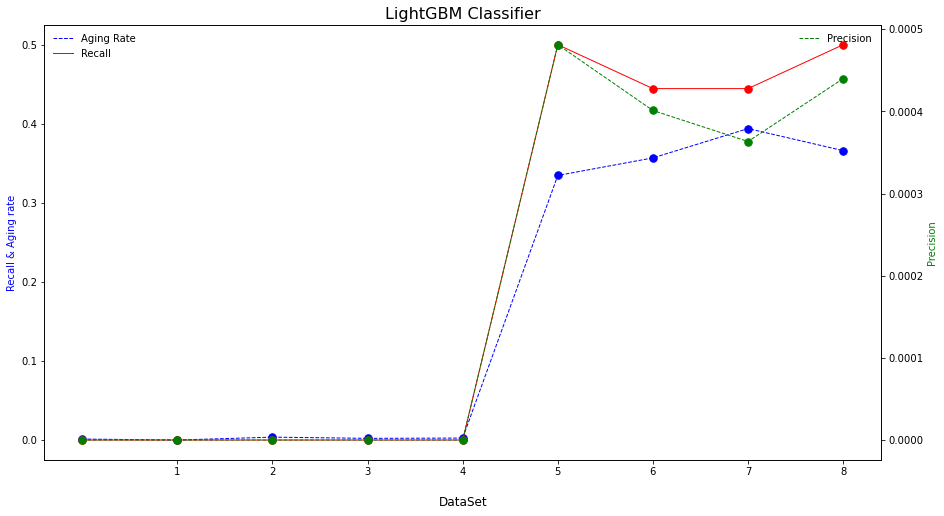


Run Time：4.583544 seconds


In [23]:
start = time.time()

# event_clf_param = {
#         'objective': 'binary',
#         'metric': 'binary_logloss',
#         'boosting_type': 'goss',
#         'num_iterations': 100,
#         'subsample': 0.5,
#         'num_leaves': 20,
#         'min_child_samples': 3,
#         'max_depth': 13,
#         'learning_rate': 0.375,
#         'lambda_l1': 0.001,
#         'lambda_l2': 0.02
# }

run_clf_param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'num_iterations': 150,
        'subsample': 0.6,
        'num_leaves': 18,
        'min_child_samples': 3,
        'max_depth': 9,
        'learning_rate': 0.525,
        'lambda_l1': 0.004,
        'lambda_l2': 0.003
} 

# run_clf_param = {
#         'objective': 'binary',
#         'metric': 'binary_logloss',
#         'boosting_type': 'goss',
#         'num_iterations': 100,
#         'subsample': 0.7,
#         'num_leaves': 20,
#         'min_child_samples': 3,
#         'max_depth': 7,
#         'learning_rate': 0.125,
#         'lambda_l1': 0.0006,
#         'lambda_l2': 0.003
# } #tpe/recall-0.1*aging/set6

#table_set1, bad_set1 = runall_LightGBMC(9, trainset_x, test_x, trainset_y, test_y, event_clf_param)
table_set1 = runall_LightGBMC(9, trainset_x, run_test_x, trainset_y, run_test_y, run_clf_param, record_bad = False)
line_chart(table_set1, title = 'LightGBM Classifier')
#bad_plot(bad_set1)

end = time.time()
print("\nRun Time：%f seconds" % (end - start))

In [22]:
table_set1

,Balance Ratio,Train_OK,Train_NG,TP,FP,FN,TN,Precision,Recall,Aging Rate,Efficiency,Score
dataset 0,122.116386,79742.0,653.0,0.0,69.0,18.0,55816.0,0.000000,0.000000,0.001234,0.000000,0.000000
dataset 1,2.000100,79742.0,39869.0,0.0,0.0,18.0,55885.0,0.000000,0.000000,0.000000,NaN,NaN
dataset 2,1.983780,79742.0,40197.0,0.0,204.0,18.0,55681.0,0.000000,0.000000,0.003649,0.000000,0.000000
dataset 3,1.983780,79742.0,40197.0,0.0,118.0,18.0,55767.0,0.000000,0.000000,0.002111,0.000000,0.000000
dataset 4,2.000000,79742.0,39871.0,0.0,138.0,18.0,55747.0,0.000000,0.000000,0.002469,0.000000,0.000000
dataset 5,1.994502,3265.0,1637.0,9.0,18697.0,9.0,37188.0,0.000481,0.500000,0.334615,1.494253,0.456995
dataset 6,1.666667,3265.0,1959.0,8.0,19940.0,10.0,35945.0,0.000401,0.444444,0.356832,1.245527,0.359529
dataset 7,1.666667,3265.0,1959.0,8.0,22012.0,10.0,33873.0,0.000363,0.444444,0.393897,1.128328,0.335705
dataset 8,2.000613,3265.0,1632.0,9.0,20453.0,9.0,35432.0,0.000440,0.500000,0.366027,1.366020,0.430605


### Optuna

In [27]:
#####Optimization#####
start = time.time()

study = optuna.create_study(sampler = optuna.samplers.TPESampler(multivariate = False), direction = 'maximize')
#TPE, Random, Grid, CmaEs
study.optimize(objective, n_trials = 5000, show_progress_bar = True, gc_after_trial = True) #n_trials or timeout
 
print(f"Sampler is {study.sampler.__class__.__name__}")
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

with open('tmp.data', 'wb') as f:
    pickle.dump(study, f)

end = time.time()
print("\nRun Time：%f seconds" % (end - start))

[I 2021-07-25 12:17:11,910] A new study created in memory with name: no-name-b0adc73a-bedb-4280-aed4-147f7fd324d8
/home/ruibone/anaconda3/lib/python3.8/site-packages/optuna/progress_bar.py:47: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/5000 [00:00<?, ?it/s]

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:12,233] Trial 0 finished with value: -0.18434430333478427 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.5, 'num_leaves': 10, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.00025521350764995, 'lambda_l2': 2.5404662290094886}. Best is trial 0 with value: -0.18434430333478427.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:12,442] Trial 1 finished with value: -0.18394985653964438 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 100, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 3, 'max_depth': 15, 'learning_rate': 0.37500000000000006, 'lambda_l1': 0.0002911079489110286, 'lambda_l2': 3.8515188969086616}. Best is trial 1 with value: -0.18394985653964438.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:12,672] Trial 2 finished with value: -0.19597822740354168 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.5, 'num_leaves': 15, 'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.025, 'lambda_l1': 0.027638441776950073, 'lambda_l2': 0.633440206437546}. Best is trial 1 with value: -0.18394985653964438.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:12,876] Trial 3 finished with value: -0.18423988473443095 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.5, 'num_leaves': 10, 'min_child_samples': 24, 'max_depth': 7, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.5067962066721705, 'lambda_l2': 0.0010826245157898534}. Best is trial 1 with value: -0.18394985653964438.
[I 2021-07-25 12:17:13,162] Trial 4 finished with value: -0.19183449293948618 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 3, 'max_depth': 15, 'learning_rate': 0.37500000000000006, 'lambda_l1': 0.005882497190095234, 'lambda_l2': 0.0002221846800815578}. Best is trial 1 with value: -0.18394985653964438.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:13,456] Trial 5 finished with value: -0.18852198558635747 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.125, 'lambda_l1': 0.0008780917152527731, 'lambda_l2': 1.2592034168386175}. Best is trial 1 with value: -0.18394985653964438.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:13,694] Trial 6 finished with value: -0.18880429519180422 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 24, 'max_depth': 9, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.47377702389881987, 'lambda_l2': 2.1780285809383297}. Best is trial 1 with value: -0.18394985653964438.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:14,197] Trial 7 finished with value: -0.19271731115895174 and parameters: {'boosting_type': 'goss', 'num_iterations': 250, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 24, 'max_depth': 15, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.0008466304874606702, 'lambda_l2': 0.14297322358552303}. Best is trial 1 with value: -0.18394985653964438.
[I 2021-07-25 12:17:14,382] Trial 8 finished with value: -0.19789276815452683 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 100, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.025, 'lambda_l1': 4.6929661673176755, 'lambda_l2': 0.004181650286006541}. Best is trial 1 with value: -0.18394985653964438.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:14,635] Trial 9 finished with value: -0.18310645737228848 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 9, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.7690381367322803, 'lambda_l2': 1.9081151295279801}. Best is trial 9 with value: -0.18310645737228848.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:14,880] Trial 10 finished with value: -0.18888953910984174 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 9, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 2.9250428035911025, 'lambda_l2': 0.04721550694040738}. Best is trial 9 with value: -0.18310645737228848.
[I 2021-07-25 12:17:15,075] Trial 11 finished with value: -0.19285137028894553 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 100, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 6, 'max_depth': 13, 'learning_rate': 0.225, 'lambda_l1': 0.04559899445637482, 'lambda_l2': 4.279235426429445}. Best is trial 9 with value: -0.18310645737228848.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:15,308] Trial 12 finished with value: -0.19137692758994831 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 250, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 9, 'max_depth': 11, 'learning_rate': 0.425, 'lambda_l1': 0.24920677747224307, 'lambda_l2': 0.2527216683024465}. Best is trial 9 with value: -0.18310645737228848.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:15,687] Trial 13 finished with value: -0.1889227754119346 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 250, 'subsample': 0.9, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.275, 'lambda_l1': 0.00016716297168807917, 'lambda_l2': 0.014955083945504986}. Best is trial 9 with value: -0.18310645737228848.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:15,918] Trial 14 finished with value: -0.1894531177361842 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 6, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.005210065682385367, 'lambda_l2': 4.805204117248749}. Best is trial 9 with value: -0.18310645737228848.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:16,164] Trial 15 finished with value: -0.18872704658288256 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 6, 'max_depth': 9, 'learning_rate': 0.425, 'lambda_l1': 0.07869912786592029, 'lambda_l2': 0.39615767349798486}. Best is trial 9 with value: -0.18310645737228848.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:16,409] Trial 16 finished with value: -0.1826873637575984 and parameters: {'boosting_type': 'goss', 'num_iterations': 100, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'lambda_l1': 1.9815065892744435, 'lambda_l2': 0.06734609885430327}. Best is trial 16 with value: -0.1826873637575984.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:16,746] Trial 17 finished with value: -0.18562797057304736 and parameters: {'boosting_type': 'goss', 'num_iterations': 250, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.275, 'lambda_l1': 1.5920991956601516, 'lambda_l2': 0.056756199687442103}. Best is trial 16 with value: -0.1826873637575984.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:17,092] Trial 18 finished with value: -0.1822051106191432 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 1.1286443895072245, 'lambda_l2': 0.00807226786869796}. Best is trial 18 with value: -0.1822051106191432.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:17,457] Trial 19 finished with value: -0.17987568243924543 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.13390351594810035, 'lambda_l2': 0.0041480445851366145}. Best is trial 19 with value: -0.17987568243924543.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:17,976] Trial 20 finished with value: -0.190789645224992 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.09563395131554632, 'lambda_l2': 0.00618632657283291}. Best is trial 19 with value: -0.17987568243924543.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:18,240] Trial 21 finished with value: -0.18886956312013084 and parameters: {'boosting_type': 'goss', 'num_iterations': 100, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 1.616489449429764, 'lambda_l2': 0.0010903704425127188}. Best is trial 19 with value: -0.17987568243924543.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:18,547] Trial 22 finished with value: -0.18850402206774097 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 18, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.17367438037135444, 'lambda_l2': 0.0025883243220628893}. Best is trial 19 with value: -0.17987568243924543.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:18,783] Trial 23 finished with value: -0.18801590278528313 and parameters: {'boosting_type': 'goss', 'num_iterations': 100, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 15, 'max_depth': 5, 'learning_rate': 0.275, 'lambda_l1': 4.99330802891642, 'lambda_l2': 0.012799872635231278}. Best is trial 19 with value: -0.17987568243924543.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:19,110] Trial 24 finished with value: -0.18946565265646476 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 9, 'learning_rate': 0.125, 'lambda_l1': 0.798539206865259, 'lambda_l2': 0.04933785374475602}. Best is trial 19 with value: -0.17987568243924543.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:19,432] Trial 25 finished with value: -0.1890403854168967 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 1.990859938264361, 'lambda_l2': 0.00033417628015472694}. Best is trial 19 with value: -0.17987568243924543.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:19,690] Trial 26 finished with value: -0.19279578995959898 and parameters: {'boosting_type': 'goss', 'num_iterations': 100, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 9, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.24625320433553244, 'lambda_l2': 0.026451095713247722}. Best is trial 19 with value: -0.17987568243924543.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:20,018] Trial 27 finished with value: -0.1822049679586714 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.011746929301976208, 'lambda_l2': 0.0016738075152365186}. Best is trial 19 with value: -0.17987568243924543.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:20,388] Trial 28 finished with value: -0.1796998662144175 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 5, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.009653669641917531, 'lambda_l2': 0.0008469423585201607}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:20,703] Trial 29 finished with value: -0.18819859116245988 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 21, 'max_depth': 5, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.008914822551467631, 'lambda_l2': 0.00011740597713577753}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:20,959] Trial 30 finished with value: -0.19972492254926985 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.025, 'lambda_l1': 0.012265090322947786, 'lambda_l2': 0.0009786080273298733}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:21,330] Trial 31 finished with value: -0.18991821136345435 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 15, 'max_depth': 5, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.0034198780010002345, 'lambda_l2': 0.0022603005172811795}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:21,754] Trial 32 finished with value: -0.18599145960292154 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.0015726049204993918, 'lambda_l2': 0.00044284450933894376}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:22,119] Trial 33 finished with value: -0.19269365818771855 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 5, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.021910254225953416, 'lambda_l2': 0.00641235674543369}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:22,450] Trial 34 finished with value: -0.19769379668751616 and parameters: {'boosting_type': 'goss', 'num_iterations': 250, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.025, 'lambda_l1': 0.0227167416857801, 'lambda_l2': 0.0018743459078932726}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:22,838] Trial 35 finished with value: -0.18800220298668033 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.061876744216413086, 'lambda_l2': 0.008904076874197194}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:23,152] Trial 36 finished with value: -0.1885650449333451 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 18, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.014031568201504354, 'lambda_l2': 0.0008372641798936663}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:23,592] Trial 37 finished with value: -0.18418907273941318 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.03733940760276046, 'lambda_l2': 0.00011228904962780135}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:23,913] Trial 38 finished with value: -0.19070220246179156 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 9, 'max_depth': 5, 'learning_rate': 0.125, 'lambda_l1': 0.0024061698950439566, 'lambda_l2': 0.0037680485398029697}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:24,210] Trial 39 finished with value: -0.19808165752576734 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.025, 'lambda_l1': 0.007029477836872282, 'lambda_l2': 0.0005025251538851427}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:24,673] Trial 40 finished with value: -0.1872819394994868 and parameters: {'boosting_type': 'goss', 'num_iterations': 250, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.13289333941421588, 'lambda_l2': 0.022227775404863592}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:24,921] Trial 41 finished with value: -0.18741750844007976 and parameters: {'boosting_type': 'goss', 'num_iterations': 100, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 12, 'max_depth': 9, 'learning_rate': 0.37500000000000006, 'lambda_l1': 0.4605844434322734, 'lambda_l2': 0.09475607496862992}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:25,245] Trial 42 finished with value: -0.18746450252853297 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.225, 'lambda_l1': 0.8575298466426717, 'lambda_l2': 0.0014110985183765701}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:25,518] Trial 43 finished with value: -0.1835952324759743 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 9, 'max_depth': 5, 'learning_rate': 0.275, 'lambda_l1': 2.7040951947825214, 'lambda_l2': 0.0033109212338051585}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:25,814] Trial 44 finished with value: -0.1860399386332149 and parameters: {'boosting_type': 'goss', 'num_iterations': 100, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.37500000000000006, 'lambda_l1': 0.0005964991111276693, 'lambda_l2': 0.005484390162642501}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:26,141] Trial 45 finished with value: -0.18656468908572466 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 12, 'max_depth': 9, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.015758281229511353, 'lambda_l2': 0.0001818898595333625}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:26,400] Trial 46 finished with value: -0.18574052486173528 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.225, 'lambda_l1': 0.33883673162308325, 'lambda_l2': 0.0006055098189641564}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:26,694] Trial 47 finished with value: -0.1886447317352206 and parameters: {'boosting_type': 'goss', 'num_iterations': 100, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.028525493956816902, 'lambda_l2': 0.010832660597357258}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:27,115] Trial 48 finished with value: -0.19257643858033843 and parameters: {'boosting_type': 'goss', 'num_iterations': 250, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 9, 'max_depth': 5, 'learning_rate': 0.125, 'lambda_l1': 0.004087900873122246, 'lambda_l2': 0.02434594159466495}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:27,504] Trial 49 finished with value: -0.18788039556321248 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 18, 'max_depth': 13, 'learning_rate': 0.025, 'lambda_l1': 1.2635527660077488, 'lambda_l2': 0.14001832906978623}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:27,842] Trial 50 finished with value: -0.18919784413648086 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'lambda_l1': 3.449225960282616, 'lambda_l2': 0.001680179835905606}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:28,121] Trial 51 finished with value: -0.18468572033460454 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 9, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.6577395745049835, 'lambda_l2': 2.022563913383341}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:28,384] Trial 52 finished with value: -0.18613358963660664 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 6, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 1.0645499413964248, 'lambda_l2': 0.5838066803841745}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:28,636] Trial 53 finished with value: -0.18812359837994053 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 250, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 9, 'max_depth': 11, 'learning_rate': 0.275, 'lambda_l1': 0.4988676673388761, 'lambda_l2': 0.004641431127385198}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:28,975] Trial 54 finished with value: -0.18799861487758154 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 12, 'max_depth': 9, 'learning_rate': 0.125, 'lambda_l1': 0.055990075832316265, 'lambda_l2': 0.007826535807093702}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:29,285] Trial 55 finished with value: -0.19015043179019453 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 6, 'max_depth': 9, 'learning_rate': 0.225, 'lambda_l1': 0.15131284740269127, 'lambda_l2': 1.4163625490893808}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:29,583] Trial 56 finished with value: -0.18829201220059955 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 9, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 2.130723719574162, 'lambda_l2': 0.00273086992059221}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:29,820] Trial 57 finished with value: -0.1853516391927361 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.5, 'num_leaves': 15, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.37500000000000006, 'lambda_l1': 0.2775579372745634, 'lambda_l2': 0.2664110164602554}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:30,097] Trial 58 finished with value: -0.18832404143849227 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.225, 'lambda_l1': 4.100124540808165, 'lambda_l2': 0.015222852225315045}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:30,434] Trial 59 finished with value: -0.1899185741495342 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 18, 'max_depth': 9, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.10147763015522786, 'lambda_l2': 0.00023959836612599762}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:30,692] Trial 60 finished with value: -0.18896596765994822 and parameters: {'boosting_type': 'goss', 'num_iterations': 100, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 3, 'max_depth': 5, 'learning_rate': 0.425, 'lambda_l1': 0.008479805544627461, 'lambda_l2': 0.0007165797389022267}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:30,965] Trial 61 finished with value: -0.19473641146227397 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 9, 'max_depth': 5, 'learning_rate': 0.275, 'lambda_l1': 2.8463920638684246, 'lambda_l2': 0.0037289002708510034}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:31,231] Trial 62 finished with value: -0.1917523028112492 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.275, 'lambda_l1': 1.2167672596025851, 'lambda_l2': 0.002908174051420685}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:31,501] Trial 63 finished with value: -0.18852317198208776 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 6, 'max_depth': 5, 'learning_rate': 0.32500000000000007, 'lambda_l1': 2.2566679504055953, 'lambda_l2': 0.0012103687664187348}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:31,778] Trial 64 finished with value: -0.17982426654078307 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 9, 'max_depth': 5, 'learning_rate': 0.275, 'lambda_l1': 1.4559871336306498, 'lambda_l2': 0.002033499230584066}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:32,088] Trial 65 finished with value: -0.18247498445260565 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.6385877754683427, 'lambda_l2': 0.001746889921090663}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:32,400] Trial 66 finished with value: -0.19350331270199184 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.3761347336271303, 'lambda_l2': 0.001963355621775068}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:32,647] Trial 67 finished with value: -0.1865919356631216 and parameters: {'boosting_type': 'goss', 'num_iterations': 100, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.654672481118869, 'lambda_l2': 0.03601874783309454}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:32,966] Trial 68 finished with value: -0.19079584438687092 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.275, 'lambda_l1': 0.21404759684789024, 'lambda_l2': 0.00033768846589355496}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:33,232] Trial 69 finished with value: -0.18706414039362573 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.37500000000000006, 'lambda_l1': 1.5185513095213299, 'lambda_l2': 0.0009998809226253757}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:33,517] Trial 70 finished with value: -0.18501107086862845 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.32500000000000007, 'lambda_l1': 4.885547185653609, 'lambda_l2': 0.0016167590319623364}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:33,831] Trial 71 finished with value: -0.18343281925677937 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 9, 'max_depth': 5, 'learning_rate': 0.275, 'lambda_l1': 0.8691014293640752, 'lambda_l2': 0.007580516713461095}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:34,148] Trial 72 finished with value: -0.1893524294919037 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.225, 'lambda_l1': 1.6804608041878448, 'lambda_l2': 0.005233629586409523}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:34,507] Trial 73 finished with value: -0.18887904222575544 and parameters: {'boosting_type': 'goss', 'num_iterations': 250, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 21, 'max_depth': 15, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.6784073614038149, 'lambda_l2': 0.0021763791578858094}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:34,747] Trial 74 finished with value: -0.19084819712531176 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.275, 'lambda_l1': 1.0105826758810648, 'lambda_l2': 0.01720092231308626}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:35,060] Trial 75 finished with value: -0.19021145235120707 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.225, 'lambda_l1': 0.010526512374302159, 'lambda_l2': 3.296387662266881}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:35,403] Trial 76 finished with value: -0.18509632985553273 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 9, 'max_depth': 9, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.006358790243981506, 'lambda_l2': 0.0012659743152591712}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:35,807] Trial 77 finished with value: -0.19142367997838497 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.015012524426056145, 'lambda_l2': 0.0008756051415680233}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:36,118] Trial 78 finished with value: -0.18520764924645675 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 6, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.3598199075447613, 'lambda_l2': 0.000638686585441598}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:36,346] Trial 79 finished with value: -0.1928488269863231 and parameters: {'boosting_type': 'goss', 'num_iterations': 100, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.002742250962050845, 'lambda_l2': 0.010369459902620486}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:36,821] Trial 80 finished with value: -0.18327935116258778 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 250, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.025, 'lambda_l1': 0.034080195604699465, 'lambda_l2': 0.07125142140539024}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:37,112] Trial 81 finished with value: -0.1937317760305519 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 250, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.275, 'lambda_l1': 0.03030689999664231, 'lambda_l2': 0.03625835902117505}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:37,664] Trial 82 finished with value: -0.18664664514541643 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 24, 'max_depth': 7, 'learning_rate': 0.025, 'lambda_l1': 0.020257971569233642, 'lambda_l2': 0.18458816712384388}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:38,165] Trial 83 finished with value: -0.18732067357918383 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 250, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 15, 'max_depth': 9, 'learning_rate': 0.025, 'lambda_l1': 0.04019087200565554, 'lambda_l2': 0.07938907472759581}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:38,582] Trial 84 finished with value: -0.1923603528976839 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 250, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.0964258650582575, 'lambda_l2': 0.08513894899412376}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:38,862] Trial 85 finished with value: -0.18867964557355732 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 5, 'learning_rate': 0.125, 'lambda_l1': 0.07272399041339567, 'lambda_l2': 0.0024307960190729505}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:39,489] Trial 86 finished with value: -0.18260872147704407 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.025, 'lambda_l1': 0.5591268486686133, 'lambda_l2': 0.004249475581926936}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:39,989] Trial 87 finished with value: -0.19068608784361626 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.5315839322928715, 'lambda_l2': 0.00393643557523602}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:40,260] Trial 88 finished with value: -0.19608064005838155 and parameters: {'boosting_type': 'goss', 'num_iterations': 100, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 9, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 1.4733256027630321, 'lambda_l2': 0.004753358537876784}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:40,605] Trial 89 finished with value: -0.18343321167237459 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.37500000000000006, 'lambda_l1': 0.004999460824792453, 'lambda_l2': 0.006598202519828756}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:40,885] Trial 90 finished with value: -0.19530019653124042 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 9, 'max_depth': 13, 'learning_rate': 0.225, 'lambda_l1': 3.402556711117206, 'lambda_l2': 0.003143025577758338}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:41,465] Trial 91 finished with value: -0.1876347939258991 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 15, 'max_depth': 9, 'learning_rate': 0.025, 'lambda_l1': 0.8954216912733575, 'lambda_l2': 0.0016904081088724937}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:42,055] Trial 92 finished with value: -0.19433837430729448 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.025, 'lambda_l1': 0.5822435930992276, 'lambda_l2': 0.012382238771917206}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:42,425] Trial 93 finished with value: -0.18738931124006167 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.025, 'lambda_l1': 1.9219703625292126, 'lambda_l2': 0.9117522490354485}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:42,870] Trial 94 finished with value: -0.18742440980932196 and parameters: {'boosting_type': 'goss', 'num_iterations': 250, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.4455825106841394, 'lambda_l2': 0.0004240677119762753}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:43,197] Trial 95 finished with value: -0.19145216197381618 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.20775538928162965, 'lambda_l2': 0.018439218222113012}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:43,703] Trial 96 finished with value: -0.1907002904531642 and parameters: {'boosting_type': 'goss', 'num_iterations': 250, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.025, 'lambda_l1': 1.0912228555133179, 'lambda_l2': 0.40678531373962235}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:43,978] Trial 97 finished with value: -0.1913246575741782 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 5, 'learning_rate': 0.275, 'lambda_l1': 0.008720224119769646, 'lambda_l2': 0.0013403655726609857}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:44,322] Trial 98 finished with value: -0.18894568547593574 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 15, 'max_depth': 9, 'learning_rate': 0.125, 'lambda_l1': 0.26534369694574456, 'lambda_l2': 0.008787428773291651}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:44,776] Trial 99 finished with value: -0.1891421606879591 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 9, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.018014426332935693, 'lambda_l2': 0.06666228247806043}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:45,097] Trial 100 finished with value: -0.1870303523952402 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.225, 'lambda_l1': 0.13271152328415423, 'lambda_l2': 0.12950790365954504}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:45,411] Trial 101 finished with value: -0.18612772144474196 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 9, 'max_depth': 5, 'learning_rate': 0.275, 'lambda_l1': 0.715958216072431, 'lambda_l2': 0.007237005602044141}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:45,725] Trial 102 finished with value: -0.1866388688845917 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 9, 'max_depth': 5, 'learning_rate': 0.275, 'lambda_l1': 0.8307042268612096, 'lambda_l2': 0.0024186264715810465}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:46,029] Trial 103 finished with value: -0.1892415790858578 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 9, 'max_depth': 5, 'learning_rate': 0.32500000000000007, 'lambda_l1': 1.2121645093395126, 'lambda_l2': 0.005314278927826676}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:46,328] Trial 104 finished with value: -0.1852358339960157 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.37500000000000006, 'lambda_l1': 2.4730800940275035, 'lambda_l2': 0.0036832247975638944}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:46,634] Trial 105 finished with value: -0.18881119232533525 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.275, 'lambda_l1': 0.011604826482272526, 'lambda_l2': 0.00962477098990075}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:46,948] Trial 106 finished with value: -0.18198754447852897 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.404157155843329, 'lambda_l2': 0.04003120742615309}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:47,187] Trial 107 finished with value: -0.19185801939040803 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.4175537202332687, 'lambda_l2': 0.03248794012682126}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:47,529] Trial 108 finished with value: -0.18640169920659214 and parameters: {'boosting_type': 'goss', 'num_iterations': 250, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.31223960904414344, 'lambda_l2': 0.0509273065512408}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:47,798] Trial 109 finished with value: -0.1848238599377404 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.37500000000000006, 'lambda_l1': 1.366516986556074, 'lambda_l2': 0.06296983143550045}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:48,132] Trial 110 finished with value: -0.19121165217572608 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 15, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.5370749298015511, 'lambda_l2': 0.001099537713364674}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:48,441] Trial 111 finished with value: -0.1936451948615492 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 9, 'max_depth': 5, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.651814290715805, 'lambda_l2': 0.1153566227640738}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:48,761] Trial 112 finished with value: -0.18462165012653742 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.225, 'lambda_l1': 0.967599052139093, 'lambda_l2': 0.04212576225900624}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:49,060] Trial 113 finished with value: -0.18886109275370425 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 9, 'max_depth': 7, 'learning_rate': 0.32500000000000007, 'lambda_l1': 1.9927620863197613, 'lambda_l2': 0.0029835195832979907}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:49,363] Trial 114 finished with value: -0.18766544547631944 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.2080299817557251, 'lambda_l2': 0.0007763923353016181}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:49,611] Trial 115 finished with value: -0.19545777694143682 and parameters: {'boosting_type': 'goss', 'num_iterations': 100, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 5, 'learning_rate': 0.275, 'lambda_l1': 1.680448210637837, 'lambda_l2': 0.029731161319257224}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:49,987] Trial 116 finished with value: -0.1914209178298317 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 9, 'max_depth': 5, 'learning_rate': 0.025, 'lambda_l1': 0.8521862889462204, 'lambda_l2': 0.022655799053444517}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:50,266] Trial 117 finished with value: -0.1921009209659653 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.225, 'lambda_l1': 0.027636420729056484, 'lambda_l2': 0.0015469380072627703}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:50,586] Trial 118 finished with value: -0.18949171827226005 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.275, 'lambda_l1': 0.427119887930938, 'lambda_l2': 0.0018765948162538274}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:51,025] Trial 119 finished with value: -0.18019123075987234 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 5, 'learning_rate': 0.125, 'lambda_l1': 0.04920911961913445, 'lambda_l2': 0.006058897275251085}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:51,486] Trial 120 finished with value: -0.1878767588091308 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.1154718546997571, 'lambda_l2': 0.00434288205711391}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:51,901] Trial 121 finished with value: -0.19099156680818488 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.07136204515542953, 'lambda_l2': 0.007260237339335947}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:52,374] Trial 122 finished with value: -0.19116241236021045 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 21, 'max_depth': 5, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.036874294166413704, 'lambda_l2': 0.006352880627015266}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:52,810] Trial 123 finished with value: -0.19267440860806148 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 5, 'learning_rate': 0.125, 'lambda_l1': 0.16568070197634843, 'lambda_l2': 0.01316445332973826}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:53,235] Trial 124 finished with value: -0.1868671064706077 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.054762293883415, 'lambda_l2': 0.0020967287919213895}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:53,563] Trial 125 finished with value: -0.18818048860080597 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.7303838812552149, 'lambda_l2': 0.0032460517467882387}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:54,030] Trial 126 finished with value: -0.18637610194259405 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.024722352659945254, 'lambda_l2': 0.011538678972693018}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:54,438] Trial 127 finished with value: -0.1916377130843985 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 15, 'max_depth': 5, 'learning_rate': 0.025, 'lambda_l1': 1.1845276700336576, 'lambda_l2': 0.20780257366894636}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:54,790] Trial 128 finished with value: -0.1877561081817177 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 9, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.046352464536589436, 'lambda_l2': 0.005555470574993097}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:55,164] Trial 129 finished with value: -0.18825745455034215 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 6, 'max_depth': 5, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.018083723708343012, 'lambda_l2': 0.017173587238872322}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:55,506] Trial 130 finished with value: -0.1803939016842531 and parameters: {'boosting_type': 'goss', 'num_iterations': 250, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.125, 'lambda_l1': 0.007758348024688667, 'lambda_l2': 0.004056436148187144}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:55,845] Trial 131 finished with value: -0.1858783262349004 and parameters: {'boosting_type': 'goss', 'num_iterations': 250, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.125, 'lambda_l1': 0.0056138697598073556, 'lambda_l2': 0.004609218360564819}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:56,182] Trial 132 finished with value: -0.1864850905868299 and parameters: {'boosting_type': 'goss', 'num_iterations': 250, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.125, 'lambda_l1': 0.013289166006469176, 'lambda_l2': 0.008469225892078356}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:56,536] Trial 133 finished with value: -0.19097433069354894 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.308054739311394, 'lambda_l2': 0.0026353101954060595}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:56,996] Trial 134 finished with value: -0.19128520482905123 and parameters: {'boosting_type': 'goss', 'num_iterations': 250, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.0074862460669270145, 'lambda_l2': 0.0009419431228432729}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:57,376] Trial 135 finished with value: -0.19229718329170797 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.010604908585512175, 'lambda_l2': 0.003705342300889316}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:57,838] Trial 136 finished with value: -0.18272903094000967 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 9, 'max_depth': 11, 'learning_rate': 0.025, 'lambda_l1': 0.0034366085054900676, 'lambda_l2': 0.001501468129275187}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:58,268] Trial 137 finished with value: -0.1869071026486436 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.025, 'lambda_l1': 0.002241278810090219, 'lambda_l2': 0.0013466890711681344}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:58,734] Trial 138 finished with value: -0.18710186928083097 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 9, 'max_depth': 11, 'learning_rate': 0.025, 'lambda_l1': 0.0037334526123187425, 'lambda_l2': 0.0005719177094429239}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:59,163] Trial 139 finished with value: -0.1863129930708978 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.025, 'lambda_l1': 0.004542778483132229, 'lambda_l2': 0.0017870173020963702}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:17:59,601] Trial 140 finished with value: -0.19073918527416264 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.0015576314785531345, 'lambda_l2': 0.0022403682655758672}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:00,170] Trial 141 finished with value: -0.18966773399849368 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 9, 'max_depth': 11, 'learning_rate': 0.025, 'lambda_l1': 0.009306774733618127, 'lambda_l2': 0.002852867160934869}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:00,426] Trial 142 finished with value: -0.1865055292437862 and parameters: {'boosting_type': 'goss', 'num_iterations': 100, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 9, 'max_depth': 9, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.5795459667627001, 'lambda_l2': 0.005711490166222495}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:00,793] Trial 143 finished with value: -0.18650164617430476 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 9, 'max_depth': 5, 'learning_rate': 0.225, 'lambda_l1': 0.007190277284206155, 'lambda_l2': 0.0011420406791264363}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:01,136] Trial 144 finished with value: -0.18559884166177706 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 9, 'max_depth': 5, 'learning_rate': 0.025, 'lambda_l1': 0.03225629949098943, 'lambda_l2': 0.003993065746764118}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:01,449] Trial 145 finished with value: -0.19306587457428837 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.8303228617647271, 'lambda_l2': 0.04690257444856282}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:01,835] Trial 146 finished with value: -0.19091681994378093 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 9, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.0016488236203167927, 'lambda_l2': 0.09930646968771491}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:02,100] Trial 147 finished with value: -0.18526979682865727 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.015140837905941817, 'lambda_l2': 0.0014429515226578465}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:02,418] Trial 148 finished with value: -0.18596764605179125 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 5, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.0028335226602619313, 'lambda_l2': 0.007610695373110224}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:02,770] Trial 149 finished with value: -0.18492652064554904 and parameters: {'boosting_type': 'goss', 'num_iterations': 250, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.225, 'lambda_l1': 1.0754785182547972, 'lambda_l2': 0.0020244796315252375}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:03,147] Trial 150 finished with value: -0.19521407963610773 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 6, 'max_depth': 5, 'learning_rate': 0.025, 'lambda_l1': 3.32770314498667, 'lambda_l2': 0.0008190467871519969}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:03,485] Trial 151 finished with value: -0.18688714038737894 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.425, 'lambda_l1': 0.00564803929604639, 'lambda_l2': 0.006664664810725964}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:03,834] Trial 152 finished with value: -0.1885250766071164 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.37500000000000006, 'lambda_l1': 0.0031349374082944217, 'lambda_l2': 0.004634422143025978}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:04,189] Trial 153 finished with value: -0.19428275691860855 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.37500000000000006, 'lambda_l1': 0.004487229039524045, 'lambda_l2': 0.010137594190468956}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:04,507] Trial 154 finished with value: -0.18583485859274806 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.275, 'lambda_l1': 1.4564302044483854, 'lambda_l2': 0.005925284309174167}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:04,914] Trial 155 finished with value: -0.18689333043539635 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 9, 'max_depth': 11, 'learning_rate': 0.275, 'lambda_l1': 0.0051042267369332435, 'lambda_l2': 0.06942980638714205}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:05,280] Trial 156 finished with value: -0.18304890667452622 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 9, 'learning_rate': 0.225, 'lambda_l1': 0.008095705872423333, 'lambda_l2': 0.0025820001568832795}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:05,641] Trial 157 finished with value: -0.19149065161933473 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 9, 'learning_rate': 0.225, 'lambda_l1': 0.012096788748171022, 'lambda_l2': 0.0033499419909335804}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:06,011] Trial 158 finished with value: -0.18660924716425717 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.225, 'lambda_l1': 0.007506495965071464, 'lambda_l2': 0.0027517659192319017}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:06,323] Trial 159 finished with value: -0.18407215792723974 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 5, 'learning_rate': 0.225, 'lambda_l1': 0.022350337616501452, 'lambda_l2': 0.0017177184946208198}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:06,694] Trial 160 finished with value: -0.18870301814428445 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.5185195023910553, 'lambda_l2': 4.9991305878502175}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:07,060] Trial 161 finished with value: -0.18183094405122766 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.009232010604862924, 'lambda_l2': 0.00431440312066208}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:07,426] Trial 162 finished with value: -0.18189927828483557 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.010046260640746959, 'lambda_l2': 0.0023928929496223315}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:07,785] Trial 163 finished with value: -0.18841381812672578 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.009506609760942097, 'lambda_l2': 0.002475967625728577}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:08,144] Trial 164 finished with value: -0.18650985625407604 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.014363984971161673, 'lambda_l2': 0.003681297299276154}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:08,512] Trial 165 finished with value: -0.19285449995374326 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.00662747639877353, 'lambda_l2': 0.0021822557678208977}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:08,873] Trial 166 finished with value: -0.18437576671428738 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.225, 'lambda_l1': 0.011404287501560525, 'lambda_l2': 0.0010628208683768575}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:09,160] Trial 167 finished with value: -0.18409000352819935 and parameters: {'boosting_type': 'goss', 'num_iterations': 100, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.01913552379339266, 'lambda_l2': 0.0030410957057527715}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:09,549] Trial 168 finished with value: -0.1893173857788484 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 15, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.016456701287619394, 'lambda_l2': 0.0013472638590233644}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:09,980] Trial 169 finished with value: -0.1922753905316771 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.009322331810435677, 'lambda_l2': 0.004719536462914329}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:10,343] Trial 170 finished with value: -0.18236562609684717 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.04856892789588658, 'lambda_l2': 0.0016344935645708995}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:10,689] Trial 171 finished with value: -0.18546490970189802 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.04486371534257046, 'lambda_l2': 0.0017160290885249046}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:11,030] Trial 172 finished with value: -0.18416686980708485 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.0632237802006179, 'lambda_l2': 0.002354837826251772}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:11,395] Trial 173 finished with value: -0.18752577419652605 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.025179101075323996, 'lambda_l2': 0.001625697926042233}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:11,723] Trial 174 finished with value: -0.18574640836752007 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.08561841908183726, 'lambda_l2': 0.003404931043863564}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:12,099] Trial 175 finished with value: -0.18736538384789603 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.0001219146644404222, 'lambda_l2': 0.0019666692467880755}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:12,464] Trial 176 finished with value: -0.1938130243107853 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.05067818737897134, 'lambda_l2': 0.00121043876138015}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:12,826] Trial 177 finished with value: -0.19330010550979893 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 3, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.036345839786555666, 'lambda_l2': 0.0007043887350222655}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:13,160] Trial 178 finished with value: -0.18448908085311053 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.008137689928277929, 'lambda_l2': 0.004045436468285534}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:13,751] Trial 179 finished with value: -0.19254922943390915 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.025, 'lambda_l1': 0.006270681590993082, 'lambda_l2': 0.0024877710919573017}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:14,111] Trial 180 finished with value: -0.18912890543884497 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.012980496220346168, 'lambda_l2': 0.05570176779353684}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:14,417] Trial 181 finished with value: -0.192109449722079 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 9, 'max_depth': 5, 'learning_rate': 0.32500000000000007, 'lambda_l1': 1.0237102340828343, 'lambda_l2': 0.00559284970043373}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:14,732] Trial 182 finished with value: -0.18744455398071466 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 9, 'max_depth': 5, 'learning_rate': 0.225, 'lambda_l1': 2.0425041076741826, 'lambda_l2': 0.004413679573198416}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:15,054] Trial 183 finished with value: -0.18609785898755896 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.275, 'lambda_l1': 0.7090842880283472, 'lambda_l2': 0.008127654881561586}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:15,395] Trial 184 finished with value: -0.18635038705159582 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 9, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 1.2358394737504048, 'lambda_l2': 0.002916902122157413}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:15,770] Trial 185 finished with value: -0.19122245888964953 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.025, 'lambda_l1': 0.646411962684532, 'lambda_l2': 0.04159867493020248}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:16,139] Trial 186 finished with value: -0.19303919207543943 and parameters: {'boosting_type': 'goss', 'num_iterations': 250, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.225, 'lambda_l1': 0.3690314569167218, 'lambda_l2': 0.001384259025681385}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:16,446] Trial 187 finished with value: -0.18418246157149118 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.125, 'lambda_l1': 0.9000049091915553, 'lambda_l2': 1.263752546243596}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:16,679] Trial 188 finished with value: -0.18529835697629535 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 15, 'learning_rate': 0.275, 'lambda_l1': 1.7185222772228534, 'lambda_l2': 0.002211448692697583}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:16,956] Trial 189 finished with value: -0.18762775586643202 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 9, 'max_depth': 5, 'learning_rate': 0.32500000000000007, 'lambda_l1': 2.3975193687074774, 'lambda_l2': 2.2836275518903526}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:17,436] Trial 190 finished with value: -0.18930674134264272 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.025, 'lambda_l1': 0.009866374645630293, 'lambda_l2': 0.0008986256706088087}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:17,785] Trial 191 finished with value: -0.18446632477087024 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.37500000000000006, 'lambda_l1': 0.004320421378651777, 'lambda_l2': 0.006678307104383774}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:18,128] Trial 192 finished with value: -0.18871094375487654 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.37500000000000006, 'lambda_l1': 0.005108997493137388, 'lambda_l2': 0.005148256181465392}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:18,640] Trial 193 finished with value: -0.18790980117958378 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.005933424706430589, 'lambda_l2': 0.009338932653197969}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:18,967] Trial 194 finished with value: -0.192438990748194 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.425, 'lambda_l1': 0.007794389058083785, 'lambda_l2': 0.0034616078966062907}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:19,347] Trial 195 finished with value: -0.18651295405399945 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.275, 'lambda_l1': 0.0039620033190535305, 'lambda_l2': 0.014619595682656597}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:19,657] Trial 196 finished with value: -0.1936982139386337 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.5085314556349148, 'lambda_l2': 0.004261543112389028}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:20,060] Trial 197 finished with value: -0.18790389702593602 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.002084386917723587, 'lambda_l2': 0.006646443075542267}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:20,417] Trial 198 finished with value: -0.19423168249875808 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 5, 'learning_rate': 0.225, 'lambda_l1': 0.011379110524423983, 'lambda_l2': 0.0028133299391803037}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:20,848] Trial 199 finished with value: -0.18650004766100303 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 9, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.7961598490596057, 'lambda_l2': 0.027596786418781587}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:21,140] Trial 200 finished with value: -0.18798776575193568 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.031004386763497628, 'lambda_l2': 0.00199324027584826}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:21,419] Trial 201 finished with value: -0.19177737610445236 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 9, 'max_depth': 5, 'learning_rate': 0.275, 'lambda_l1': 2.801089063120282, 'lambda_l2': 0.005232528403809951}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:21,700] Trial 202 finished with value: -0.18700995118560493 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 9, 'max_depth': 5, 'learning_rate': 0.275, 'lambda_l1': 1.3638995521265678, 'lambda_l2': 0.003532903996876111}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:21,980] Trial 203 finished with value: -0.18865526633722665 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 9, 'max_depth': 5, 'learning_rate': 0.275, 'lambda_l1': 1.7388430494979943, 'lambda_l2': 0.0015798937962449}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:22,301] Trial 204 finished with value: -0.18575028639770444 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 9, 'max_depth': 5, 'learning_rate': 0.275, 'lambda_l1': 0.006518691832208292, 'lambda_l2': 0.0029536433247615095}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:22,618] Trial 205 finished with value: -0.1937368767520834 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.008307266190662228, 'lambda_l2': 3.14212120947726}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:23,004] Trial 206 finished with value: -0.19293116515411132 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 9, 'max_depth': 5, 'learning_rate': 0.025, 'lambda_l1': 0.003557177533457544, 'lambda_l2': 0.004170013255105897}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:23,263] Trial 207 finished with value: -0.18474541880857842 and parameters: {'boosting_type': 'goss', 'num_iterations': 100, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.275, 'lambda_l1': 1.0203502691276956, 'lambda_l2': 0.007154969023690244}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:23,531] Trial 208 finished with value: -0.19007497642845692 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.9, 'num_leaves': 5, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 2.805769759455954, 'lambda_l2': 0.0024606998674673764}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:23,820] Trial 209 finished with value: -0.18836807404389622 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.425, 'lambda_l1': 4.912486696991017, 'lambda_l2': 0.001912087407406207}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:24,057] Trial 210 finished with value: -0.18882714640617418 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 24, 'max_depth': 5, 'learning_rate': 0.225, 'lambda_l1': 3.9702135924791535, 'lambda_l2': 0.005276530555355901}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:24,282] Trial 211 finished with value: -0.19338773931322586 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 100, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 3, 'max_depth': 15, 'learning_rate': 0.37500000000000006, 'lambda_l1': 0.0009849658508942253, 'lambda_l2': 3.296373520275802}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:24,486] Trial 212 finished with value: -0.18725761319889034 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 100, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 6, 'max_depth': 7, 'learning_rate': 0.37500000000000006, 'lambda_l1': 0.06137151453040874, 'lambda_l2': 0.6468543582978185}. Best is trial 28 with value: -0.1796998662144175.
[I 2021-07-25 12:18:24,734] Trial 213 finished with value: -0.1879971014337208 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 100, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 6, 'max_depth': 9, 'learning_rate': 0.37500000000000006, 'lambda_l1': 0.04532036716273618, 'lambda_l2': 4.029018017912479}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:24,997] Trial 214 finished with value: -0.19369335361588666 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 100, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.37500000000000006, 'lambda_l1': 0.000316096237272604, 'lambda_l2': 0.001103455694906698}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:25,258] Trial 215 finished with value: -0.1941309235502481 and parameters: {'boosting_type': 'goss', 'num_iterations': 100, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.11790507947721296, 'lambda_l2': 0.0114428894744466}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:25,607] Trial 216 finished with value: -0.18515596828279104 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 3, 'max_depth': 7, 'learning_rate': 0.025, 'lambda_l1': 0.00040232921590868366, 'lambda_l2': 1.7895892444089903}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:25,915] Trial 217 finished with value: -0.18649182577098058 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.37500000000000006, 'lambda_l1': 0.014050626752682017, 'lambda_l2': 0.0032507503179089563}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:26,242] Trial 218 finished with value: -0.1937620172385913 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 5, 'learning_rate': 0.225, 'lambda_l1': 0.6058310142351119, 'lambda_l2': 0.07505336031587787}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:26,735] Trial 219 finished with value: -0.18622769966309885 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.4356833249537386, 'lambda_l2': 0.0015084091963136167}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:27,096] Trial 220 finished with value: -0.18999614633356932 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.125, 'lambda_l1': 0.01055563634066562, 'lambda_l2': 0.019696989283424268}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:27,411] Trial 221 finished with value: -0.18879736239991618 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 5, 'learning_rate': 0.225, 'lambda_l1': 0.0179492980878312, 'lambda_l2': 0.001500007051127851}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:27,722] Trial 222 finished with value: -0.18438963133840533 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 5, 'learning_rate': 0.225, 'lambda_l1': 0.036116312589656224, 'lambda_l2': 0.001836381428449927}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:28,035] Trial 223 finished with value: -0.18623386151480567 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 5, 'learning_rate': 0.225, 'lambda_l1': 0.025046804093988212, 'lambda_l2': 0.0024441832382039864}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:28,351] Trial 224 finished with value: -0.1847114122714503 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 5, 'learning_rate': 0.225, 'lambda_l1': 0.00018602207544989187, 'lambda_l2': 0.0018637587283049123}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:28,675] Trial 225 finished with value: -0.18991342999363436 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.225, 'lambda_l1': 0.023722401632336968, 'lambda_l2': 0.003933471271393254}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:28,990] Trial 226 finished with value: -0.18887981682397995 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.225, 'lambda_l1': 0.020103449735976296, 'lambda_l2': 0.006095107064876132}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:29,263] Trial 227 finished with value: -0.18185553059483506 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.008953867558545664, 'lambda_l2': 0.0025922142896208844}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:29,535] Trial 228 finished with value: -0.19352382631459897 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.008345595898281143, 'lambda_l2': 0.0028467738035150496}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:29,819] Trial 229 finished with value: -0.18428010257870187 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.006326257972256474, 'lambda_l2': 0.0033089918722384957}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:30,051] Trial 230 finished with value: -0.185478930741198 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.8217633331287225, 'lambda_l2': 0.0023589473572656642}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:30,315] Trial 231 finished with value: -0.1815592224718601 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.009494083675179971, 'lambda_l2': 0.0012620710445879005}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:30,582] Trial 232 finished with value: -0.1851002800745829 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.010201774331271079, 'lambda_l2': 0.0012344505970380254}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:30,852] Trial 233 finished with value: -0.189741332499794 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.007710819887628121, 'lambda_l2': 0.0009964827740349886}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:31,118] Trial 234 finished with value: -0.19179576292302247 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.012211568767192258, 'lambda_l2': 0.001388106270133546}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:31,398] Trial 235 finished with value: -0.18722918348400644 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.00928348317182919, 'lambda_l2': 0.004221859599669653}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:31,753] Trial 236 finished with value: -0.182944302544137 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.005488533170708153, 'lambda_l2': 0.09475011567537708}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:32,116] Trial 237 finished with value: -0.18997305557087474 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.005372252472218169, 'lambda_l2': 0.09177555111736922}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:32,455] Trial 238 finished with value: -0.18476157442466787 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.005060092099227585, 'lambda_l2': 0.05903176741419014}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:32,825] Trial 239 finished with value: -0.19057325718300985 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.007274265877647763, 'lambda_l2': 0.17882493305127653}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:33,197] Trial 240 finished with value: -0.19117638516826121 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.0033718207205733976, 'lambda_l2': 0.1183377131940639}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:33,435] Trial 241 finished with value: -0.19107383777505685 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'lambda_l1': 2.2846774163203833, 'lambda_l2': 0.043159428032681815}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:33,700] Trial 242 finished with value: -0.18610052323392354 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.37500000000000006, 'lambda_l1': 0.006777878396172761, 'lambda_l2': 0.0020050610012375633}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:34,032] Trial 243 finished with value: -0.18987903665291392 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.275, 'lambda_l1': 0.009311268811829945, 'lambda_l2': 0.08108113993999289}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:34,268] Trial 244 finished with value: -0.19053381614293186 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'lambda_l1': 1.432377561502063, 'lambda_l2': 0.007775331303629883}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:34,760] Trial 245 finished with value: -0.18084387123255172 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.025, 'lambda_l1': 0.011715477474702607, 'lambda_l2': 0.004859733227686743}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:35,251] Trial 246 finished with value: -0.19007885340152222 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 9, 'max_depth': 11, 'learning_rate': 0.025, 'lambda_l1': 0.009095044143310157, 'lambda_l2': 0.004951019185951255}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:35,785] Trial 247 finished with value: -0.18261893636056206 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.025, 'lambda_l1': 0.013633800347807735, 'lambda_l2': 0.0057037868003923416}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:36,315] Trial 248 finished with value: -0.18539916678401816 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.025, 'lambda_l1': 0.013067058311509592, 'lambda_l2': 0.0058944271252451275}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:36,845] Trial 249 finished with value: -0.18494695475822087 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.025, 'lambda_l1': 0.012217809722874257, 'lambda_l2': 0.008265939922750465}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:37,351] Trial 250 finished with value: -0.18766226534706695 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.025, 'lambda_l1': 0.015315177494448133, 'lambda_l2': 0.0061375960217025126}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:37,882] Trial 251 finished with value: -0.18609440341042005 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.025, 'lambda_l1': 0.011351241289597006, 'lambda_l2': 0.03428600426606034}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:38,503] Trial 252 finished with value: -0.19495368118990544 and parameters: {'boosting_type': 'goss', 'num_iterations': 250, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.025, 'lambda_l1': 0.0045686152276505874, 'lambda_l2': 0.0050800962869610115}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:39,032] Trial 253 finished with value: -0.1933080374728305 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.025, 'lambda_l1': 0.007418897118295957, 'lambda_l2': 0.004423012362491555}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:39,509] Trial 254 finished with value: -0.19143316277402148 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.025, 'lambda_l1': 0.010434530873075588, 'lambda_l2': 0.006802069701384653}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:40,040] Trial 255 finished with value: -0.19027166639480708 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.025, 'lambda_l1': 0.015898136769144772, 'lambda_l2': 0.05191682190301741}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:40,491] Trial 256 finished with value: -0.18696016203682456 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.005478371198818329, 'lambda_l2': 0.0007667492807969104}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:40,884] Trial 257 finished with value: -0.18123675171878306 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 1.0462222157651102, 'lambda_l2': 0.0012637212844325337}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:41,277] Trial 258 finished with value: -0.19131875644927399 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.7319348358479414, 'lambda_l2': 0.0009606263789289185}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:41,635] Trial 259 finished with value: -0.18665437491575654 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 1.0997544559418282, 'lambda_l2': 0.0011994086073915595}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:42,020] Trial 260 finished with value: -0.1918186474187705 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.9348684049006816, 'lambda_l2': 0.0014379269677776473}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:42,472] Trial 261 finished with value: -0.18339169001301261 and parameters: {'boosting_type': 'goss', 'num_iterations': 250, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.6319343207014487, 'lambda_l2': 0.0017780970538919785}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:42,930] Trial 262 finished with value: -0.1859703869200646 and parameters: {'boosting_type': 'goss', 'num_iterations': 250, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.558284412942137, 'lambda_l2': 0.0016914945377411409}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:43,352] Trial 263 finished with value: -0.1877870682084092 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 250, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.24467662363188866, 'lambda_l2': 0.0020063969733500773}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:43,833] Trial 264 finished with value: -0.18957521358678797 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.025, 'lambda_l1': 0.47100426984577215, 'lambda_l2': 0.0016071536289721958}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:44,330] Trial 265 finished with value: -0.18971810210457374 and parameters: {'boosting_type': 'goss', 'num_iterations': 250, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.0722961738117465, 'lambda_l2': 0.0005727540922046007}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:44,864] Trial 266 finished with value: -0.19126060420318644 and parameters: {'boosting_type': 'goss', 'num_iterations': 250, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.013832034472163189, 'lambda_l2': 0.001065877581818005}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:45,252] Trial 267 finished with value: -0.1898405746456069 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 250, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 7, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.6895536072408652, 'lambda_l2': 0.0024820772231207307}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:45,790] Trial 268 finished with value: -0.18074479443618896 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.008833677944986537, 'lambda_l2': 0.32909795357699223}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:46,332] Trial 269 finished with value: -0.1915481077480566 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.008505316942151888, 'lambda_l2': 0.1594103815699734}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:46,892] Trial 270 finished with value: -0.19435171555649153 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 9, 'learning_rate': 0.125, 'lambda_l1': 0.010015918242666148, 'lambda_l2': 0.23874691118558852}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:47,432] Trial 271 finished with value: -0.1878160405081489 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.011625375541331128, 'lambda_l2': 0.38027905821239877}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:47,966] Trial 272 finished with value: -0.18610928464431295 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.006919267657589695, 'lambda_l2': 0.9328781385505185}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:48,438] Trial 273 finished with value: -0.1857384732923728 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.009006929669362758, 'lambda_l2': 0.0033335801761799283}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:48,732] Trial 274 finished with value: -0.18366703963524345 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.01634517059856703, 'lambda_l2': 0.060232614910444425}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:49,153] Trial 275 finished with value: -0.1879204631858551 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 1.3890905561697222, 'lambda_l2': 0.292653891816575}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:49,585] Trial 276 finished with value: -0.1889587462330153 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.025, 'lambda_l1': 0.012648427448333154, 'lambda_l2': 0.0013492867246792327}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:49,961] Trial 277 finished with value: -0.19146469990788675 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.05321202712783172, 'lambda_l2': 0.002860908954207889}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:50,225] Trial 278 finished with value: -0.18554581764196929 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.0919401697497961, 'lambda_l2': 0.10156877335687349}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:50,679] Trial 279 finished with value: -0.19251115663846705 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.008035406063105906, 'lambda_l2': 0.02481799406465047}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:51,229] Trial 280 finished with value: -0.19084976367674367 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.025, 'lambda_l1': 0.010369828612556703, 'lambda_l2': 0.5539693844766118}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:51,592] Trial 281 finished with value: -0.18790158348001607 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.040511761892693676, 'lambda_l2': 0.0008613237567357224}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:51,904] Trial 282 finished with value: -0.1863362773981171 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.32500000000000007, 'lambda_l1': 1.1869965008275345, 'lambda_l2': 0.0022426450616809673}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:52,249] Trial 283 finished with value: -0.18862000780611618 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.006604899111850545, 'lambda_l2': 0.003992669999062235}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:52,761] Trial 284 finished with value: -0.18608918218219328 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.025, 'lambda_l1': 0.013937855680919568, 'lambda_l2': 0.06575453355049835}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:53,109] Trial 285 finished with value: -0.1881723868118025 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 24, 'max_depth': 9, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.008183251555770227, 'lambda_l2': 0.0011247108279344327}. Best is trial 28 with value: -0.1796998662144175.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:53,469] Trial 286 finished with value: -0.1786723504339811 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.18595278107581598, 'lambda_l2': 0.0035185427280153506}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:53,820] Trial 287 finished with value: -0.18410013937224687 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.38526282696304914, 'lambda_l2': 0.003500904724809073}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:54,208] Trial 288 finished with value: -0.18448382773430452 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.010889488066498428, 'lambda_l2': 0.0027790227842768816}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:54,570] Trial 289 finished with value: -0.19226123642330087 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.19681095862175224, 'lambda_l2': 0.004469999095355395}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:54,923] Trial 290 finished with value: -0.18663003149491342 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.30504040510340497, 'lambda_l2': 0.0035571781071291465}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:55,311] Trial 291 finished with value: -0.1934861012320311 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.005854118594797215, 'lambda_l2': 0.00207813164835965}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:55,716] Trial 292 finished with value: -0.17869566207299284 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.019352275375844337, 'lambda_l2': 0.002577028718470588}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:56,095] Trial 293 finished with value: -0.1792147545428855 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.1437414557187577, 'lambda_l2': 0.0026551461877084436}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:56,475] Trial 294 finished with value: -0.19383135772046978 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.17280654772471807, 'lambda_l2': 0.00290695101566682}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:56,868] Trial 295 finished with value: -0.18522857911288615 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.17076713508223273, 'lambda_l2': 0.0021929260697718103}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:57,266] Trial 296 finished with value: -0.18963585964340723 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.1467195493933203, 'lambda_l2': 0.004892376084996553}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:57,641] Trial 297 finished with value: -0.18670575640081788 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.23675597280225974, 'lambda_l2': 0.003773973752001368}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:58,064] Trial 298 finished with value: -0.1832925111937904 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.019400535381625606, 'lambda_l2': 0.0016608765150817766}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:58,466] Trial 299 finished with value: -0.18354608898903493 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.019157619093478705, 'lambda_l2': 0.0026382077584566326}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:58,870] Trial 300 finished with value: -0.1862237894449592 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.0986762330381891, 'lambda_l2': 0.0012367330654952824}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:59,221] Trial 301 finished with value: -0.18788605149004356 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 1.7328299109068641, 'lambda_l2': 0.0032444842373187646}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:59,526] Trial 302 finished with value: -0.1880272901573411 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.125, 'lambda_l1': 0.01275956056797935, 'lambda_l2': 0.001517297459673247}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:18:59,910] Trial 303 finished with value: -0.18822487483328862 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.11480908115111853, 'lambda_l2': 0.005127235378986553}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:00,253] Trial 304 finished with value: -0.18567572567517132 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.014788839607412068, 'lambda_l2': 0.0021220561544154836}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:00,617] Trial 305 finished with value: -0.18858285731441668 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.28414198833137305, 'lambda_l2': 0.004019908459115206}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:01,092] Trial 306 finished with value: -0.18783417489178575 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.1447039667929105, 'lambda_l2': 0.0007157609627791667}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:01,416] Trial 307 finished with value: -0.1882003397471587 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.11289648730897255, 'lambda_l2': 0.002528902313598782}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:01,874] Trial 308 finished with value: -0.186996609778552 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.0026342320271628542, 'lambda_l2': 0.0017865539871926863}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:02,262] Trial 309 finished with value: -0.18470170492435004 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.016450822494470597, 'lambda_l2': 0.003162450156710852}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:02,609] Trial 310 finished with value: -0.18677407794833809 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.010218249499966787, 'lambda_l2': 0.0012714077067145623}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:03,054] Trial 311 finished with value: -0.18665887181709362 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.1914499685068055, 'lambda_l2': 0.004218443235066253}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:03,486] Trial 312 finished with value: -0.18785447099123545 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.3590969691771185, 'lambda_l2': 0.002170152826631154}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:03,880] Trial 313 finished with value: -0.19420055794640376 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 2.0672596361952245, 'lambda_l2': 0.005768232039044666}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:04,217] Trial 314 finished with value: -0.19142204720833964 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.011794471281304352, 'lambda_l2': 0.001619304003554138}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:04,632] Trial 315 finished with value: -0.18473110800433457 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.00930733248987104, 'lambda_l2': 0.0009158435480486601}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:04,997] Trial 316 finished with value: -0.1899817209276424 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.1333831323613853, 'lambda_l2': 0.0028303398986912072}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:05,368] Trial 317 finished with value: -0.19184167856109202 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.08331104726049968, 'lambda_l2': 0.003681453660804981}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:05,789] Trial 318 finished with value: -0.1859161894871618 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.025, 'lambda_l1': 0.026300239950007225, 'lambda_l2': 0.004895529448055114}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:06,153] Trial 319 finished with value: -0.18378330072092477 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 1.643405466099497, 'lambda_l2': 0.13403985874904617}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:06,579] Trial 320 finished with value: -0.18980465011407177 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.0065438115630743615, 'lambda_l2': 0.03970001799947846}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:06,888] Trial 321 finished with value: -0.1868575839095942 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 18, 'max_depth': 5, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.00396610870576809, 'lambda_l2': 0.002367374472224076}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:07,298] Trial 322 finished with value: -0.18698961799931393 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.018418732794226157, 'lambda_l2': 0.0014452917208649604}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:07,763] Trial 323 finished with value: -0.1862781009128486 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.025, 'lambda_l1': 0.008348086489840525, 'lambda_l2': 0.0010409282059313193}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:08,222] Trial 324 finished with value: -0.18802792639485452 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 24, 'max_depth': 5, 'learning_rate': 0.125, 'lambda_l1': 0.012782169105448592, 'lambda_l2': 0.001860573059438453}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:08,567] Trial 325 finished with value: -0.18906732743866725 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 1.2036570471096895, 'lambda_l2': 0.0004130541427350828}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:08,907] Trial 326 finished with value: -0.18251972740575265 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 13, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.010255932872352234, 'lambda_l2': 0.003322561748722043}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:09,330] Trial 327 finished with value: -0.18460077128790628 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 15, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.021929789861688767, 'lambda_l2': 0.003325858907208949}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:09,744] Trial 328 finished with value: -0.18793836220115648 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.01487876648420962, 'lambda_l2': 0.004575608529207818}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:10,090] Trial 329 finished with value: -0.19238655557633563 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.010352238475504875, 'lambda_l2': 0.006003898914382589}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:10,464] Trial 330 finished with value: -0.18849374272971112 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.0010748540604526855, 'lambda_l2': 0.008807092543410496}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:10,892] Trial 331 finished with value: -0.18671278318217033 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.025, 'lambda_l1': 0.015623621241143908, 'lambda_l2': 0.002410225079677123}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:11,251] Trial 332 finished with value: -0.18521218230831338 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 9, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.9666617215056823, 'lambda_l2': 0.002986441185308064}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:11,661] Trial 333 finished with value: -0.1872993633650378 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 9, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.47122730884441105, 'lambda_l2': 0.0043048550698564685}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:11,990] Trial 334 finished with value: -0.1901307832364552 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 5, 'learning_rate': 0.025, 'lambda_l1': 0.01059106156914321, 'lambda_l2': 0.003573508881336623}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:12,302] Trial 335 finished with value: -0.18814437122885563 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.23460076418208176, 'lambda_l2': 0.0026958430529556024}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:12,661] Trial 336 finished with value: -0.1885479697501072 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 18, 'max_depth': 5, 'learning_rate': 0.125, 'lambda_l1': 0.012057086863528238, 'lambda_l2': 0.0018646326739234927}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:13,044] Trial 337 finished with value: -0.18858473896767847 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.007860256741621875, 'lambda_l2': 0.006818469201473696}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:13,388] Trial 338 finished with value: -0.18373336671414253 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 21, 'max_depth': 13, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.020179682766055727, 'lambda_l2': 0.0013023413530558615}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:13,796] Trial 339 finished with value: -0.18117729058792753 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 9, 'learning_rate': 0.125, 'lambda_l1': 0.014104859461038335, 'lambda_l2': 0.00495542556087921}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:14,212] Trial 340 finished with value: -0.19001298753139892 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 9, 'learning_rate': 0.125, 'lambda_l1': 0.013889038879033248, 'lambda_l2': 0.005797304536222673}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:14,627] Trial 341 finished with value: -0.18314076962426684 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 9, 'learning_rate': 0.125, 'lambda_l1': 0.009896253570325522, 'lambda_l2': 0.005142066700923006}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:15,032] Trial 342 finished with value: -0.18981242952253416 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.013680067370922259, 'lambda_l2': 0.003833939596056974}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:15,443] Trial 343 finished with value: -0.18662189096603743 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 9, 'learning_rate': 0.125, 'lambda_l1': 0.018171172885575255, 'lambda_l2': 0.010857745232795547}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:15,800] Trial 344 finished with value: -0.1892837128729904 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 1.4492328185572294, 'lambda_l2': 0.00749086621754679}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:16,171] Trial 345 finished with value: -0.18882914957625743 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.125, 'lambda_l1': 0.00963579298824682, 'lambda_l2': 0.004010311006257391}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:16,564] Trial 346 finished with value: -0.18689884303547913 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.007272181630683396, 'lambda_l2': 0.005038444999833743}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:16,941] Trial 347 finished with value: -0.1897887311457319 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.07142101588331218, 'lambda_l2': 0.0030640453543440338}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:17,312] Trial 348 finished with value: -0.1875698833168102 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.125, 'lambda_l1': 0.011962826990048404, 'lambda_l2': 0.003351066230472602}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:17,720] Trial 349 finished with value: -0.18740037079977181 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 9, 'learning_rate': 0.125, 'lambda_l1': 0.009051545955385102, 'lambda_l2': 0.006429257944052113}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:18,058] Trial 350 finished with value: -0.19221808628518897 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.03185579808203873, 'lambda_l2': 0.002412425428883738}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:18,388] Trial 351 finished with value: -0.18505691593086893 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.15136195683976542, 'lambda_l2': 0.004522383518568849}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:18,773] Trial 352 finished with value: -0.19068717132245205 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.015149635463232823, 'lambda_l2': 0.0020122388235661822}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:19,079] Trial 353 finished with value: -0.1865612750865422 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.022969615798823534, 'lambda_l2': 0.0028790183311426477}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:19,378] Trial 354 finished with value: -0.19114916383946623 and parameters: {'boosting_type': 'goss', 'num_iterations': 100, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.01107733007882778, 'lambda_l2': 0.003933237594057421}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:19,727] Trial 355 finished with value: -0.18307184303347782 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 18, 'max_depth': 5, 'learning_rate': 0.125, 'lambda_l1': 0.8800827172003803, 'lambda_l2': 0.0055929251437027115}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:20,100] Trial 356 finished with value: -0.18740738901815032 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.5233735788877122, 'lambda_l2': 0.008200586726207661}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:20,458] Trial 357 finished with value: -0.19044825041277258 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 5, 'learning_rate': 0.125, 'lambda_l1': 0.37932110971575794, 'lambda_l2': 0.0023529144019696054}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:20,844] Trial 358 finished with value: -0.1846077291312098 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 1.8643662285547529, 'lambda_l2': 0.0006252336319689699}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:21,244] Trial 359 finished with value: -0.18407749903360024 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.00700814180292504, 'lambda_l2': 0.0034106310720978293}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:21,685] Trial 360 finished with value: -0.19168119306637588 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 15, 'learning_rate': 0.125, 'lambda_l1': 0.015804949525120755, 'lambda_l2': 0.01366481247935346}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:21,999] Trial 361 finished with value: -0.18820903374163142 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'lambda_l1': 1.2143335539195426, 'lambda_l2': 0.03084811453979526}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:22,360] Trial 362 finished with value: -0.18681640808128572 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 18, 'max_depth': 9, 'learning_rate': 0.275, 'lambda_l1': 0.012418438980533762, 'lambda_l2': 0.004806698852364173}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:22,704] Trial 363 finished with value: -0.19270847721326434 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.008769646637665579, 'lambda_l2': 0.0008328662994669744}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:23,110] Trial 364 finished with value: -0.18948318096756486 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 21, 'max_depth': 7, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.6252190533231007, 'lambda_l2': 0.019916016518382297}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:23,533] Trial 365 finished with value: -0.1811275867781262 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.11544506455669548, 'lambda_l2': 0.001584731840231126}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:23,962] Trial 366 finished with value: -0.18781512422260327 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.12361617198395522, 'lambda_l2': 0.0016709711427286167}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:24,379] Trial 367 finished with value: -0.19037157871459662 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.20508764144942515, 'lambda_l2': 0.0011696832637052355}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:24,809] Trial 368 finished with value: -0.18616263239450034 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.09635696082561548, 'lambda_l2': 0.001432283255189681}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:25,127] Trial 369 finished with value: -0.188611816196359 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.06933741877500538, 'lambda_l2': 0.002035221969408848}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:25,554] Trial 370 finished with value: -0.18214774850074686 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.15913461719134353, 'lambda_l2': 0.0026225276034364843}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:25,978] Trial 371 finished with value: -0.18953682133862015 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.16253522640468235, 'lambda_l2': 0.002579526185109889}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:26,406] Trial 372 finished with value: -0.19499591467415564 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.13000966681934334, 'lambda_l2': 0.0016245758822184032}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:26,842] Trial 373 finished with value: -0.18817385140247148 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.09440942481936834, 'lambda_l2': 0.0019360913821466804}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:27,254] Trial 374 finished with value: -0.18978018723958182 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.198694322820806, 'lambda_l2': 0.0026060048777838316}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:27,567] Trial 375 finished with value: -0.18484449053738064 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.16539184705079216, 'lambda_l2': 0.003039523003788452}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:27,988] Trial 376 finished with value: -0.18689453267428968 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.2651597339747701, 'lambda_l2': 0.0010098352384818026}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:28,406] Trial 377 finished with value: -0.18433910738387793 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.10460596010131533, 'lambda_l2': 0.002349421023654864}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:28,792] Trial 378 finished with value: -0.18815963960964507 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.12225113024523301, 'lambda_l2': 0.0018421772247582148}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:29,240] Trial 379 finished with value: -0.19206104803458188 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 9, 'learning_rate': 0.125, 'lambda_l1': 0.16930609425455243, 'lambda_l2': 0.003586807921709768}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:29,559] Trial 380 finished with value: -0.18099697070954113 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.14209144034644786, 'lambda_l2': 0.0031380099814839343}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:29,863] Trial 381 finished with value: -0.18711872873117782 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.13855994836484967, 'lambda_l2': 0.0012027806909164476}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:30,164] Trial 382 finished with value: -0.18092806626707367 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.22555491477824466, 'lambda_l2': 0.0021623578648184557}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:30,467] Trial 383 finished with value: -0.18611257219754598 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.1971730359931747, 'lambda_l2': 0.0014730827707316986}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:30,771] Trial 384 finished with value: -0.18494643384089007 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.23361310369240312, 'lambda_l2': 0.0019390406151990724}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:31,075] Trial 385 finished with value: -0.18729589111183984 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.2855524303728985, 'lambda_l2': 0.002068505098823787}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:31,388] Trial 386 finished with value: -0.18414676107144656 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 24, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.13122222171906678, 'lambda_l2': 0.002366271900885749}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:31,696] Trial 387 finished with value: -0.18512823824148703 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.16030777272031269, 'lambda_l2': 0.0013780958753062775}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:31,988] Trial 388 finished with value: -0.18633954439429698 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.2095865592724766, 'lambda_l2': 0.0017905298294233422}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:32,298] Trial 389 finished with value: -0.18424958998238425 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.14553607032918997, 'lambda_l2': 0.002712727644977086}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:32,599] Trial 390 finished with value: -0.1855661667885318 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.3292636855822574, 'lambda_l2': 0.00288556361679169}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:32,899] Trial 391 finished with value: -0.18673360902996392 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.09931631511689547, 'lambda_l2': 0.000958469471304718}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:33,218] Trial 392 finished with value: -0.19023662306266098 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.18416424549414898, 'lambda_l2': 0.002202417947106587}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:33,547] Trial 393 finished with value: -0.18781019292491075 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.10993887817603575, 'lambda_l2': 0.0015463785000465063}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:33,850] Trial 394 finished with value: -0.1897788279540735 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.25282725645075665, 'lambda_l2': 0.0012076058062782597}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:34,174] Trial 395 finished with value: -0.18750244330246688 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.12374729661613934, 'lambda_l2': 0.0007078144393162027}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:34,503] Trial 396 finished with value: -0.18932691753183958 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.16114620110000938, 'lambda_l2': 0.003018312976228144}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:34,798] Trial 397 finished with value: -0.18560119929290755 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.225, 'lambda_l1': 0.08909023071854794, 'lambda_l2': 0.002315705022457803}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:35,113] Trial 398 finished with value: -0.190042597233094 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.19374741661302336, 'lambda_l2': 0.004028740594063939}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:35,477] Trial 399 finished with value: -0.1862706651242022 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.029391412985202488, 'lambda_l2': 0.0004972035317480546}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:35,768] Trial 400 finished with value: -0.19217056101553376 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.1554711602757843, 'lambda_l2': 0.0017417850794181438}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:36,170] Trial 401 finished with value: -0.18942819832298416 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.08003748071371405, 'lambda_l2': 0.0028933655921052383}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:36,474] Trial 402 finished with value: -0.19005019880372317 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.225, 'lambda_l1': 0.05990707102055772, 'lambda_l2': 0.0014699361551182143}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:36,851] Trial 403 finished with value: -0.1910737664141444 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.31204105967413037, 'lambda_l2': 0.004101235754255158}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:37,307] Trial 404 finished with value: -0.18824598070622092 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.2260534273622782, 'lambda_l2': 0.0021995469379254636}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:37,624] Trial 405 finished with value: -0.19291437788369523 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.007359191029823457, 'lambda_l2': 0.0034468778901404398}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:38,030] Trial 406 finished with value: -0.1859547261523814 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.006206788144525235, 'lambda_l2': 0.0010535169357510966}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:38,396] Trial 407 finished with value: -0.19272094828074604 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.1345298705506322, 'lambda_l2': 0.0017712275546940745}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:38,820] Trial 408 finished with value: -0.1908128351107595 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.008399531890228186, 'lambda_l2': 0.0023874021710622033}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:39,213] Trial 409 finished with value: -0.19249167581123525 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.017992860615337912, 'lambda_l2': 0.004544466136002781}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:39,671] Trial 410 finished with value: -0.18281874068612933 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.125, 'lambda_l1': 0.11017069516625323, 'lambda_l2': 0.0028719705495400317}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:40,065] Trial 411 finished with value: -0.19020034075906334 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.051704597899188395, 'lambda_l2': 0.0008741252117949616}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:40,458] Trial 412 finished with value: -0.1893101577998142 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 6, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.011275944455530684, 'lambda_l2': 0.0012730030683450497}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:40,770] Trial 413 finished with value: -0.1894726559975086 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.25563462419591876, 'lambda_l2': 0.0019506385327121784}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:41,140] Trial 414 finished with value: -0.1829145531968881 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 21, 'max_depth': 5, 'learning_rate': 0.125, 'lambda_l1': 0.024283352374803887, 'lambda_l2': 0.0036293835373177132}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:41,462] Trial 415 finished with value: -0.19176366111042253 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.182171957703751, 'lambda_l2': 0.006802239381790444}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:41,816] Trial 416 finished with value: -0.1905805440224592 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 5, 'learning_rate': 0.275, 'lambda_l1': 0.7786483529537921, 'lambda_l2': 0.001639486047676974}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:42,175] Trial 417 finished with value: -0.1799552239905413 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.008402460585619071, 'lambda_l2': 0.0026549060361434466}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:42,537] Trial 418 finished with value: -0.19249946217231284 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.007236911800602828, 'lambda_l2': 0.00266486380372847}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:42,901] Trial 419 finished with value: -0.1818875677229297 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.005791550844349159, 'lambda_l2': 0.00338264605725114}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:43,322] Trial 420 finished with value: -0.18890416129476142 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.0067121590974768604, 'lambda_l2': 0.003368469919266901}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:43,594] Trial 421 finished with value: -0.1840545534222645 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.005356910362644243, 'lambda_l2': 0.004888391356427857}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:43,968] Trial 422 finished with value: -0.1893660568058859 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.004914147265010481, 'lambda_l2': 0.0040140881248380686}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:44,359] Trial 423 finished with value: -0.18654959272722715 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.00869445049435416, 'lambda_l2': 0.003388090410786772}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:44,737] Trial 424 finished with value: -0.18896076881475596 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 21, 'max_depth': 7, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.006413088200724202, 'lambda_l2': 0.0057196187906735745}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:45,061] Trial 425 finished with value: -0.1931946073296753 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 5, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.008901175669473885, 'lambda_l2': 0.004402175922246346}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:45,427] Trial 426 finished with value: -0.18600401482136522 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.011265743636273452, 'lambda_l2': 0.0028762189407852}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:45,861] Trial 427 finished with value: -0.18751171570256134 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.005109773346850976, 'lambda_l2': 0.003661148613111739}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:46,199] Trial 428 finished with value: -0.19057688784048085 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.008384428249866625, 'lambda_l2': 0.002446181611858429}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:46,573] Trial 429 finished with value: -0.19320669884856145 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.0137741339672381, 'lambda_l2': 0.005170679022075148}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:46,945] Trial 430 finished with value: -0.1926204796162078 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 9, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.00634621274297652, 'lambda_l2': 0.8821595830049745}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:47,282] Trial 431 finished with value: -0.19024755126898948 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.01073680761347125, 'lambda_l2': 0.009285831813211944}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:47,624] Trial 432 finished with value: -0.1905807619199863 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 21, 'max_depth': 7, 'learning_rate': 0.225, 'lambda_l1': 0.00812731427580888, 'lambda_l2': 0.00310373506214555}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:48,003] Trial 433 finished with value: -0.19018075901387732 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.009856436261019908, 'lambda_l2': 0.0025789519154211828}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:48,338] Trial 434 finished with value: -0.18830401619523185 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.14246858817466804, 'lambda_l2': 0.00483374846437001}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:48,669] Trial 435 finished with value: -0.18495145929872306 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.012821188133045149, 'lambda_l2': 0.00416788414997329}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:49,101] Trial 436 finished with value: -0.18858617460712923 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.005745181593481041, 'lambda_l2': 0.002135116632443429}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:49,637] Trial 437 finished with value: -0.18598889160133422 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.016419034278438903, 'lambda_l2': 0.006636071050730664}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:49,998] Trial 438 finished with value: -0.18327065839294934 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.007643529146548606, 'lambda_l2': 0.0029739349096579606}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:50,465] Trial 439 finished with value: -0.1845612393372025 and parameters: {'boosting_type': 'goss', 'num_iterations': 250, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 9, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.20538618160176986, 'lambda_l2': 0.003831005927941417}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:50,935] Trial 440 finished with value: -0.18906978234058802 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.00973048956795016, 'lambda_l2': 0.0021435038857556565}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:51,265] Trial 441 finished with value: -0.1896693932731374 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.019675015311646463, 'lambda_l2': 0.3336099152690559}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:51,745] Trial 442 finished with value: -0.18316834504691526 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.11589979291248569, 'lambda_l2': 0.003204950844257782}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:52,209] Trial 443 finished with value: -0.18685359896095818 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.004692437947393822, 'lambda_l2': 0.0025818170023717427}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:52,529] Trial 444 finished with value: -0.18833216040894873 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.16053517903687, 'lambda_l2': 0.005757497179971996}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:53,072] Trial 445 finished with value: -0.1830702177223372 and parameters: {'boosting_type': 'goss', 'num_iterations': 250, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.011700430853672502, 'lambda_l2': 0.003953849446939101}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:53,455] Trial 446 finished with value: -0.19045219679589284 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.125, 'lambda_l1': 0.007359864137252196, 'lambda_l2': 0.002164531628340675}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:53,776] Trial 447 finished with value: -0.18766200635269717 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.275, 'lambda_l1': 0.01678272486579245, 'lambda_l2': 0.0026689755894749824}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:54,244] Trial 448 finished with value: -0.18980460499783036 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.009406714092143931, 'lambda_l2': 0.00766786208731878}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:54,661] Trial 449 finished with value: -0.1894422157941323 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.08066271135688168, 'lambda_l2': 0.004800146162655678}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:54,995] Trial 450 finished with value: -0.1893608919531147 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.013495359147918442, 'lambda_l2': 0.001857206485956331}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:55,453] Trial 451 finished with value: -0.18677808968202791 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.005876996179625267, 'lambda_l2': 0.0031890011754636257}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:55,834] Trial 452 finished with value: -0.19317369811571153 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.12291477652779786, 'lambda_l2': 0.502427983184844}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:56,234] Trial 453 finished with value: -0.1909066445714138 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.007911836664136473, 'lambda_l2': 0.0038627934543943652}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:56,590] Trial 454 finished with value: -0.17955674458969226 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.2660567541663481, 'lambda_l2': 0.001308314471574802}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:57,040] Trial 455 finished with value: -0.18929972387168512 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.21749661947457335, 'lambda_l2': 0.0010716022793380137}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:57,353] Trial 456 finished with value: -0.19228567511931896 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.25962319688194363, 'lambda_l2': 0.0013636837165727628}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:57,680] Trial 457 finished with value: -0.19109430504054273 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.2231575194019066, 'lambda_l2': 0.000646680362662374}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:58,050] Trial 458 finished with value: -0.18351406596577557 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 5, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.2832583656546696, 'lambda_l2': 0.0014453366063479532}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:58,409] Trial 459 finished with value: -0.18817373472532162 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.31063012793475603, 'lambda_l2': 0.001116966860141509}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:58,806] Trial 460 finished with value: -0.18903484026464568 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.3415605333441634, 'lambda_l2': 0.001730061622831879}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:59,096] Trial 461 finished with value: -0.18550421239301054 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 9, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.17322532069242502, 'lambda_l2': 0.002114883103508324}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:59,468] Trial 462 finished with value: -0.18504006312972296 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 5, 'learning_rate': 0.125, 'lambda_l1': 0.16318737346498105, 'lambda_l2': 0.0007774823282104561}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:19:59,889] Trial 463 finished with value: -0.18746712747749963 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.22676194071120973, 'lambda_l2': 0.0008617671660116583}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:00,311] Trial 464 finished with value: -0.1835031694811796 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.4078874827699744, 'lambda_l2': 0.0015255251355127876}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:00,631] Trial 465 finished with value: -0.18998140785706744 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.010088027350929177, 'lambda_l2': 0.0011703003745204095}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:00,970] Trial 466 finished with value: -0.19005175321104795 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.275, 'lambda_l1': 0.1375238655860654, 'lambda_l2': 0.0002562009537579915}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:01,372] Trial 467 finished with value: -0.18757295106229002 and parameters: {'boosting_type': 'goss', 'num_iterations': 250, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 5, 'learning_rate': 0.125, 'lambda_l1': 0.19340774495897026, 'lambda_l2': 0.0025782921413926513}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:01,684] Trial 468 finished with value: -0.19070328183120108 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.012149157310244133, 'lambda_l2': 0.0020010073330831183}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:01,992] Trial 469 finished with value: -0.18816928881016395 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.006698592198560388, 'lambda_l2': 0.0029189774865798247}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:02,442] Trial 470 finished with value: -0.18650362127890485 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.016351548294271653, 'lambda_l2': 0.0013307897326214032}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:02,863] Trial 471 finished with value: -0.18685570838180196 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 9, 'max_depth': 7, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.1017695660158287, 'lambda_l2': 0.0023913454378325346}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:03,186] Trial 472 finished with value: -0.1897119185681121 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.252925605936808, 'lambda_l2': 0.0033293889017998912}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:03,623] Trial 473 finished with value: -0.1827658001017063 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.00908600699090133, 'lambda_l2': 0.0018134222210055872}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:04,012] Trial 474 finished with value: -0.1878273966294419 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.013108079889052776, 'lambda_l2': 0.0023266303443297753}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:04,382] Trial 475 finished with value: -0.1808859739456421 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.0222742664915803, 'lambda_l2': 0.0008549207257039502}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:04,736] Trial 476 finished with value: -0.18674994120680125 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.1538260953660575, 'lambda_l2': 0.0004964593316636223}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:05,136] Trial 477 finished with value: -0.18730212647397013 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.003993327917457149, 'lambda_l2': 0.0009091427573587407}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:05,501] Trial 478 finished with value: -0.18928894018985298 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.0377225784217314, 'lambda_l2': 0.0007592925980081601}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:05,820] Trial 479 finished with value: -0.1885798253264178 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.02229733666086626, 'lambda_l2': 0.0007061482529125822}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:06,200] Trial 480 finished with value: -0.18789341423783257 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.025293746562586678, 'lambda_l2': 0.0006439209391699672}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:06,580] Trial 481 finished with value: -0.18927589262270597 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.027213354151615184, 'lambda_l2': 0.0010599644176784455}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:06,960] Trial 482 finished with value: -0.18931751060508548 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.018770377048938802, 'lambda_l2': 0.0009768560508307436}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:07,322] Trial 483 finished with value: -0.18796694879594067 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.3170290008025511, 'lambda_l2': 0.003547456280923258}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:07,596] Trial 484 finished with value: -0.1861381931987396 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.1789145375484453, 'lambda_l2': 0.00036692004729494613}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:07,966] Trial 485 finished with value: -0.19467664356624892 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.022417103120800967, 'lambda_l2': 0.0005668850272874129}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:08,358] Trial 486 finished with value: -0.1899891980753383 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.00557229955750146, 'lambda_l2': 0.004191087007158713}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:08,707] Trial 487 finished with value: -0.18566141890079427 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.12497906804528416, 'lambda_l2': 0.0030595198352150544}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:09,059] Trial 488 finished with value: -0.18947986636975025 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.18901255950594095, 'lambda_l2': 0.0050700996821886925}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:09,461] Trial 489 finished with value: -0.1843607928777673 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.014862523317859498, 'lambda_l2': 0.0027092041461681863}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:09,853] Trial 490 finished with value: -0.19316418328343485 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 9, 'max_depth': 11, 'learning_rate': 0.275, 'lambda_l1': 0.23781745421266667, 'lambda_l2': 0.0012188691988013678}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:10,230] Trial 491 finished with value: -0.19324293803071255 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.125, 'lambda_l1': 0.007846224516129397, 'lambda_l2': 0.003646770900371165}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:10,632] Trial 492 finished with value: -0.1818069097664036 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.029596869305015178, 'lambda_l2': 0.0015297085808933482}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:10,988] Trial 493 finished with value: -0.18979913389038114 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.0263792580268325, 'lambda_l2': 0.0008887616082131689}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:11,393] Trial 494 finished with value: -0.18020747235603962 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.03671310413855004, 'lambda_l2': 0.0015626686552960936}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:11,796] Trial 495 finished with value: -0.18454096917366256 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.04980824877031032, 'lambda_l2': 0.001332062239995649}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:12,200] Trial 496 finished with value: -0.18824685971484237 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.03571042657061305, 'lambda_l2': 0.0016335877237427011}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:12,621] Trial 497 finished with value: -0.18635823046371278 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.010805254094607836, 'lambda_l2': 0.0011243784043741612}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:12,972] Trial 498 finished with value: -0.18753422163001252 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.03680575402358369, 'lambda_l2': 0.0015570534451446788}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:13,380] Trial 499 finished with value: -0.1895354525426486 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.034692697624308245, 'lambda_l2': 0.0012752215841297016}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:13,791] Trial 500 finished with value: -0.18544614073708052 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.03970211418673179, 'lambda_l2': 0.0008738567024791573}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:14,206] Trial 501 finished with value: -0.19185199242324255 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.019028656951032126, 'lambda_l2': 0.0018663367604260742}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:14,614] Trial 502 finished with value: -0.18973713803563363 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.028591093351063093, 'lambda_l2': 0.0014826483184103784}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:14,963] Trial 503 finished with value: -0.18592110267718276 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.046557572937239125, 'lambda_l2': 0.0011011362769571653}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:15,363] Trial 504 finished with value: -0.18365358937147425 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.022994306016378693, 'lambda_l2': 0.0019564387113256447}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:15,773] Trial 505 finished with value: -0.18864519086344322 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.06257729244969706, 'lambda_l2': 0.001601122972436823}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:16,174] Trial 506 finished with value: -0.1911466834338494 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.03134980942336037, 'lambda_l2': 0.0021081422731529407}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:16,538] Trial 507 finished with value: -0.18345217297169295 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 250, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.03337928458777149, 'lambda_l2': 0.0007424254485221054}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:16,942] Trial 508 finished with value: -0.18838214917321508 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 6, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.029234104231287666, 'lambda_l2': 0.0013031698136362227}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:17,343] Trial 509 finished with value: -0.19075624209181163 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.023109475322178368, 'lambda_l2': 0.0010177800344090865}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:17,751] Trial 510 finished with value: -0.19287805286575796 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.04212282032468587, 'lambda_l2': 0.0022569405991987373}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:18,150] Trial 511 finished with value: -0.19076212648524468 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.07678730641973831, 'lambda_l2': 0.0016325517606531914}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:18,444] Trial 512 finished with value: -0.1868810564207143 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.225, 'lambda_l1': 0.020081027816289707, 'lambda_l2': 0.004426094038679617}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:18,855] Trial 513 finished with value: -0.18543734181518431 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 9, 'learning_rate': 0.125, 'lambda_l1': 0.015893153038133122, 'lambda_l2': 0.0032293767869807843}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:19,242] Trial 514 finished with value: -0.18343165932620087 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.059182385358738925, 'lambda_l2': 0.0018754584329390143}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:19,556] Trial 515 finished with value: -0.1849592941877696 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.125, 'lambda_l1': 0.006740394269695965, 'lambda_l2': 0.0026097739141074804}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:19,856] Trial 516 finished with value: -0.1883261987476679 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 250, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 7, 'learning_rate': 0.225, 'lambda_l1': 0.02752160535177906, 'lambda_l2': 0.006104696613213171}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:20,264] Trial 517 finished with value: -0.18348127552133622 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.004443843759115821, 'lambda_l2': 0.0013346056675745698}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:20,659] Trial 518 finished with value: -0.18521086355269525 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.009112296265167885, 'lambda_l2': 0.004221679937809361}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:21,004] Trial 519 finished with value: -0.18902074689027612 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 9, 'learning_rate': 0.275, 'lambda_l1': 0.04452291873561833, 'lambda_l2': 0.002254537891926927}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:21,423] Trial 520 finished with value: -0.18278714592308967 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.01297906399551884, 'lambda_l2': 0.0031844691331328764}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:21,770] Trial 521 finished with value: -0.17882388620507247 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.005912264566500479, 'lambda_l2': 0.0008704493855113198}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:22,110] Trial 522 finished with value: -0.18905050557964312 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.004582272453508884, 'lambda_l2': 0.0005556795870968126}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:22,451] Trial 523 finished with value: -0.19114004320443878 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.006288760999672182, 'lambda_l2': 0.0008061552495500159}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:22,801] Trial 524 finished with value: -0.189125670329614 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.0034445382306736434, 'lambda_l2': 0.000638118913930169}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:23,135] Trial 525 finished with value: -0.18966634805845684 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.005486872785687103, 'lambda_l2': 0.0009430292576838552}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:23,390] Trial 526 finished with value: -0.1808186256535956 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.007204536379471479, 'lambda_l2': 0.000813792034666336}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:23,646] Trial 527 finished with value: -0.18699398238467665 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.0075305819846577925, 'lambda_l2': 0.00044537390582745807}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:23,950] Trial 528 finished with value: -0.18957436435455144 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.08761452855351856, 'lambda_l2': 0.0006612622739761915}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:24,205] Trial 529 finished with value: -0.18266972778492743 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.031356747708195555, 'lambda_l2': 0.0007870281025248388}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:24,461] Trial 530 finished with value: -0.19403241080002856 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.008877791518543546, 'lambda_l2': 0.0008915977652401492}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:24,718] Trial 531 finished with value: -0.18706849861661712 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.007388455087928861, 'lambda_l2': 0.0009284214460689649}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:24,980] Trial 532 finished with value: -0.19033080202817376 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.017313429931129092, 'lambda_l2': 0.0005707666336366074}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:25,244] Trial 533 finished with value: -0.1849599740083251 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.01073903723298084, 'lambda_l2': 0.0010364999476550265}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:25,568] Trial 534 finished with value: -0.18123926402160215 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.02206609679338079, 'lambda_l2': 0.0011481790325566436}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:25,826] Trial 535 finished with value: -0.18660117568631693 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.04022862026944387, 'lambda_l2': 0.000796648444317444}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:26,154] Trial 536 finished with value: -0.19256025564666537 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.025170056918101136, 'lambda_l2': 0.0011642177168851148}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:26,417] Trial 537 finished with value: -0.19298761631591702 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.01771422313492657, 'lambda_l2': 0.0007365604416033081}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:26,733] Trial 538 finished with value: -0.18986930482562045 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.029764656437479026, 'lambda_l2': 0.001094703169073738}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:27,050] Trial 539 finished with value: -0.18533305103022032 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.029028266663980184, 'lambda_l2': 0.0010159150717966312}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:27,384] Trial 540 finished with value: -0.1952609615439901 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 250, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.02262395899729063, 'lambda_l2': 0.001170860842026469}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:27,705] Trial 541 finished with value: -0.1825560764852939 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.018745140831420877, 'lambda_l2': 0.0013203569819070229}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:27,966] Trial 542 finished with value: -0.18867271475375513 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 3.822603758526915, 'lambda_l2': 0.0006959652882193882}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:28,223] Trial 543 finished with value: -0.1894354001283544 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.021314784206310628, 'lambda_l2': 0.0008362203618497541}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:28,531] Trial 544 finished with value: -0.18430095207767647 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.10787768324910452, 'lambda_l2': 0.0004871210294733918}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:28,805] Trial 545 finished with value: -0.1873547021844892 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 2.594730333744104, 'lambda_l2': 0.001276599120087237}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:29,060] Trial 546 finished with value: -0.18724706105701305 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.05440517629468265, 'lambda_l2': 0.0014812474216534788}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:29,387] Trial 547 finished with value: -0.19389375866062716 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.014949064853187305, 'lambda_l2': 0.0010780393386228045}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:29,722] Trial 548 finished with value: -0.1896158429145978 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.013397668669833237, 'lambda_l2': 0.0008714321191602458}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:30,107] Trial 549 finished with value: -0.18526401317088684 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.02097501361738835, 'lambda_l2': 0.0015075256515465494}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:30,424] Trial 550 finished with value: -0.1798317593316677 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.03688902779374246, 'lambda_l2': 0.0009862232630455908}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:30,747] Trial 551 finished with value: -0.18761039966730397 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.0391011782049407, 'lambda_l2': 0.0006238935670062783}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:31,070] Trial 552 finished with value: -0.18276262891621972 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.04477096337689803, 'lambda_l2': 0.0009327082503560377}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:31,400] Trial 553 finished with value: -0.18256385060087355 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.024410598067802006, 'lambda_l2': 0.0010403023501109646}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:31,728] Trial 554 finished with value: -0.18320613693904186 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.06665264764967477, 'lambda_l2': 0.0007456616430124118}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:32,058] Trial 555 finished with value: -0.18377687684694155 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 6, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.031786610125873214, 'lambda_l2': 0.0012922839167218317}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:32,378] Trial 556 finished with value: -0.18459834778722475 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.026536529387043612, 'lambda_l2': 0.0005508915364189168}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:32,697] Trial 557 finished with value: -0.1846789084907141 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.028431097406385445, 'lambda_l2': 0.001071638118899424}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:33,104] Trial 558 finished with value: -0.18428326269529494 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.034599046435772364, 'lambda_l2': 0.0008075835430464196}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:33,409] Trial 559 finished with value: -0.18727746197248965 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.08854858139735483, 'lambda_l2': 0.0014546488926587668}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:33,768] Trial 560 finished with value: -0.18712035985542416 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.0414861168168786, 'lambda_l2': 0.0012590903887890357}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:34,133] Trial 561 finished with value: -0.1890236317644763 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.049672007248266745, 'lambda_l2': 0.0016264070262689905}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:34,393] Trial 562 finished with value: -0.18283189009376313 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.021206301503444273, 'lambda_l2': 0.0006580434664520085}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:34,716] Trial 563 finished with value: -0.18930793247074604 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.03890868027638684, 'lambda_l2': 0.001102099396222097}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:35,056] Trial 564 finished with value: -0.18689084545107593 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.05623964412083888, 'lambda_l2': 0.0009145987641544626}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:35,362] Trial 565 finished with value: -0.18482472744465475 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 15, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.07204143333016258, 'lambda_l2': 0.0008978901925563474}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:35,655] Trial 566 finished with value: -0.19110123714832103 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.125, 'lambda_l1': 0.09987318112742385, 'lambda_l2': 0.001603552762250338}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:36,023] Trial 567 finished with value: -0.18098702400695654 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.11936841048662494, 'lambda_l2': 0.0013377455875417253}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:36,389] Trial 568 finished with value: -0.18942975148347055 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.1240301337730713, 'lambda_l2': 0.0012578040152284053}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:36,785] Trial 569 finished with value: -0.187821148333118 and parameters: {'boosting_type': 'goss', 'num_iterations': 250, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.1271678831152871, 'lambda_l2': 0.0006873182491636843}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:37,097] Trial 570 finished with value: -0.19041870750799472 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.1500119387226361, 'lambda_l2': 0.0009688285647183735}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:37,453] Trial 571 finished with value: -0.18986361046548383 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 18, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.10110553239309183, 'lambda_l2': 0.0012304641183931747}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:37,763] Trial 572 finished with value: -0.18857309639607192 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.07869719630723858, 'lambda_l2': 0.001841642108885691}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:38,067] Trial 573 finished with value: -0.18468419631551333 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.19394119930533688, 'lambda_l2': 0.0008539435448139129}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:38,426] Trial 574 finished with value: -0.19048928226350206 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.1432332380278573, 'lambda_l2': 0.00048169133097192805}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:38,784] Trial 575 finished with value: -0.1846333222287788 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.09885328913156576, 'lambda_l2': 0.0007445609107779935}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:39,078] Trial 576 finished with value: -0.18923102243024673 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.11020541869426935, 'lambda_l2': 0.0011457347727489972}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:39,499] Trial 577 finished with value: -0.18383906675943307 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.13230577090751816, 'lambda_l2': 0.0018448189288477902}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:39,861] Trial 578 finished with value: -0.1875046703545229 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.17687126994277083, 'lambda_l2': 0.0014575089255625842}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:40,181] Trial 579 finished with value: -0.1849557418768624 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 9, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.01570309659947677, 'lambda_l2': 0.001069473587707525}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:40,553] Trial 580 finished with value: -0.18444181602548945 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.15667039566977378, 'lambda_l2': 0.0014394907087824278}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:40,886] Trial 581 finished with value: -0.188591062112634 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'lambda_l1': 1.7593979192610538, 'lambda_l2': 0.0019305612565314217}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:41,269] Trial 582 finished with value: -0.18096888960866586 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.068644619661503, 'lambda_l2': 1.7406542257348296}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:41,650] Trial 583 finished with value: -0.1856873101507542 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.0616884347299957, 'lambda_l2': 0.0051803236638818225}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:42,038] Trial 584 finished with value: -0.1869039137554247 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.07140180340250527, 'lambda_l2': 2.2368166798474114}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:42,422] Trial 585 finished with value: -0.19303315632685267 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.06999616921687635, 'lambda_l2': 0.00039240300002206616}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:42,803] Trial 586 finished with value: -0.1877957721903801 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.08196777716830424, 'lambda_l2': 0.7170536612567607}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:43,194] Trial 587 finished with value: -0.18777510705953596 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.08542233004349205, 'lambda_l2': 2.549334201918081}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:43,573] Trial 588 finished with value: -0.18998039646524292 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.10752394517537008, 'lambda_l2': 0.8483753788384949}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:43,951] Trial 589 finished with value: -0.1903205626505756 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.050065916907935125, 'lambda_l2': 1.9426752719772364}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:44,333] Trial 590 finished with value: -0.18532654848400373 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.04423472137566203, 'lambda_l2': 0.00068959216696671}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:44,711] Trial 591 finished with value: -0.18755124979991086 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.05837105224695478, 'lambda_l2': 0.0020845113069949965}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:45,092] Trial 592 finished with value: -0.1848529046530988 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.1325514163657223, 'lambda_l2': 0.0018714542957440784}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:45,476] Trial 593 finished with value: -0.18884742878161553 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.056084286905213374, 'lambda_l2': 0.0005429250145034418}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:45,958] Trial 594 finished with value: -0.18436145401163448 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.11117392207376105, 'lambda_l2': 1.4490753226867743}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:46,343] Trial 595 finished with value: -0.1897975094464348 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.184819111361908, 'lambda_l2': 0.25214094003718573}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:46,828] Trial 596 finished with value: -0.1875241210981171 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.09605706499027142, 'lambda_l2': 3.9839358642825307}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:47,258] Trial 597 finished with value: -0.18858447015471289 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.14262191586114337, 'lambda_l2': 0.005864744009539183}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:47,697] Trial 598 finished with value: -0.1936423897263988 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 9, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.06554291095954688, 'lambda_l2': 0.0009064490739716224}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:48,156] Trial 599 finished with value: -0.18803587905935115 and parameters: {'boosting_type': 'goss', 'num_iterations': 250, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.04939321466425401, 'lambda_l2': 1.2290850660661172}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:48,533] Trial 600 finished with value: -0.18811718533853253 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 21, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.23529987850876535, 'lambda_l2': 0.510664571801134}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:48,950] Trial 601 finished with value: -0.18486937725712171 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.12020294391580622, 'lambda_l2': 0.00260406311229915}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:49,345] Trial 602 finished with value: -0.18451202595443786 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.07340338710516667, 'lambda_l2': 0.0010007074103808512}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:49,659] Trial 603 finished with value: -0.18093760817542223 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.09006194890303006, 'lambda_l2': 0.0006137181512540692}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:50,009] Trial 604 finished with value: -0.1872971027948389 and parameters: {'boosting_type': 'goss', 'num_iterations': 250, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.125, 'lambda_l1': 0.08766525878050667, 'lambda_l2': 0.0005428655756359698}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:50,325] Trial 605 finished with value: -0.17887268841796908 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.09368512680545182, 'lambda_l2': 0.00037035490645694237}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:50,643] Trial 606 finished with value: -0.18848593367586927 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.08398869720510883, 'lambda_l2': 0.0002878664549511494}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:51,028] Trial 607 finished with value: -0.18527338172039984 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.0881984091369045, 'lambda_l2': 0.0005426601425646327}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:51,343] Trial 608 finished with value: -0.18726705154550652 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.10530800413418653, 'lambda_l2': 0.0002057050194963299}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:51,661] Trial 609 finished with value: -0.19176770683965796 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.07225314694276594, 'lambda_l2': 0.0003087967768589177}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:52,047] Trial 610 finished with value: -0.1866663989946775 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.09113891077200201, 'lambda_l2': 0.0004916968881182128}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:52,364] Trial 611 finished with value: -0.1920786489221051 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.06285144374399793, 'lambda_l2': 0.00018353870420981494}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:52,677] Trial 612 finished with value: -0.18944979284364513 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.10707805899866207, 'lambda_l2': 0.0006253818019785622}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:53,065] Trial 613 finished with value: -0.18330830639864756 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.1384641740101845, 'lambda_l2': 0.0003445971093621852}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:53,384] Trial 614 finished with value: -0.18840253235999604 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.11713133875270697, 'lambda_l2': 0.0004258404959117039}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:53,705] Trial 615 finished with value: -0.19175477515189562 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.125, 'lambda_l1': 0.06929224650362933, 'lambda_l2': 2.9635300825962307}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:54,022] Trial 616 finished with value: -0.18956594009911523 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.08402467852987523, 'lambda_l2': 0.0001049367547885285}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:54,408] Trial 617 finished with value: -0.18443729179691626 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.056600017931171934, 'lambda_l2': 0.00034675955362659187}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:54,724] Trial 618 finished with value: -0.18687273454986889 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.12482606719237159, 'lambda_l2': 0.0006409901993212547}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:55,039] Trial 619 finished with value: -0.19182665943716046 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.125, 'lambda_l1': 0.15821719870279075, 'lambda_l2': 0.006963346192856713}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:55,358] Trial 620 finished with value: -0.1909835428298343 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.08776680680554652, 'lambda_l2': 0.0002779697723519959}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:55,670] Trial 621 finished with value: -0.19039759544984713 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.125, 'lambda_l1': 0.11340089094480982, 'lambda_l2': 0.00039579508880276495}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:56,051] Trial 622 finished with value: -0.18865097279190576 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.1418090286646676, 'lambda_l2': 0.00044240663636720915}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:56,365] Trial 623 finished with value: -0.18586678755224295 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.07440130258070583, 'lambda_l2': 0.004544410470243904}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:56,685] Trial 624 finished with value: -0.1814787510208505 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.125, 'lambda_l1': 0.18594454166711463, 'lambda_l2': 0.00022213959448422064}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:57,035] Trial 625 finished with value: -0.1904224697097725 and parameters: {'boosting_type': 'goss', 'num_iterations': 250, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.10024504562227925, 'lambda_l2': 4.695222061557205}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:57,280] Trial 626 finished with value: -0.1920330912958862 and parameters: {'boosting_type': 'goss', 'num_iterations': 100, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.125, 'lambda_l1': 0.05532763110241124, 'lambda_l2': 0.004017074261392429}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:57,750] Trial 627 finished with value: -0.18242019995746653 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.004514858617880348, 'lambda_l2': 0.0006988625109917615}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:58,027] Trial 628 finished with value: -0.19060555442560637 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.1694965985306858, 'lambda_l2': 0.015283288727291707}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:58,403] Trial 629 finished with value: -0.18634933569709433 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.125, 'lambda_l1': 0.12005092184359709, 'lambda_l2': 0.0031833608410376337}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:58,718] Trial 630 finished with value: -0.1844712551358729 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.0060205018521853615, 'lambda_l2': 0.008921389087681962}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:59,086] Trial 631 finished with value: -0.18535746605466594 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.0711628172866921, 'lambda_l2': 0.005636846019636403}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:59,544] Trial 632 finished with value: -0.19033063175545992 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 9, 'learning_rate': 0.125, 'lambda_l1': 0.09812341437476556, 'lambda_l2': 0.002586945877760194}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:20:59,861] Trial 633 finished with value: -0.1923771173710845 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.04826893213082368, 'lambda_l2': 0.00043030366363067335}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:00,233] Trial 634 finished with value: -0.18876945705898698 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.125, 'lambda_l1': 0.22584645298843226, 'lambda_l2': 0.1882211090837524}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:00,547] Trial 635 finished with value: -0.19070913018509525 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.15360083935715688, 'lambda_l2': 0.0037077951098548564}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:00,874] Trial 636 finished with value: -0.18970622397059403 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.006655256038440622, 'lambda_l2': 0.0008027307278605194}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:01,262] Trial 637 finished with value: -0.18979655652254435 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.14034107641203686, 'lambda_l2': 0.0048821536320651756}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:01,677] Trial 638 finished with value: -0.1911593060848571 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 9, 'learning_rate': 0.125, 'lambda_l1': 0.089549319235955, 'lambda_l2': 0.3979624115952268}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:02,067] Trial 639 finished with value: -0.18730672607121482 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.011720302977322242, 'lambda_l2': 1.5360350610430737}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:02,443] Trial 640 finished with value: -0.18537132992182778 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 5, 'learning_rate': 0.125, 'lambda_l1': 0.0625600294884168, 'lambda_l2': 0.0005766748167050158}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:02,766] Trial 641 finished with value: -0.18487407393844144 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.19957946438454158, 'lambda_l2': 0.0028608066237598125}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:03,165] Trial 642 finished with value: -0.18651404151616402 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.04039640147393699, 'lambda_l2': 0.002167918492609118}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:03,499] Trial 643 finished with value: -0.18507738972627155 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.125, 'lambda_l1': 0.10517796713585605, 'lambda_l2': 0.00353689984455705}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:03,893] Trial 644 finished with value: -0.18870978074712266 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.005033850338919737, 'lambda_l2': 0.0001274600847499422}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:04,283] Trial 645 finished with value: -0.18941777494602188 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.007875396865156887, 'lambda_l2': 0.00015195718705820091}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:04,622] Trial 646 finished with value: -0.18395706003226445 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.125, 'lambda_l1': 4.9177969984001155, 'lambda_l2': 0.0008124309036852116}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:05,014] Trial 647 finished with value: -0.18763224712976492 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 9, 'learning_rate': 0.125, 'lambda_l1': 0.1250192434518442, 'lambda_l2': 0.0023202384259777935}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:05,402] Trial 648 finished with value: -0.1893287882391698 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.08225020786835678, 'lambda_l2': 0.00431232006009137}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:05,767] Trial 649 finished with value: -0.183947474510557 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.25172802002190453, 'lambda_l2': 0.002673585749365518}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:06,081] Trial 650 finished with value: -0.1853928421170844 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.011040161036056914, 'lambda_l2': 0.0017436859645289327}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:06,434] Trial 651 finished with value: -0.1814151677166557 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.1659289705759192, 'lambda_l2': 0.007458026635922374}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:06,803] Trial 652 finished with value: -0.18711504521217162 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.04956054254447547, 'lambda_l2': 0.0031728140301660584}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:07,260] Trial 653 finished with value: -0.18975510818529873 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.0071596976037169545, 'lambda_l2': 0.00031189784860999754}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:07,675] Trial 654 finished with value: -0.19172076518862344 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.06477582540996045, 'lambda_l2': 0.0005883752597628494}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:07,993] Trial 655 finished with value: -0.18711953345461516 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.003578650431563424, 'lambda_l2': 0.006133112841645761}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:08,425] Trial 656 finished with value: -0.1837624082725524 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 5, 'learning_rate': 0.225, 'lambda_l1': 0.013933396213022102, 'lambda_l2': 0.011884938473255625}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:08,870] Trial 657 finished with value: -0.19046333109210223 and parameters: {'boosting_type': 'goss', 'num_iterations': 250, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.12787373434207033, 'lambda_l2': 0.0037962406577370673}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:09,188] Trial 658 finished with value: -0.18546923468361853 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.0056763654248026775, 'lambda_l2': 0.0021517591356200487}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:09,580] Trial 659 finished with value: -0.18302672252027166 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.009759795721214526, 'lambda_l2': 0.0008346938075575999}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:09,989] Trial 660 finished with value: -0.19126842095447827 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.037972352190959534, 'lambda_l2': 1.130594680859737}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:10,265] Trial 661 finished with value: -0.18919770881207584 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.125, 'lambda_l1': 0.07858885057002692, 'lambda_l2': 0.0049662215925425374}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:10,692] Trial 662 finished with value: -0.18900037373120457 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 9, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.1877218687901247, 'lambda_l2': 0.0016844233211576224}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:11,060] Trial 663 finished with value: -0.18915350669726352 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.09704908073151944, 'lambda_l2': 0.0028834052924520425}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:11,434] Trial 664 finished with value: -0.18866456414796784 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.2864714314742789, 'lambda_l2': 0.0005084918051572729}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:11,781] Trial 665 finished with value: -0.18705159652980843 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.007226274304265031, 'lambda_l2': 0.0007327278707680963}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:12,095] Trial 666 finished with value: -0.18622602596122725 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.225, 'lambda_l1': 0.11327994432268665, 'lambda_l2': 0.0022114194832522395}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:12,465] Trial 667 finished with value: -0.18662385450310978 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 5, 'learning_rate': 0.125, 'lambda_l1': 0.14683377050944962, 'lambda_l2': 0.0009763343134027453}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:12,777] Trial 668 finished with value: -0.1841250289209547 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 100, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 24, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.008554334932020737, 'lambda_l2': 0.0014429999874802967}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:13,190] Trial 669 finished with value: -0.18446355765960418 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.013060080575099567, 'lambda_l2': 0.0036279822472926274}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:13,637] Trial 670 finished with value: -0.19104889638737307 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.05583508693081753, 'lambda_l2': 0.001727247234103011}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:13,950] Trial 671 finished with value: -0.19007186756736463 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.025, 'lambda_l1': 0.017913044986046404, 'lambda_l2': 0.004609099167203771}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:14,247] Trial 672 finished with value: -0.188931034545836 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.20922006914717567, 'lambda_l2': 0.002691289608222592}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:14,655] Trial 673 finished with value: -0.18150094559921648 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.0344551977302285, 'lambda_l2': 0.0007240822879754389}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:14,937] Trial 674 finished with value: -0.1823779777002735 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.010947886204881187, 'lambda_l2': 0.003223201363769541}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:15,391] Trial 675 finished with value: -0.1854212966754809 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 5, 'learning_rate': 0.125, 'lambda_l1': 0.07900858836334489, 'lambda_l2': 0.005893422018646657}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:15,691] Trial 676 finished with value: -0.18929578469307495 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.1536437687515441, 'lambda_l2': 0.0012885847764996638}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:16,112] Trial 677 finished with value: -0.18591289892772925 and parameters: {'boosting_type': 'goss', 'num_iterations': 250, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.11081515174161652, 'lambda_l2': 0.00039156329673508636}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:16,498] Trial 678 finished with value: -0.18841081215153002 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.04643269982012035, 'lambda_l2': 0.0009503110762251846}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:16,896] Trial 679 finished with value: -0.18838371976445326 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 6, 'max_depth': 5, 'learning_rate': 0.125, 'lambda_l1': 0.006301652847943716, 'lambda_l2': 0.002159990876164232}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:17,199] Trial 680 finished with value: -0.18597455735756832 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.225, 'lambda_l1': 0.01599911163643358, 'lambda_l2': 0.0006252033522994529}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:17,589] Trial 681 finished with value: -0.1842021342954221 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.06874078250108806, 'lambda_l2': 0.003873388141819829}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:17,954] Trial 682 finished with value: -0.18795090840789266 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.004299763863717521, 'lambda_l2': 0.001937211457989379}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:18,356] Trial 683 finished with value: -0.1917172527205644 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.008828525501312696, 'lambda_l2': 0.0014445868746992472}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:18,672] Trial 684 finished with value: -0.1855816837563534 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 24, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.1282865726885975, 'lambda_l2': 0.0028170075252532158}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:19,142] Trial 685 finished with value: -0.18409184029015258 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 9, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.09037677147996433, 'lambda_l2': 0.0010742699015896908}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:19,513] Trial 686 finished with value: -0.18604511859146303 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.18069217191979445, 'lambda_l2': 0.004504398013394368}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:19,754] Trial 687 finished with value: -0.18661364239326395 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.012466967363548218, 'lambda_l2': 0.0023988289485746793}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:20,071] Trial 688 finished with value: -0.18581800701122472 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.0605607555224282, 'lambda_l2': 0.0008258123535710617}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:20,537] Trial 689 finished with value: -0.18956365422448643 and parameters: {'boosting_type': 'goss', 'num_iterations': 250, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 9, 'learning_rate': 0.125, 'lambda_l1': 0.03378938150516615, 'lambda_l2': 0.0005025246562681227}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:21,013] Trial 690 finished with value: -0.1861789634736194 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.00578933914381574, 'lambda_l2': 0.006962155070135068}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:21,393] Trial 691 finished with value: -0.1913019653305584 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.025, 'lambda_l1': 0.00805964290837991, 'lambda_l2': 0.00023935796931349752}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:21,790] Trial 692 finished with value: -0.193000932569891 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.10431866899930474, 'lambda_l2': 0.0016340556163748432}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:22,175] Trial 693 finished with value: -0.1852205178432308 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.225, 'lambda_l1': 0.23985521498884096, 'lambda_l2': 0.003300304781734521}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:22,546] Trial 694 finished with value: -0.19561047874257464 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.1412604974509904, 'lambda_l2': 0.005296700275535909}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:22,873] Trial 695 finished with value: -0.19031545711284678 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.017122440472034223, 'lambda_l2': 0.001252228815025576}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:23,258] Trial 696 finished with value: -0.18430909760016925 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.125, 'lambda_l1': 0.009710538878521593, 'lambda_l2': 0.0018380299933854422}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:23,642] Trial 697 finished with value: -0.18561918119472018 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.025942885280063534, 'lambda_l2': 0.0006923175060933963}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:24,064] Trial 698 finished with value: -0.18859275383156068 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.0048478523192192575, 'lambda_l2': 0.009700755947672644}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:24,370] Trial 699 finished with value: -0.18743705890676524 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.044949134138842425, 'lambda_l2': 0.0009566099910816144}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:24,745] Trial 700 finished with value: -0.1895753280941854 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.17396648429207426, 'lambda_l2': 0.003838484638745147}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:25,163] Trial 701 finished with value: -0.18851598891911106 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 9, 'max_depth': 7, 'learning_rate': 0.225, 'lambda_l1': 0.08426981353663211, 'lambda_l2': 0.0022163720174797454}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:25,487] Trial 702 finished with value: -0.18583015326632324 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.31777666408779365, 'lambda_l2': 0.0029406569042656015}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:25,821] Trial 703 finished with value: -0.1861289789303073 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 5, 'learning_rate': 0.125, 'lambda_l1': 0.014556419213633143, 'lambda_l2': 0.001347773772933268}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:26,205] Trial 704 finished with value: -0.1890272213483413 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.12175534811985395, 'lambda_l2': 0.002411479066111659}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:26,708] Trial 705 finished with value: -0.18969054796316112 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.010938030588817853, 'lambda_l2': 0.004501752819369586}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:27,036] Trial 706 finished with value: -0.1896518848461101 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.02042009448219315, 'lambda_l2': 0.0016318488010293503}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:27,334] Trial 707 finished with value: -0.1866007683724501 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 3.278637573159891, 'lambda_l2': 0.0010229259218180482}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:27,654] Trial 708 finished with value: -0.1847042095833976 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.00710487825824158, 'lambda_l2': 0.0003610912749816401}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:28,093] Trial 709 finished with value: -0.18175262716807347 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.05582665592572447, 'lambda_l2': 0.0032861629000270785}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:28,495] Trial 710 finished with value: -0.18478483643991991 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.09669305264858069, 'lambda_l2': 0.0007097142848977938}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:28,797] Trial 711 finished with value: -0.1840134234060429 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 3, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.21436344718833444, 'lambda_l2': 0.0011975086657518845}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:29,185] Trial 712 finished with value: -0.18434070868418154 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 21, 'max_depth': 7, 'learning_rate': 0.025, 'lambda_l1': 0.1533014260029024, 'lambda_l2': 0.0005819593518350719}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:29,500] Trial 713 finished with value: -0.18535332772424384 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.125, 'lambda_l1': 0.03272628784294505, 'lambda_l2': 0.005272344287886179}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:29,814] Trial 714 finished with value: -0.19413496040216657 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.07331620370655761, 'lambda_l2': 0.022874088609915348}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:30,272] Trial 715 finished with value: -0.18065691218356938 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.009962069974036635, 'lambda_l2': 0.0020123329186512396}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:30,735] Trial 716 finished with value: -0.18553136597798447 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.007738633135898236, 'lambda_l2': 0.0017803828989999752}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:31,212] Trial 717 finished with value: -0.18699333221966982 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.005432501017405011, 'lambda_l2': 0.00205871630545734}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:31,675] Trial 718 finished with value: -0.18655135508322837 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.006762986202230766, 'lambda_l2': 0.0015215038134760383}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:32,001] Trial 719 finished with value: -0.18769514387091746 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.04378564924431946, 'lambda_l2': 0.0024100996656912575}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:32,487] Trial 720 finished with value: -0.18884804765130725 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.009192622160616134, 'lambda_l2': 0.0020162944752444728}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:32,960] Trial 721 finished with value: -0.18988713129333537 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 9, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.007968365929028786, 'lambda_l2': 0.0014757655659239}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:33,424] Trial 722 finished with value: -0.19403883222785534 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.010586449033667766, 'lambda_l2': 0.0025948194058728656}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:33,787] Trial 723 finished with value: -0.1877711350536467 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.005900640382629122, 'lambda_l2': 0.0012435117122421718}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:34,197] Trial 724 finished with value: -0.19153170183145032 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.12761132072273706, 'lambda_l2': 0.0018111132186153667}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:34,626] Trial 725 finished with value: -0.18994825788697733 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.27166044176264237, 'lambda_l2': 0.0008527246502668063}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:35,094] Trial 726 finished with value: -0.19178683146410314 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.0040861687403216706, 'lambda_l2': 0.0023870134544580267}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:35,419] Trial 727 finished with value: -0.18935948799077298 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.19975498631364236, 'lambda_l2': 0.0010850545016864368}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:35,802] Trial 728 finished with value: -0.19280872057327114 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.225, 'lambda_l1': 0.1057940923910546, 'lambda_l2': 0.0016251534336930915}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:36,261] Trial 729 finished with value: -0.18184033504047661 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.06697900921867847, 'lambda_l2': 0.002688318619251672}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:36,562] Trial 730 finished with value: -0.185011658123856 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.007946449614382008, 'lambda_l2': 0.0004736799667356866}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:36,884] Trial 731 finished with value: -0.19095346289603735 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.382978092680506, 'lambda_l2': 0.001977642960213171}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:37,346] Trial 732 finished with value: -0.18656190073183354 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.009922441612682579, 'lambda_l2': 0.0013326981777601868}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:37,734] Trial 733 finished with value: -0.1853652777940129 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.03776235109235828, 'lambda_l2': 0.0008253727655811074}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:38,053] Trial 734 finished with value: -0.18312069805816644 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.1555977416874162, 'lambda_l2': 0.002916180463493877}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:38,529] Trial 735 finished with value: -0.18940662437805744 and parameters: {'boosting_type': 'goss', 'num_iterations': 250, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.006434419380674551, 'lambda_l2': 0.15164299325923794}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:38,915] Trial 736 finished with value: -0.19210829508574026 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.08522968705512064, 'lambda_l2': 0.0020043569172718922}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:39,243] Trial 737 finished with value: -0.18747912296019173 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.05133516765664659, 'lambda_l2': 0.0010672312398407081}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:39,739] Trial 738 finished with value: -0.1893397738489296 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.025, 'lambda_l1': 0.10053988398478247, 'lambda_l2': 0.6962459620600278}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:40,217] Trial 739 finished with value: -0.19046281393564546 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 6, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.005271608838126406, 'lambda_l2': 0.0014973052764489824}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:40,546] Trial 740 finished with value: -0.18931503826456794 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 7, 'learning_rate': 0.225, 'lambda_l1': 0.1615235678709093, 'lambda_l2': 0.29664967848498996}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:40,986] Trial 741 finished with value: -0.19470595913191469 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.12300447590439981, 'lambda_l2': 0.0006246628800813063}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:41,205] Trial 742 finished with value: -0.18897309313369534 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 100, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.011549581658800242, 'lambda_l2': 0.003166611477454495}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:41,592] Trial 743 finished with value: -0.18450009911681117 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 9, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.008757337891696002, 'lambda_l2': 0.0009327142658153362}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:41,992] Trial 744 finished with value: -0.18844025869368677 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.20353831597980956, 'lambda_l2': 0.0023108289011407207}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:42,431] Trial 745 finished with value: -0.1892777304796007 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.06098248749847686, 'lambda_l2': 0.000751907960694667}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:42,748] Trial 746 finished with value: -0.18579786396569328 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.08229151056470685, 'lambda_l2': 0.001757390922667138}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:43,116] Trial 747 finished with value: -0.1863421471083088 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 15, 'max_depth': 5, 'learning_rate': 0.225, 'lambda_l1': 0.007154792482204329, 'lambda_l2': 0.001214544717538574}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:43,563] Trial 748 finished with value: -0.19019591144779743 and parameters: {'boosting_type': 'goss', 'num_iterations': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.03282230954077336, 'lambda_l2': 0.0037820584344614447}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:43,845] Trial 749 finished with value: -0.18050012658201306 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.1320802281909966, 'lambda_l2': 0.0027015160797029094}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:44,084] Trial 750 finished with value: -0.18880796683739684 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.003224409493595996, 'lambda_l2': 0.002902314705073605}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:44,366] Trial 751 finished with value: -0.18693681842923912 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.13819655223589894, 'lambda_l2': 0.0030358282845734173}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:44,644] Trial 752 finished with value: -0.18890571380144747 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.2188160128510737, 'lambda_l2': 0.0035801086204839284}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:44,925] Trial 753 finished with value: -0.18976591696053738 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.16124084993594537, 'lambda_l2': 0.002305463651233105}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:45,162] Trial 754 finished with value: -0.19242030925976358 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.26983331148430506, 'lambda_l2': 0.002795386031821155}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:45,443] Trial 755 finished with value: -0.1906893496605809 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.00902995895705353, 'lambda_l2': 0.0040833553472329935}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:45,719] Trial 756 finished with value: -0.19576638632470786 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.025, 'lambda_l1': 0.006576696970691307, 'lambda_l2': 0.0036812920925082264}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:46,001] Trial 757 finished with value: -0.1905727513979426 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.04125941793786191, 'lambda_l2': 0.0028042647235635328}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:46,240] Trial 758 finished with value: -0.1880203255306425 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.00010982517558504127, 'lambda_l2': 0.0022293237536596556}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:46,519] Trial 759 finished with value: -0.18297216607455366 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.125, 'lambda_l1': 0.18090323164945643, 'lambda_l2': 0.0025572549986896454}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:46,797] Trial 760 finished with value: -0.1881487787647094 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.225, 'lambda_l1': 0.026301621274488013, 'lambda_l2': 0.0037071696358589924}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:47,076] Trial 761 finished with value: -0.18811548858369817 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.004960576825899092, 'lambda_l2': 0.00041708002468332826}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:47,317] Trial 762 finished with value: -0.19201155841614762 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.011929372663912642, 'lambda_l2': 0.0005729177165278022}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:47,600] Trial 763 finished with value: -0.19143654630246695 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.11684264038833408, 'lambda_l2': 4.964684973269832}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:47,951] Trial 764 finished with value: -0.18956046182719344 and parameters: {'boosting_type': 'goss', 'num_iterations': 250, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 3, 'learning_rate': 0.125, 'lambda_l1': 0.13549474009247073, 'lambda_l2': 0.0019233202266897929}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:48,295] Trial 765 finished with value: -0.186844675544405 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 5, 'learning_rate': 0.275, 'lambda_l1': 0.052225243653006126, 'lambda_l2': 0.00032322304680077076}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:48,621] Trial 766 finished with value: -0.18276544033614958 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.009794582657198358, 'lambda_l2': 0.0007501561106400808}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:48,936] Trial 767 finished with value: -0.19083712512398507 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.125, 'lambda_l1': 0.06833704957735391, 'lambda_l2': 0.002423433450508804}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:49,283] Trial 768 finished with value: -0.18729394878686112 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.0930867357200449, 'lambda_l2': 0.003302956019841513}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:49,599] Trial 769 finished with value: -0.18264844774921532 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.17953772389930367, 'lambda_l2': 0.004477679456926552}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:49,990] Trial 770 finished with value: -0.1915770274484857 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 7, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.013154123968860058, 'lambda_l2': 0.0009641496211383336}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:50,327] Trial 771 finished with value: -0.18891326202684766 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 5, 'learning_rate': 0.025, 'lambda_l1': 0.02162321762909219, 'lambda_l2': 0.0030475320076742813}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:50,643] Trial 772 finished with value: -0.18898079059833464 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.125, 'lambda_l1': 0.007535933757084266, 'lambda_l2': 0.0002552681604934764}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:50,939] Trial 773 finished with value: -0.18275309453385802 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.23522235668031202, 'lambda_l2': 0.00213164923342866}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:51,256] Trial 774 finished with value: -0.18901953238262567 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.03482299768412481, 'lambda_l2': 1.7637790219246394}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:51,619] Trial 775 finished with value: -0.19096152840601233 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.13576586838274668, 'lambda_l2': 0.0005260190533119222}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:52,040] Trial 776 finished with value: -0.1846908797599185 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.0064149025955099965, 'lambda_l2': 0.0016299922056349167}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:52,301] Trial 777 finished with value: -0.19273635075277074 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.33639997009278283, 'lambda_l2': 0.002591170129524789}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:52,625] Trial 778 finished with value: -0.1874709539602267 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.225, 'lambda_l1': 0.10045673183687738, 'lambda_l2': 0.0011986814778029442}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:52,942] Trial 779 finished with value: -0.18513470652340916 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.028336680376529068, 'lambda_l2': 0.0006512107729601415}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:53,324] Trial 780 finished with value: -0.19071346380962206 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 15, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.004299918580219999, 'lambda_l2': 0.4568034774946463}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:53,672] Trial 781 finished with value: -0.18944295464772787 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 21, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.01657086011113415, 'lambda_l2': 0.0008638586403371037}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:54,094] Trial 782 finished with value: -0.1893015490211538 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.04381819529756901, 'lambda_l2': 0.003425872963815903}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:54,472] Trial 783 finished with value: -0.18302020921276338 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.008869846330422993, 'lambda_l2': 0.0019515660672448309}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:54,789] Trial 784 finished with value: -0.1850899484387093 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.125, 'lambda_l1': 0.08102651434860797, 'lambda_l2': 0.004054388897079453}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:55,121] Trial 785 finished with value: -0.1853412005677378 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.012165767305522034, 'lambda_l2': 0.0015916525624898295}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:55,474] Trial 786 finished with value: -0.18327607880472696 and parameters: {'boosting_type': 'goss', 'num_iterations': 250, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.125, 'lambda_l1': 0.11571641440355172, 'lambda_l2': 0.002765407752646559}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:55,842] Trial 787 finished with value: -0.1861873983243005 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.1654581599216519, 'lambda_l2': 0.001333828444094589}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:56,216] Trial 788 finished with value: -0.19014743592907124 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 21, 'max_depth': 5, 'learning_rate': 0.225, 'lambda_l1': 0.0058017038433504356, 'lambda_l2': 3.379011936528153}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:56,534] Trial 789 finished with value: -0.19012518410424076 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 9, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.05184095485204134, 'lambda_l2': 0.0010737620486153266}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:56,961] Trial 790 finished with value: -0.19042625396740856 and parameters: {'boosting_type': 'goss', 'num_iterations': 250, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.010279561161994596, 'lambda_l2': 0.0008194337094464218}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:57,241] Trial 791 finished with value: -0.18150448771260097 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.125, 'lambda_l1': 0.06511075184604434, 'lambda_l2': 0.005157590490278488}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:57,559] Trial 792 finished with value: -0.18444039352204153 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.007913111932574492, 'lambda_l2': 0.0020965208696012193}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:57,857] Trial 793 finished with value: -0.18471328453524216 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.22345453156272277, 'lambda_l2': 0.00046241298687927713}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:58,280] Trial 794 finished with value: -0.1863520104027329 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.43868676319843325, 'lambda_l2': 0.0032976561304036297}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:58,563] Trial 795 finished with value: -0.1882861356048089 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.0005732559827304256, 'lambda_l2': 0.004376683937742479}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:58,978] Trial 796 finished with value: -0.18944456428969078 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 6, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.15025365379866923, 'lambda_l2': 1.031388767436382}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:59,294] Trial 797 finished with value: -0.19060334497475317 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.10896784239946068, 'lambda_l2': 0.002421382874500607}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:21:59,622] Trial 798 finished with value: -0.1883955639796149 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.07246039422030476, 'lambda_l2': 0.0009781360253900376}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:00,024] Trial 799 finished with value: -0.18807269481056324 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.025225826023732672, 'lambda_l2': 0.006312480336709586}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:00,341] Trial 800 finished with value: -0.187894785672054 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.125, 'lambda_l1': 0.0052690528251355066, 'lambda_l2': 0.0016423736677945264}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:00,653] Trial 801 finished with value: -0.18769422125261845 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.225, 'lambda_l1': 0.013609357797774821, 'lambda_l2': 0.0006489041691829672}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:01,034] Trial 802 finished with value: -0.18610078110978026 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.019131042635036847, 'lambda_l2': 0.0013700122466193297}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:01,387] Trial 803 finished with value: -0.1846376637584004 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.19328673409892067, 'lambda_l2': 0.0019692400525851924}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:01,653] Trial 804 finished with value: -0.19232198238203155 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.025, 'lambda_l1': 0.2739196351340549, 'lambda_l2': 0.0029063132448190307}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:01,996] Trial 805 finished with value: -0.18854632905593596 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.275, 'lambda_l1': 0.1356084340278393, 'lambda_l2': 0.0036489611395656148}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:02,376] Trial 806 finished with value: -0.18981692704391886 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 9, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.09298576728151739, 'lambda_l2': 0.0007663189466412174}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:02,695] Trial 807 finished with value: -0.18481023112941106 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.03889814421724301, 'lambda_l2': 0.0011361072372489433}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:03,026] Trial 808 finished with value: -0.19142979984024766 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.008084422464496244, 'lambda_l2': 0.0023854482510096216}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:03,447] Trial 809 finished with value: -0.18802111684440773 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.010686414411212338, 'lambda_l2': 0.00414970009048728}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:03,728] Trial 810 finished with value: -0.18108164920109585 and parameters: {'boosting_type': 'goss', 'num_iterations': 100, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 21, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.006542077807326139, 'lambda_l2': 0.0018018321386008406}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:04,045] Trial 811 finished with value: -0.18442323175757122 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.125, 'lambda_l1': 0.05532786137910029, 'lambda_l2': 0.0009439225252328892}. Best is trial 286 with value: -0.1786723504339811.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:04,380] Trial 812 finished with value: -0.17617469258791804 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.03316064654254901, 'lambda_l2': 0.003103291165291744}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:04,774] Trial 813 finished with value: -0.185403358413217 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.0315498422915895, 'lambda_l2': 0.0013760867575824155}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:05,193] Trial 814 finished with value: -0.18648100501784826 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.038091755923880276, 'lambda_l2': 0.0005739908068280228}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:05,528] Trial 815 finished with value: -0.19367796499739096 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.125, 'lambda_l1': 0.03227052326695434, 'lambda_l2': 0.002500034258935141}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:05,845] Trial 816 finished with value: -0.18489926702066797 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.04420726148041532, 'lambda_l2': 0.003235505272645856}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:06,267] Trial 817 finished with value: -0.18803893714340114 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 7, 'learning_rate': 0.025, 'lambda_l1': 0.026220526458841906, 'lambda_l2': 0.008137032505797644}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:06,586] Trial 818 finished with value: -0.18967413297519428 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.03547717485897158, 'lambda_l2': 0.005181526323703909}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:06,973] Trial 819 finished with value: -0.19303905795736695 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.02373259871374663, 'lambda_l2': 0.0021244563709590853}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:07,355] Trial 820 finished with value: -0.1887186278652302 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.04293652724704953, 'lambda_l2': 0.0004076406428239164}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:07,679] Trial 821 finished with value: -0.18229681647715534 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.125, 'lambda_l1': 0.03163819805055982, 'lambda_l2': 0.0007591528098318828}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:08,017] Trial 822 finished with value: -0.18603089228335054 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.02034177264678129, 'lambda_l2': 0.027210317967139602}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:08,338] Trial 823 finished with value: -0.185571956079389 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.125, 'lambda_l1': 0.02468599072182213, 'lambda_l2': 0.001196108712680775}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:08,744] Trial 824 finished with value: -0.19187922162172413 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.04885498362408618, 'lambda_l2': 0.002711631423692384}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:09,116] Trial 825 finished with value: -0.18468473763460702 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.040164003836744115, 'lambda_l2': 0.0017175589049261534}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:09,454] Trial 826 finished with value: -0.18545511553030422 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.02994137384922278, 'lambda_l2': 0.0010517827662143262}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:09,899] Trial 827 finished with value: -0.18966119634718914 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 9, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.014787010927553615, 'lambda_l2': 0.12048876757557371}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:10,220] Trial 828 finished with value: -0.18375935672771596 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.05726210981377117, 'lambda_l2': 0.004134323312864376}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:10,608] Trial 829 finished with value: -0.18322468366842667 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.009313572199287695, 'lambda_l2': 0.0014040102778401517}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:11,038] Trial 830 finished with value: -0.18945284053780773 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 250, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.004074362234150949, 'lambda_l2': 0.0019080684276821655}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:11,394] Trial 831 finished with value: -0.18593619006831238 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.029497384878535933, 'lambda_l2': 0.0006462184222523771}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:11,719] Trial 832 finished with value: -0.1888063501113162 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.01803840672370026, 'lambda_l2': 0.0030923642527131705}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:12,074] Trial 833 finished with value: -0.1877473286810921 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 21, 'max_depth': 13, 'learning_rate': 0.225, 'lambda_l1': 0.04790012988432448, 'lambda_l2': 2.7646648416523987}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:12,444] Trial 834 finished with value: -0.19453132550072774 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.007770622005363336, 'lambda_l2': 0.000314991549327543}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:12,825] Trial 835 finished with value: -0.18613883567100453 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.012101441176183522, 'lambda_l2': 0.0008543387349025462}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:13,229] Trial 836 finished with value: -0.18878980615654642 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 15, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.005948508003857262, 'lambda_l2': 0.0022010269649346426}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:13,597] Trial 837 finished with value: -0.18125767616889513 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 9, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.024922183152474083, 'lambda_l2': 0.006569165947544857}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:13,865] Trial 838 finished with value: -0.18769365071999575 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 24, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.03844335557497299, 'lambda_l2': 0.004880880567203778}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:14,252] Trial 839 finished with value: -0.18206664284261545 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.06481760861956026, 'lambda_l2': 0.017214564118717364}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:14,688] Trial 840 finished with value: -0.18694685598598096 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.009690095445482398, 'lambda_l2': 0.003530091301897801}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:15,048] Trial 841 finished with value: -0.18865360536220302 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.0073032955010211, 'lambda_l2': 0.001042451543252708}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:15,308] Trial 842 finished with value: -0.19106722177970922 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.275, 'lambda_l1': 0.014608893079978182, 'lambda_l2': 0.0015053221336164115}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:15,701] Trial 843 finished with value: -0.19104584984585138 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.03487014227418359, 'lambda_l2': 0.2247598635929178}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:16,108] Trial 844 finished with value: -0.18670092359652468 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.07890096084711191, 'lambda_l2': 0.0024960828843358577}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:16,435] Trial 845 finished with value: -0.18981515969685514 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.01826969510064788, 'lambda_l2': 0.0016833735744172774}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:16,774] Trial 846 finished with value: -0.185250218266056 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.125, 'lambda_l1': 0.005157375223653111, 'lambda_l2': 0.0004981394736310057}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:17,094] Trial 847 finished with value: -0.1937526217462344 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.0026918049136841144, 'lambda_l2': 0.0032884531296770107}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:17,491] Trial 848 finished with value: -0.18679354954468944 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.010569190469831537, 'lambda_l2': 0.0009082472249537117}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:17,832] Trial 849 finished with value: -0.19345791011404537 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 250, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.05027323794096282, 'lambda_l2': 0.0013000755141122546}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:18,429] Trial 850 finished with value: -0.18930587685268377 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.025, 'lambda_l1': 0.006600923889200707, 'lambda_l2': 0.004439693795230798}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:18,809] Trial 851 finished with value: -0.18583531742687157 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 15, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.008563871127476476, 'lambda_l2': 0.002080850940075435}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:19,128] Trial 852 finished with value: -0.18468926051986276 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.125, 'lambda_l1': 0.061338886069803, 'lambda_l2': 0.0026508530756033954}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:19,454] Trial 853 finished with value: -0.18770324227744165 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.021295339096914844, 'lambda_l2': 0.0006335479728241271}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:19,819] Trial 854 finished with value: -0.18710129976907078 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.125, 'lambda_l1': 0.026529106953720794, 'lambda_l2': 0.00381438713503484}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:20,223] Trial 855 finished with value: -0.18423804389084353 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.012274550349546644, 'lambda_l2': 0.005821850530689666}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:20,542] Trial 856 finished with value: -0.18221725332791847 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.225, 'lambda_l1': 0.031187125842641907, 'lambda_l2': 0.0007627195008025195}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:20,879] Trial 857 finished with value: -0.18763477392299066 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 5, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.07868261235658407, 'lambda_l2': 0.0011623253656170493}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:21,260] Trial 858 finished with value: -0.186532965491084 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.09978855365828024, 'lambda_l2': 0.0026959936793848334}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:21,550] Trial 859 finished with value: -0.18445931616011024 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.04686780210546288, 'lambda_l2': 0.0018341312388049616}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:21,956] Trial 860 finished with value: -0.18494476358344733 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 9, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.01633329855302657, 'lambda_l2': 0.0014553824430896224}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:22,303] Trial 861 finished with value: -0.18893035631164398 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.004838974767131652, 'lambda_l2': 0.002208754785687216}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:22,703] Trial 862 finished with value: -0.1869816245387802 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.008637218632550679, 'lambda_l2': 0.0033249884382792645}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:23,093] Trial 863 finished with value: -0.18702851986808391 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.036026298007957876, 'lambda_l2': 0.0008993257782261844}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:23,410] Trial 864 finished with value: -0.19070485971568377 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.3214216825045506, 'lambda_l2': 0.00018282018877635177}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:23,674] Trial 865 finished with value: -0.18830473886349067 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 100, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.010730126316393286, 'lambda_l2': 0.004409173588376237}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:24,130] Trial 866 finished with value: -0.19247496127577188 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.025, 'lambda_l1': 0.18997648356068306, 'lambda_l2': 0.0004977992822066354}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:24,546] Trial 867 finished with value: -0.19185259357707593 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.006070010689331275, 'lambda_l2': 0.6429717111693805}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:24,902] Trial 868 finished with value: -0.18822538781323864 and parameters: {'boosting_type': 'goss', 'num_iterations': 250, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.12389751097658887, 'lambda_l2': 0.012054754378326718}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:25,254] Trial 869 finished with value: -0.18459827413235472 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.07097371387706972, 'lambda_l2': 0.0029471192955302368}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:25,587] Trial 870 finished with value: -0.18280336215189527 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.225, 'lambda_l1': 0.09942243980187826, 'lambda_l2': 0.0016996029291830145}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:22:25,970] Trial 871 finished with value: -0.18928807074200074 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 5, 'learning_rate': 0.125, 'lambda_l1': 0.007271951294345741, 'lambda_l2': 0.002318317510521631}. Best is trial 812 with value: -0.17617469258791804.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[I 2021-07-25 12:40:26,527] Trial 3509 finished with value: -0.18918664165262067 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.006014249007889213, 'lambda_l2': 0.0016382565501206238}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:26,935] Trial 3510 finished with value: -0.18768499222894985 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.225, 'lambda_l1': 0.03371810580289893, 'lambda_l2': 0.0036826421103113437}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:27,319] Trial 3511 finished with value: -0.1876446829280087 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 5, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.021254988464075402, 'lambda_l2': 0.00043484054113142675}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:27,795] Trial 3512 finished with value: -0.18181339797890572 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.10204867249819799, 'lambda_l2': 0.0007144679841969965}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:28,199] Trial 3513 finished with value: -0.19400525370099808 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.275, 'lambda_l1': 0.2631275138796261, 'lambda_l2': 0.006893563442200766}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:28,674] Trial 3514 finished with value: -0.19045214071730446 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.05056959204526278, 'lambda_l2': 0.0012325303290693659}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:29,060] Trial 3515 finished with value: -0.18728008042505118 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.275, 'lambda_l1': 0.01519681442333541, 'lambda_l2': 0.0023663304558203535}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:29,496] Trial 3516 finished with value: -0.1904162421213238 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.37500000000000006, 'lambda_l1': 0.01055021520886779, 'lambda_l2': 0.0017312617621558473}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:29,964] Trial 3517 finished with value: -0.1814249575545375 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.0021036252942904232, 'lambda_l2': 0.003091095003661219}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:30,463] Trial 3518 finished with value: -0.18711367180116523 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 3, 'max_depth': 5, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.02547038732489646, 'lambda_l2': 0.005076616753380035}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:30,823] Trial 3519 finished with value: -0.1841964133360867 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.04221833824889725, 'lambda_l2': 0.0019504424026182575}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:31,298] Trial 3520 finished with value: -0.18815204138279681 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.0832265703549365, 'lambda_l2': 0.004188550256117907}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:31,756] Trial 3521 finished with value: -0.18969869139123144 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.007354304328929323, 'lambda_l2': 0.002659734618187254}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:32,289] Trial 3522 finished with value: -0.1873919418596833 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.01865837311787361, 'lambda_l2': 0.00020874253784470455}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:32,665] Trial 3523 finished with value: -0.17857129300876914 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.1084586254946108, 'lambda_l2': 0.0005485203719501228}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:33,041] Trial 3524 finished with value: -0.19620948985739237 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.10658339906965023, 'lambda_l2': 0.00037466079704334633}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:33,445] Trial 3525 finished with value: -0.18263456818071988 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.09541969161015494, 'lambda_l2': 0.00042523416086128477}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:33,891] Trial 3526 finished with value: -0.1820313107440744 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.11440111532176903, 'lambda_l2': 0.0005450037827082618}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:34,329] Trial 3527 finished with value: -0.1861542683817591 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.12803320971136278, 'lambda_l2': 0.00037467178266964804}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:34,710] Trial 3528 finished with value: -0.18465344355058014 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.11681122603848947, 'lambda_l2': 0.0003570127741123655}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:35,149] Trial 3529 finished with value: -0.18742067942014554 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.275, 'lambda_l1': 0.11313748813089723, 'lambda_l2': 0.0005478410145212202}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:35,565] Trial 3530 finished with value: -0.1845436751148767 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.13026176472371034, 'lambda_l2': 0.0003725962024587327}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:35,963] Trial 3531 finished with value: -0.189247029586595 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.1010971259344829, 'lambda_l2': 0.0003611483905846989}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:36,344] Trial 3532 finished with value: -0.19158486356010399 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.09699858126023413, 'lambda_l2': 0.0003881878084995768}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:36,788] Trial 3533 finished with value: -0.1885320081119218 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.11346954426807766, 'lambda_l2': 0.0005406976697882973}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:37,204] Trial 3534 finished with value: -0.19147378128241868 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.1173697806190991, 'lambda_l2': 0.00040908153359272805}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:37,608] Trial 3535 finished with value: -0.18636815669588688 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.14779394452055392, 'lambda_l2': 0.0003170374352674366}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:37,974] Trial 3536 finished with value: -0.18863315280821147 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.14393147856282937, 'lambda_l2': 0.00043715179984578047}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:38,378] Trial 3537 finished with value: -0.18801723785605662 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.10104205540272343, 'lambda_l2': 0.00036371686392377295}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:38,815] Trial 3538 finished with value: -0.1875416973905132 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.09290275861380227, 'lambda_l2': 0.0005187610591676109}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:39,258] Trial 3539 finished with value: -0.1895653858046963 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.1326780160675928, 'lambda_l2': 0.0004343468196483505}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:39,628] Trial 3540 finished with value: -0.18927067389917251 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.07780314712364962, 'lambda_l2': 0.0005378077704440695}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:40,032] Trial 3541 finished with value: -0.19005804354671638 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.0799276128954826, 'lambda_l2': 0.00043931030043564397}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:40,457] Trial 3542 finished with value: -0.1834700067294889 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.275, 'lambda_l1': 0.19510255490364684, 'lambda_l2': 0.0003834709232551949}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:40,783] Trial 3543 finished with value: -0.18995987333103512 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.275, 'lambda_l1': 0.08780949197000572, 'lambda_l2': 0.0004639996844808879}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:41,241] Trial 3544 finished with value: -0.18675291757560852 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.11576592294903722, 'lambda_l2': 0.0003497168065208008}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:41,679] Trial 3545 finished with value: -0.18734074239976664 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.275, 'lambda_l1': 0.1610377330576655, 'lambda_l2': 0.000405487334861819}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:42,081] Trial 3546 finished with value: -0.18481771113340353 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.09388692382326079, 'lambda_l2': 0.0005276181439095746}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:42,442] Trial 3547 finished with value: -0.18453834608027386 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.275, 'lambda_l1': 0.11909658868893838, 'lambda_l2': 0.0004562483203813324}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:42,845] Trial 3548 finished with value: -0.18481752396487386 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.275, 'lambda_l1': 0.14613141455577464, 'lambda_l2': 0.0004796671428399875}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:43,283] Trial 3549 finished with value: -0.1933041962462563 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.19786734506401057, 'lambda_l2': 0.0005057609121351337}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:43,687] Trial 3550 finished with value: -0.1859034629076082 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.275, 'lambda_l1': 0.10814595581551961, 'lambda_l2': 0.0003102236864052015}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:44,035] Trial 3551 finished with value: -0.18329399257125253 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.275, 'lambda_l1': 0.14427725365670122, 'lambda_l2': 0.00030406121155165613}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:44,477] Trial 3552 finished with value: -0.18849896272761443 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.12014894323053443, 'lambda_l2': 0.0005922065787262101}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:44,880] Trial 3553 finished with value: -0.18556303354912326 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.275, 'lambda_l1': 0.0742928185172995, 'lambda_l2': 0.00027406251883889204}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:45,304] Trial 3554 finished with value: -0.18635644703903934 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.08444181011852929, 'lambda_l2': 0.00046736340609711345}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:45,674] Trial 3555 finished with value: -0.18824910338112943 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.275, 'lambda_l1': 0.08309150532247635, 'lambda_l2': 0.0005850592752413749}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:46,088] Trial 3556 finished with value: -0.18889473166357085 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.158647550015996, 'lambda_l2': 0.0007005066513227751}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:46,489] Trial 3557 finished with value: -0.18531303207270203 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.275, 'lambda_l1': 0.10199175450800292, 'lambda_l2': 0.0005940547194825894}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:46,919] Trial 3558 finished with value: -0.18580933901343677 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.275, 'lambda_l1': 0.22699632050059748, 'lambda_l2': 0.0003302867905331579}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:47,274] Trial 3559 finished with value: -0.18713276059341977 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.275, 'lambda_l1': 0.09019166078656164, 'lambda_l2': 0.0005235141382447486}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:47,699] Trial 3560 finished with value: -0.18819165277423155 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.1276556425983188, 'lambda_l2': 0.0006320337544218303}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:48,099] Trial 3561 finished with value: -0.19082061676723713 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.275, 'lambda_l1': 0.20360539858462823, 'lambda_l2': 0.00035424198998171974}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:48,529] Trial 3562 finished with value: -0.19287445725630226 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.275, 'lambda_l1': 0.10778276953741565, 'lambda_l2': 0.0003987642777139764}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:48,856] Trial 3563 finished with value: -0.1873245750657269 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.17719234896130062, 'lambda_l2': 0.00030588940162858813}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:49,217] Trial 3564 finished with value: -0.1890444728827203 and parameters: {'boosting_type': 'goss', 'num_iterations': 100, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.08256795999295942, 'lambda_l2': 0.0007056004061929794}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:49,652] Trial 3565 finished with value: -0.18429319816022968 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.275, 'lambda_l1': 0.14110292150558026, 'lambda_l2': 0.0006597030603697784}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:50,054] Trial 3566 finished with value: -0.1879221381652331 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.275, 'lambda_l1': 0.09176771930421984, 'lambda_l2': 0.0006059091428085229}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:50,476] Trial 3567 finished with value: -0.19170168206042915 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.1203990541940445, 'lambda_l2': 0.00031477846473549356}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:50,912] Trial 3568 finished with value: -0.18705868925413083 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.347196271383123, 'lambda_l2': 0.00027401476264171285}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:51,326] Trial 3569 finished with value: -0.18770201074471657 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.275, 'lambda_l1': 0.07279224025465247, 'lambda_l2': 0.00046736807152507543}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:51,723] Trial 3570 finished with value: -0.18747018132547744 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.16234482544917328, 'lambda_l2': 0.00046191016773822495}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:52,227] Trial 3571 finished with value: -0.19078242749642593 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.10517713201291333, 'lambda_l2': 0.0005100369471265756}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:52,681] Trial 3572 finished with value: -0.18256967095783216 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.06945062775268214, 'lambda_l2': 0.0002868089649182195}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:53,088] Trial 3573 finished with value: -0.18777878793182767 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.275, 'lambda_l1': 0.2716879959790949, 'lambda_l2': 0.0006304264589496863}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:53,465] Trial 3574 finished with value: -0.18578713898553445 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.025, 'lambda_l1': 0.14322271607996334, 'lambda_l2': 0.0005992518612644243}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:53,900] Trial 3575 finished with value: -0.1872054471952773 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.275, 'lambda_l1': 0.08321092603445303, 'lambda_l2': 0.00026647474179283093}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:54,268] Trial 3576 finished with value: -0.1895062018562332 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.10959244368705785, 'lambda_l2': 0.00039781002626784956}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:54,761] Trial 3577 finished with value: -0.18139804028184262 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.09291502630312232, 'lambda_l2': 0.0004017904917282132}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:55,103] Trial 3578 finished with value: -0.1832500012643098 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.1293989190747977, 'lambda_l2': 0.0004833532886349146}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:55,632] Trial 3579 finished with value: -0.19115246837028946 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.21959912462803646, 'lambda_l2': 0.0002712395793312396}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:56,052] Trial 3580 finished with value: -0.18506126801568537 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.18708240110836738, 'lambda_l2': 0.000597609910418397}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:56,503] Trial 3581 finished with value: -0.19235235596760605 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.275, 'lambda_l1': 0.0029059510412632206, 'lambda_l2': 0.00047636621682883645}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:56,913] Trial 3582 finished with value: -0.19020119307215677 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.010477575492782163, 'lambda_l2': 0.0007117634048233381}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:57,359] Trial 3583 finished with value: -0.18854781837232115 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.275, 'lambda_l1': 0.07336831558747148, 'lambda_l2': 0.00041048453882277613}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:57,854] Trial 3584 finished with value: -0.18368813961640199 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.16165492182842672, 'lambda_l2': 0.0005566634223806954}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:58,347] Trial 3585 finished with value: -0.1881019721876298 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.1048470453647642, 'lambda_l2': 0.005410537080811166}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:58,750] Trial 3586 finished with value: -0.18161307669946392 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.006539494793116261, 'lambda_l2': 0.00034219073033469217}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:59,184] Trial 3587 finished with value: -0.1880288836275995 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.275, 'lambda_l1': 0.14217184035782807, 'lambda_l2': 0.003673463724675614}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:40:59,668] Trial 3588 finished with value: -0.1838370585288216 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.01305993060965005, 'lambda_l2': 0.007082241204309387}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:00,111] Trial 3589 finished with value: -0.1939831547994241 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 9, 'max_depth': 11, 'learning_rate': 0.275, 'lambda_l1': 0.08699317761299656, 'lambda_l2': 0.0031697051695426127}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:00,577] Trial 3590 finished with value: -0.19195202540839898 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.008621455900777954, 'lambda_l2': 0.004534873835098934}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:01,117] Trial 3591 finished with value: -0.19426761982766638 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.005409548569097672, 'lambda_l2': 0.005964051916915971}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:01,567] Trial 3592 finished with value: -0.19071460020771502 and parameters: {'boosting_type': 'goss', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.10377989992343649, 'lambda_l2': 0.0007015737385870802}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:01,990] Trial 3593 finished with value: -0.18430950520326572 and parameters: {'boosting_type': 'goss', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.275, 'lambda_l1': 1.703167312006336, 'lambda_l2': 0.0004759698235001274}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:02,450] Trial 3594 finished with value: -0.1782886820815437 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.13346749512075504, 'lambda_l2': 0.0038081910193118436}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:02,934] Trial 3595 finished with value: -0.18887135686973536 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.3348240333593712, 'lambda_l2': 0.004739492311239754}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:03,390] Trial 3596 finished with value: -0.1929551473440941 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.16015692387294578, 'lambda_l2': 0.0058014203104486545}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:03,838] Trial 3597 finished with value: -0.1815134706678414 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.34628368026991707, 'lambda_l2': 0.004971131131743592}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:04,333] Trial 3598 finished with value: -0.1872168624736036 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.17696001856689408, 'lambda_l2': 0.004254052781775931}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:04,782] Trial 3599 finished with value: -0.19344907887352011 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.31777484072092255, 'lambda_l2': 0.005459322175160345}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:05,268] Trial 3600 finished with value: -0.1895651900833436 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.25111750212362827, 'lambda_l2': 0.00438495129030979}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:05,642] Trial 3601 finished with value: -0.19413109306416768 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.32606203764560576, 'lambda_l2': 0.006052468782370317}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:06,143] Trial 3602 finished with value: -0.18631446731158832 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.1968102778214931, 'lambda_l2': 0.004010323797194721}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:06,592] Trial 3603 finished with value: -0.1900416717450327 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.25587616549364983, 'lambda_l2': 0.004083876380910459}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:07,071] Trial 3604 finished with value: -0.18325570468350771 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.30021069335034395, 'lambda_l2': 0.004943504059961371}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:07,525] Trial 3605 finished with value: -0.19136192709352975 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.19068310228820745, 'lambda_l2': 0.003956985226516858}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:08,007] Trial 3606 finished with value: -0.1876986877983128 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.2544445101476503, 'lambda_l2': 0.005292167432620633}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:08,457] Trial 3607 finished with value: -0.1929910340427462 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.22214652337995533, 'lambda_l2': 0.007158154142480571}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:08,952] Trial 3608 finished with value: -0.18968141316746878 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.2524794556542302, 'lambda_l2': 0.004323864226584008}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:09,414] Trial 3609 finished with value: -0.1845593515483327 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.2263844794206992, 'lambda_l2': 0.003781920298243166}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:09,764] Trial 3610 finished with value: -0.18449751157675598 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.2826571187717757, 'lambda_l2': 0.004738257415210164}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:10,192] Trial 3611 finished with value: -0.18590428792597383 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 100, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.2788159806173235, 'lambda_l2': 0.006073127938403964}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:10,652] Trial 3612 finished with value: -0.18832257696307467 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.20438723768823053, 'lambda_l2': 0.007844380757717026}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:11,151] Trial 3613 finished with value: -0.18466732420942358 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.26622275419116087, 'lambda_l2': 0.0035257491970334637}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:11,611] Trial 3614 finished with value: -0.18625632043831433 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.23313679681327928, 'lambda_l2': 0.005062527863545222}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:12,090] Trial 3615 finished with value: -0.1790373177370046 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.3379030601532793, 'lambda_l2': 0.004277933927620058}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:12,579] Trial 3616 finished with value: -0.1913754916141566 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.37445395356733996, 'lambda_l2': 0.003740781700351383}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:13,063] Trial 3617 finished with value: -0.18890924813022372 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 9, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.20597902867599252, 'lambda_l2': 0.003638918442159821}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:13,535] Trial 3618 finished with value: -0.19889526544314481 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.3945911147353614, 'lambda_l2': 0.0038587300790028822}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:14,023] Trial 3619 finished with value: -0.18365896726228104 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.3876878827684232, 'lambda_l2': 0.003671641002370146}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:14,500] Trial 3620 finished with value: -0.18722145992037942 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.4156723163053564, 'lambda_l2': 0.003343505666141207}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:14,980] Trial 3621 finished with value: -0.1889583614529965 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.3194912318980652, 'lambda_l2': 0.003687936800723064}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:15,461] Trial 3622 finished with value: -0.18995958916372044 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 9, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.2969271170596068, 'lambda_l2': 0.004359584907651807}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:15,937] Trial 3623 finished with value: -0.18644636039975973 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.340285634370762, 'lambda_l2': 0.0033746523488424884}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:16,433] Trial 3624 finished with value: -0.19130638394168864 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 9, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.24572235219068553, 'lambda_l2': 0.0044326677970122}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:16,921] Trial 3625 finished with value: -0.18814508356661588 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.4134761076068073, 'lambda_l2': 0.0034274110432133643}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:17,414] Trial 3626 finished with value: -0.18692461889565568 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.32964826072383185, 'lambda_l2': 0.0034180413299226735}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:17,902] Trial 3627 finished with value: -0.18809963474077232 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.19850335454271953, 'lambda_l2': 0.003905599954899065}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:18,377] Trial 3628 finished with value: -0.1876727813435021 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.3969320688282424, 'lambda_l2': 0.003091281900686836}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:18,857] Trial 3629 finished with value: -0.18193793115031912 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.3315885382246249, 'lambda_l2': 0.004219935665918202}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:19,339] Trial 3630 finished with value: -0.18384219772331653 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.336212584968496, 'lambda_l2': 0.0030026881142260894}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:19,807] Trial 3631 finished with value: -0.17769046458096124 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.48560512425642005, 'lambda_l2': 0.004498590099829654}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:20,285] Trial 3632 finished with value: -0.1830995265742649 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.40188314105904566, 'lambda_l2': 0.004755089390666764}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:20,789] Trial 3633 finished with value: -0.18706640805966115 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.24595536370021354, 'lambda_l2': 0.004848025417528671}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:21,290] Trial 3634 finished with value: -0.1873969141552886 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.5733703337998617, 'lambda_l2': 0.004839420234503652}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:21,786] Trial 3635 finished with value: -0.18350184108800724 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.4556233609152373, 'lambda_l2': 0.005032389552804185}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:22,260] Trial 3636 finished with value: -0.18980225731712427 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.45200856992132254, 'lambda_l2': 0.0050524867566433245}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:22,729] Trial 3637 finished with value: -0.18155238623803507 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.5675068697705363, 'lambda_l2': 0.004767766565910576}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:23,201] Trial 3638 finished with value: -0.18489244790767959 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.48048240119452773, 'lambda_l2': 0.005694222352986816}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:23,685] Trial 3639 finished with value: -0.18794415862919664 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.5187963446543609, 'lambda_l2': 0.004649042964125487}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:24,165] Trial 3640 finished with value: -0.19144228259864907 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.28687973662878813, 'lambda_l2': 0.004215339854954439}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:24,649] Trial 3641 finished with value: -0.19366738327568536 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.3117393539603646, 'lambda_l2': 0.00567091090401335}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:25,133] Trial 3642 finished with value: -0.18024458882207584 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.30096859670986975, 'lambda_l2': 0.004222521082360087}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:25,620] Trial 3643 finished with value: -0.18882966173084045 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.42128688158377087, 'lambda_l2': 0.004623973338785333}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:26,084] Trial 3644 finished with value: -0.1849794163015528 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.7345180122728165, 'lambda_l2': 0.0041515971443244004}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:26,601] Trial 3645 finished with value: -0.18186806079301795 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 9, 'learning_rate': 0.025, 'lambda_l1': 0.28614122987152574, 'lambda_l2': 0.005566119049329733}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:27,079] Trial 3646 finished with value: -0.18770398436743285 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.5303388151848172, 'lambda_l2': 0.004245548747102185}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:27,548] Trial 3647 finished with value: -0.1887374009796414 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.5360117210413651, 'lambda_l2': 0.003908758002639501}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:28,015] Trial 3648 finished with value: -0.182082651298476 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.5616848712795528, 'lambda_l2': 0.0054918223364641295}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:28,500] Trial 3649 finished with value: -0.1898580494257491 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 9, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.4668122226649021, 'lambda_l2': 0.0040109083095124795}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:28,972] Trial 3650 finished with value: -0.18798523317376933 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.46796215129243707, 'lambda_l2': 0.005754016296332156}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:29,514] Trial 3651 finished with value: -0.18332277340619152 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.025, 'lambda_l1': 0.2665740027143651, 'lambda_l2': 0.0040643316179531565}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:29,995] Trial 3652 finished with value: -0.18265875796672523 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.36664901529316635, 'lambda_l2': 0.003517482800151064}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:30,488] Trial 3653 finished with value: -0.19022115040450163 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.3556581679857955, 'lambda_l2': 0.004470318786404152}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:30,957] Trial 3654 finished with value: -0.18689900367758047 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.5358839279250599, 'lambda_l2': 0.005730675422581772}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:31,436] Trial 3655 finished with value: -0.18486803009553612 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.3457390354626653, 'lambda_l2': 0.0037552241222286163}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:31,929] Trial 3656 finished with value: -0.18295229050708972 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.45316163894936246, 'lambda_l2': 0.004910851314247694}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:32,411] Trial 3657 finished with value: -0.19243984539801576 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.4128455709460374, 'lambda_l2': 0.0033943640136442402}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:32,889] Trial 3658 finished with value: -0.18630378176179987 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 9, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.3207952464981228, 'lambda_l2': 0.0036813112883281765}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:33,378] Trial 3659 finished with value: -0.18902156616532806 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.41115975452577264, 'lambda_l2': 0.00487017538247688}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:33,897] Trial 3660 finished with value: -0.19024472953742252 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.025, 'lambda_l1': 0.7615315040882777, 'lambda_l2': 0.003564236773912894}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:34,384] Trial 3661 finished with value: -0.18477519382429888 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.4964840251361976, 'lambda_l2': 0.0040009536592220925}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:34,867] Trial 3662 finished with value: -0.18793527602853569 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.4024165360850054, 'lambda_l2': 0.004418241287462535}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:35,365] Trial 3663 finished with value: -0.1922520467107227 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.4578082728606779, 'lambda_l2': 0.00605481228943649}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:35,863] Trial 3664 finished with value: -0.19031477679908138 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.379196031401223, 'lambda_l2': 0.005155245319456831}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:36,350] Trial 3665 finished with value: -0.18976802555433778 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.2858326435960741, 'lambda_l2': 0.0032013471500866317}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:36,831] Trial 3666 finished with value: -0.18733015761778182 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.37388342937937213, 'lambda_l2': 0.0035022715739662607}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:37,322] Trial 3667 finished with value: -0.18298791029917386 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.42804340174401995, 'lambda_l2': 0.00456601542540276}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:37,820] Trial 3668 finished with value: -0.1884957136683004 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.3355672194345451, 'lambda_l2': 0.0058809796473677884}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:38,293] Trial 3669 finished with value: -0.19242969345252345 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.6605151314156686, 'lambda_l2': 0.0031521941175336205}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:38,770] Trial 3670 finished with value: -0.18651902983356528 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 9, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.6330621448379574, 'lambda_l2': 0.0039258963252622485}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:39,280] Trial 3671 finished with value: -0.19110030231274724 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.16628546168094968, 'lambda_l2': 0.00610571370470445}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:39,767] Trial 3672 finished with value: -0.18985621835864286 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.29405791390727276, 'lambda_l2': 0.003312846381703353}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:40,313] Trial 3673 finished with value: -0.18628881385501747 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.025, 'lambda_l1': 0.35302431907238135, 'lambda_l2': 0.004657099252715669}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:40,781] Trial 3674 finished with value: -0.19051475142616892 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.6664269177059982, 'lambda_l2': 0.003423473241181057}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:41,270] Trial 3675 finished with value: -0.1903479689738191 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.4396901373850637, 'lambda_l2': 0.003973092844977177}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:41,756] Trial 3676 finished with value: -0.18558040381504726 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.2781272796727225, 'lambda_l2': 0.004885130210231937}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:42,234] Trial 3677 finished with value: -0.1832664693147057 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.518073317352051, 'lambda_l2': 0.09329763255562028}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:42,731] Trial 3678 finished with value: -0.19196976591076423 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 9, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.42528588258349326, 'lambda_l2': 0.0034123102320460746}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:43,224] Trial 3679 finished with value: -0.18682052638560231 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.4189967126884658, 'lambda_l2': 0.005961193281140923}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:43,705] Trial 3680 finished with value: -0.18612773864688745 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.4175053252558851, 'lambda_l2': 0.003264047804950948}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:44,178] Trial 3681 finished with value: -0.18638905614864779 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.5261664648636097, 'lambda_l2': 0.00422838071247716}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:44,708] Trial 3682 finished with value: -0.19009616709449825 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.025, 'lambda_l1': 0.3106897671216089, 'lambda_l2': 0.003222945754578435}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:45,124] Trial 3683 finished with value: -0.183157234782621 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.6177821010220407, 'lambda_l2': 0.005092637490919187}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:45,621] Trial 3684 finished with value: -0.19192320770178553 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.2183005822269565, 'lambda_l2': 0.0002970203111707475}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:46,094] Trial 3685 finished with value: -0.19304242043796108 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.5692448274270823, 'lambda_l2': 0.0041820417225860666}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:46,583] Trial 3686 finished with value: -0.1866560293171532 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.3462244173274886, 'lambda_l2': 0.003088406466001193}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:47,054] Trial 3687 finished with value: -0.18885191995554607 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.6082251614887534, 'lambda_l2': 0.003166256068530123}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:47,545] Trial 3688 finished with value: -0.1874333413405981 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.38069253170893286, 'lambda_l2': 0.004053058258759723}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:48,050] Trial 3689 finished with value: -0.1874627600801769 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.2547040026363667, 'lambda_l2': 0.006488663343385501}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:48,573] Trial 3690 finished with value: -0.19586280957500332 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.025, 'lambda_l1': 0.2834681839963806, 'lambda_l2': 0.002963937881135805}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:49,045] Trial 3691 finished with value: -0.18667724888479556 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.5180033386223328, 'lambda_l2': 0.0049972008955783305}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:49,491] Trial 3692 finished with value: -0.18512606857292677 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.35769054782017456, 'lambda_l2': 0.004141374625369586}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:49,999] Trial 3693 finished with value: -0.1922498224056751 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.14020056488007407, 'lambda_l2': 0.002897178245125922}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:50,472] Trial 3694 finished with value: -0.1860877007753583 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.46534482397044963, 'lambda_l2': 0.0005218477534841388}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:50,971] Trial 3695 finished with value: -0.18713281758169767 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.13996928136499884, 'lambda_l2': 0.005357074783110051}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:51,461] Trial 3696 finished with value: -0.19112688055932128 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.27496072173037495, 'lambda_l2': 0.0034146221681004103}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:51,951] Trial 3697 finished with value: -0.19491595343148868 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.23547227713084323, 'lambda_l2': 0.006347058659090465}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:52,452] Trial 3698 finished with value: -0.18558996511025083 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.31527004652319757, 'lambda_l2': 0.0040064717768830155}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:52,922] Trial 3699 finished with value: -0.18553355218496348 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.5166030155776014, 'lambda_l2': 0.0003568445885373962}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:53,444] Trial 3700 finished with value: -0.19404270725367243 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.025, 'lambda_l1': 0.3873307378910724, 'lambda_l2': 0.002964789246287964}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:53,925] Trial 3701 finished with value: -0.18451857824117282 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.43704533847998794, 'lambda_l2': 0.004838812444822956}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:54,414] Trial 3702 finished with value: -0.1889034960842094 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.35971526278980503, 'lambda_l2': 0.00025258905547551037}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:54,921] Trial 3703 finished with value: -0.18427301900191964 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.2991487482340595, 'lambda_l2': 0.0036736267487913876}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:55,409] Trial 3704 finished with value: -0.18682613309823728 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.2563369608442374, 'lambda_l2': 0.0032677773491109935}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:55,894] Trial 3705 finished with value: -0.18792369144848728 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.48566052272348725, 'lambda_l2': 0.0006249581655184899}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:56,239] Trial 3706 finished with value: -0.19214898882073128 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.425, 'lambda_l1': 0.32296038413691924, 'lambda_l2': 0.002875664177751831}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:56,730] Trial 3707 finished with value: -0.18804751319502735 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.6715689652535454, 'lambda_l2': 0.05669859322415491}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:57,233] Trial 3708 finished with value: -0.18297098371378803 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.2501960831465368, 'lambda_l2': 0.004548920359466177}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:57,738] Trial 3709 finished with value: -0.18507596708475535 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.21189830788000324, 'lambda_l2': 0.0067172755247543875}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:58,264] Trial 3710 finished with value: -0.18675191507187835 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.025, 'lambda_l1': 0.2278322093766386, 'lambda_l2': 0.00047914570739783686}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:58,710] Trial 3711 finished with value: -0.18938124283854738 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.2226052919094999, 'lambda_l2': 0.0037998068816027845}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:59,193] Trial 3712 finished with value: -0.1918898757779819 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.283853669133568, 'lambda_l2': 0.0029371824212381463}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:41:59,682] Trial 3713 finished with value: -0.18748614974348768 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.22112065988755797, 'lambda_l2': 0.00031997698759626353}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:00,104] Trial 3714 finished with value: -0.18791363436367706 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.125, 'lambda_l1': 0.46375802235582847, 'lambda_l2': 0.005240620083918192}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:00,587] Trial 3715 finished with value: -0.18713152077825246 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.3639997498917213, 'lambda_l2': 0.003679608878326534}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:01,025] Trial 3716 finished with value: -0.18883807690841883 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.2532073178549633, 'lambda_l2': 0.0028803842565788516}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:01,519] Trial 3717 finished with value: -0.18867234648335493 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.34338015497438007, 'lambda_l2': 0.0004260250050337715}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:01,948] Trial 3718 finished with value: -0.18602571011625293 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.21710184192738344, 'lambda_l2': 0.0007357569719004933}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:02,415] Trial 3719 finished with value: -0.18959429805908398 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.6339232492653046, 'lambda_l2': 0.005702578317490434}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:02,900] Trial 3720 finished with value: -0.17962520009169314 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.5253957746915501, 'lambda_l2': 0.004144149752990583}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:03,320] Trial 3721 finished with value: -0.1917174815217841 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.7125919073121225, 'lambda_l2': 0.005585949389044118}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:03,784] Trial 3722 finished with value: -0.19061866228686772 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.8365710019626613, 'lambda_l2': 0.0047558568628046525}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:04,248] Trial 3723 finished with value: -0.18505171932340467 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.8689024532823667, 'lambda_l2': 0.004424451568950613}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:04,666] Trial 3724 finished with value: -0.19220031150694464 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.4105187907747484, 'lambda_l2': 0.005489964719373865}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:05,209] Trial 3725 finished with value: -0.18912274593314596 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.025, 'lambda_l1': 0.5164270344178062, 'lambda_l2': 0.006560889818818604}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:05,702] Trial 3726 finished with value: -0.1848049871600571 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.4736469381202485, 'lambda_l2': 0.0042661595206995384}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:06,127] Trial 3727 finished with value: -0.1906273346579098 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.5284313142186303, 'lambda_l2': 0.006739309376593693}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:06,605] Trial 3728 finished with value: -0.18620165029188906 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.6217104742614102, 'lambda_l2': 0.004518929141268367}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:07,132] Trial 3729 finished with value: -0.18880472758520173 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.0018413784373003002, 'lambda_l2': 0.004078725088212553}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:07,545] Trial 3730 finished with value: -0.18405832501663155 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.7697777960813283, 'lambda_l2': 0.005361997457098607}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:08,018] Trial 3731 finished with value: -0.17920853963473282 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.6977240341818223, 'lambda_l2': 0.0036867376561652895}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:08,482] Trial 3732 finished with value: -0.19012210136356958 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.9696502337135041, 'lambda_l2': 0.003626547282821056}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:08,891] Trial 3733 finished with value: -0.18436595589800253 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.6203942856478328, 'lambda_l2': 0.0034928342920837337}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:09,306] Trial 3734 finished with value: -0.18841996241619507 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.5069982535514722, 'lambda_l2': 0.00340715981869041}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:09,775] Trial 3735 finished with value: -0.1872009896207172 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.7230325371435248, 'lambda_l2': 0.0029816983540575143}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:10,244] Trial 3736 finished with value: -0.1892330769981763 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.6142771412207901, 'lambda_l2': 0.0029715754471549547}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:10,671] Trial 3737 finished with value: -0.19068841948513227 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.36693407764790353, 'lambda_l2': 0.0036757680536164783}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:11,137] Trial 3738 finished with value: -0.19045135859443452 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.6263290181286043, 'lambda_l2': 0.0029645320145862434}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:11,660] Trial 3739 finished with value: -0.1863968074536526 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.025, 'lambda_l1': 0.8813067406277841, 'lambda_l2': 0.004610121540458413}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:12,069] Trial 3740 finished with value: -0.19102489741746828 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 1.0352445009322815, 'lambda_l2': 0.0037082188705629938}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:12,543] Trial 3741 finished with value: -0.18635940811875618 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.5516065848697271, 'lambda_l2': 0.0029850265846857013}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:12,961] Trial 3742 finished with value: -0.19467148075609264 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.8243193753391125, 'lambda_l2': 0.003929987569137428}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:13,439] Trial 3743 finished with value: -0.18365313229370528 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.8078714300918626, 'lambda_l2': 0.004478658934159637}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:13,906] Trial 3744 finished with value: -0.1895920434736458 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.7230543487039288, 'lambda_l2': 0.0027837933802845197}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:14,326] Trial 3745 finished with value: -0.1857172899222209 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.8568803223635866, 'lambda_l2': 0.003402561835448109}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:14,812] Trial 3746 finished with value: -0.1842749432349952 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.44192110710732035, 'lambda_l2': 0.005022306780407432}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:15,356] Trial 3747 finished with value: -0.18332398898031899 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.025, 'lambda_l1': 0.7006206714857538, 'lambda_l2': 0.0028138626600880384}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:15,771] Trial 3748 finished with value: -0.19031350041592346 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.6863429497842304, 'lambda_l2': 0.004164201132326576}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:16,245] Trial 3749 finished with value: -0.1875125125202374 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.48204690503756076, 'lambda_l2': 0.0033364517694424315}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:16,659] Trial 3750 finished with value: -0.19304241655751767 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.6906801258791271, 'lambda_l2': 0.005944153673440702}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:17,147] Trial 3751 finished with value: -0.18132731620133932 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.5324900857887925, 'lambda_l2': 0.003804859743135913}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:17,568] Trial 3752 finished with value: -0.18855600682329324 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.7656367296126828, 'lambda_l2': 0.0027864078757453507}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:18,035] Trial 3753 finished with value: -0.195641456338725 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.6635321860319982, 'lambda_l2': 0.005180510160445344}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:18,509] Trial 3754 finished with value: -0.18565589417775138 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.6058318476471216, 'lambda_l2': 0.002805438952176322}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:18,935] Trial 3755 finished with value: -0.18721978214107918 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 1.0183514132100997, 'lambda_l2': 0.0035652518331011763}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:19,403] Trial 3756 finished with value: -0.1949204332743315 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.9993255076737818, 'lambda_l2': 0.004551785733380825}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:19,820] Trial 3757 finished with value: -0.1868244655532263 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.5785452335588456, 'lambda_l2': 0.0027327053249576205}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:20,308] Trial 3758 finished with value: -0.18935655770904122 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.2687721675327229, 'lambda_l2': 0.0035128230176994088}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:20,729] Trial 3759 finished with value: -0.19453543288783137 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.7331909077923466, 'lambda_l2': 0.006919258869277344}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:21,205] Trial 3760 finished with value: -0.1874171704448919 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.5145471091185513, 'lambda_l2': 0.004824635029005984}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:21,691] Trial 3761 finished with value: -0.18956749826392713 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.6112552800824191, 'lambda_l2': 0.0039218281786069925}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:22,117] Trial 3762 finished with value: -0.1939615929939378 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.21128417888670534, 'lambda_l2': 0.0029158572256318908}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:22,589] Trial 3763 finished with value: -0.19064359305164666 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.7064297314024328, 'lambda_l2': 0.006036647075650489}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:23,006] Trial 3764 finished with value: -0.1836249807664724 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.8702804117678838, 'lambda_l2': 0.002721206471955363}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:23,490] Trial 3765 finished with value: -0.19336021677930512 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.39113288415767555, 'lambda_l2': 0.0037430639134140875}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:24,034] Trial 3766 finished with value: -0.1899111453552832 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.025, 'lambda_l1': 0.46953063595246763, 'lambda_l2': 0.004615855240545089}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:24,452] Trial 3767 finished with value: -0.18547208079152866 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.4193929272552968, 'lambda_l2': 0.003414307446234073}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:24,916] Trial 3768 finished with value: -0.19089747496534867 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.8513858329323595, 'lambda_l2': 0.00272935722339845}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:25,346] Trial 3769 finished with value: -0.1864777694983041 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.38710149766488666, 'lambda_l2': 0.005221549212890347}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:25,823] Trial 3770 finished with value: -0.18022686885568304 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.5698202310684704, 'lambda_l2': 0.006683182134519721}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:26,262] Trial 3771 finished with value: -0.18342328456602364 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.33253996243336104, 'lambda_l2': 0.0033922019608426564}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:26,751] Trial 3772 finished with value: -0.1832588179546986 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.3068584195076604, 'lambda_l2': 0.0039560056646347225}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:27,185] Trial 3773 finished with value: -0.18088343766369994 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.19388603086598702, 'lambda_l2': 0.0044116268401498595}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:27,677] Trial 3774 finished with value: -0.18620215889038486 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.1850170899870878, 'lambda_l2': 0.002645436495731405}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:28,153] Trial 3775 finished with value: -0.19030553126609026 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.7611563572879736, 'lambda_l2': 0.0031862645004300245}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:28,595] Trial 3776 finished with value: -0.18752676583217706 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.205971106441727, 'lambda_l2': 0.00023385885377959732}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:29,081] Trial 3777 finished with value: -0.19048559430096298 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.29358792325584504, 'lambda_l2': 0.002639393655615242}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:29,505] Trial 3778 finished with value: -0.18887832436647867 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.48665553504876413, 'lambda_l2': 0.005855801047985728}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:29,986] Trial 3779 finished with value: -0.18381256673626778 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.4134717343425953, 'lambda_l2': 0.004329691935994283}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:30,415] Trial 3780 finished with value: -0.18295787116656084 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 1.1042042824382388, 'lambda_l2': 0.0031816707119094053}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:30,913] Trial 3781 finished with value: -0.18664122808554903 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.181191030944732, 'lambda_l2': 0.0025881873926098995}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:31,419] Trial 3782 finished with value: -0.18284221717990223 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.2520057107031167, 'lambda_l2': 0.0036474346187391586}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:31,856] Trial 3783 finished with value: -0.1836908284901173 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.2817988501376443, 'lambda_l2': 0.005251746524793976}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:32,383] Trial 3784 finished with value: -0.18998819480066623 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.025, 'lambda_l1': 0.7795339307196741, 'lambda_l2': 0.007609178564459795}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:32,878] Trial 3785 finished with value: -0.18798895315097838 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.41542806766447316, 'lambda_l2': 0.0026419407120475687}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:33,375] Trial 3786 finished with value: -0.19211032161614405 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.17194812660270448, 'lambda_l2': 0.0034410413954824347}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:33,899] Trial 3787 finished with value: -0.19221858578755077 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.002238908981458054, 'lambda_l2': 0.005015557163286082}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:34,308] Trial 3788 finished with value: -0.18492392628774365 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.3446245516919902, 'lambda_l2': 0.004200309873545572}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:34,815] Trial 3789 finished with value: -0.1829694310525507 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.22177518655088876, 'lambda_l2': 0.002654302387935489}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:35,247] Trial 3790 finished with value: -0.1857530510099946 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.29253058547329364, 'lambda_l2': 0.003132969319695996}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:35,637] Trial 3791 finished with value: -0.18949489065760514 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.633909486636996, 'lambda_l2': 0.007039517670818887}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:36,060] Trial 3792 finished with value: -0.19249929600904125 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.5413421217370923, 'lambda_l2': 0.00415714161286893}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:36,549] Trial 3793 finished with value: -0.18569537290536123 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.5468542515056274, 'lambda_l2': 0.003141199921547021}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:36,944] Trial 3794 finished with value: -0.18948600624635836 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.22373956624790783, 'lambda_l2': 0.0057459599462805575}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:37,411] Trial 3795 finished with value: -0.18558285858638782 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.9484432662760378, 'lambda_l2': 0.004437085446280461}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:37,849] Trial 3796 finished with value: -0.19337769164488336 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.17678293230060746, 'lambda_l2': 0.002794395118307324}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:38,228] Trial 3797 finished with value: -0.18539722626445285 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.225, 'lambda_l1': 0.29304301004130684, 'lambda_l2': 0.003483062290488293}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:38,623] Trial 3798 finished with value: -0.19076904566546196 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.3719789048112163, 'lambda_l2': 0.0025089860331078333}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:39,149] Trial 3799 finished with value: -0.19241919992753254 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.025, 'lambda_l1': 0.17636100915616662, 'lambda_l2': 0.0052943099986417635}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:39,684] Trial 3800 finished with value: -0.19186058927242364 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.002475277125078543, 'lambda_l2': 0.0038522511454206136}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:40,120] Trial 3801 finished with value: -0.18721606841352254 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.21797527263412017, 'lambda_l2': 0.002485017702220943}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:40,533] Trial 3802 finished with value: -0.18902612300745048 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.4563227014945297, 'lambda_l2': 0.00029357004859292693}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:41,048] Trial 3803 finished with value: -0.19181592838585693 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.24750377909910784, 'lambda_l2': 0.00328738761401407}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:41,437] Trial 3804 finished with value: -0.18831759270782658 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.6024284302693388, 'lambda_l2': 0.004934614430122577}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:41,854] Trial 3805 finished with value: -0.1911291408216651 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.125, 'lambda_l1': 0.660024416476665, 'lambda_l2': 0.002476371644382537}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:42,267] Trial 3806 finished with value: -0.19116643169093397 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.18427135461657346, 'lambda_l2': 0.006256397422592201}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:42,758] Trial 3807 finished with value: -0.18759159798115074 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.37021009743823224, 'lambda_l2': 0.0038975504140860285}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:43,142] Trial 3808 finished with value: -0.1872848736737993 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.225, 'lambda_l1': 0.25595201500000664, 'lambda_l2': 0.0032380779510032686}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:43,641] Trial 3809 finished with value: -0.18715979345338563 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.17451542589288535, 'lambda_l2': 0.0026463426252096712}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:44,031] Trial 3810 finished with value: -0.17768754640206388 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.7089469994618828, 'lambda_l2': 0.004153817818544205}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:44,428] Trial 3811 finished with value: -0.18868054608043136 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.4096770306962939, 'lambda_l2': 0.00558981201431233}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:44,815] Trial 3812 finished with value: -0.18437955178873247 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 1.2062469829679658, 'lambda_l2': 0.006447555061073823}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:45,202] Trial 3813 finished with value: -0.18364185582941772 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.5281146365017549, 'lambda_l2': 0.004930873962429476}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:45,592] Trial 3814 finished with value: -0.1852697878657282 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.7503305414765955, 'lambda_l2': 0.004927288940146774}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:45,977] Trial 3815 finished with value: -0.1837126634676465 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 1.0280607841944802, 'lambda_l2': 0.0045497673299320605}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:46,370] Trial 3816 finished with value: -0.19400128532839636 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.8832234532168484, 'lambda_l2': 0.005969928070047474}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:46,761] Trial 3817 finished with value: -0.1844809009948577 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 1.011141208965116, 'lambda_l2': 0.0048049720593131015}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:47,147] Trial 3818 finished with value: -0.18245260713959213 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.8038806224667138, 'lambda_l2': 0.006858696011568006}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:47,539] Trial 3819 finished with value: -0.18491361925719985 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.7728852891753051, 'lambda_l2': 0.004535452868732344}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:47,929] Trial 3820 finished with value: -0.18991831699049136 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.9651391553272768, 'lambda_l2': 0.00773615625672253}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:48,329] Trial 3821 finished with value: -0.1934119528431706 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.736652262246087, 'lambda_l2': 0.005681189943588689}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:48,712] Trial 3822 finished with value: -0.18875857612786104 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 1.0633369407434092, 'lambda_l2': 0.004448019442935895}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:49,106] Trial 3823 finished with value: -0.1879629159517724 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.972977428961513, 'lambda_l2': 0.004111429732625339}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:49,496] Trial 3824 finished with value: -0.18574948061082455 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.7197247588871369, 'lambda_l2': 0.005646753038820701}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:49,903] Trial 3825 finished with value: -0.1913499525263017 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.6738975832178195, 'lambda_l2': 0.004157371584076888}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:50,295] Trial 3826 finished with value: -0.18843886216144815 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.8314792704797834, 'lambda_l2': 0.003997813462351839}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:50,694] Trial 3827 finished with value: -0.1821263354524009 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.6173322220202302, 'lambda_l2': 0.007167244665399604}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:51,086] Trial 3828 finished with value: -0.18689848115010185 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.8662262627342195, 'lambda_l2': 0.005789067824280345}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:51,477] Trial 3829 finished with value: -0.19269923265915237 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.739939064624694, 'lambda_l2': 0.003932461125825472}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:51,869] Trial 3830 finished with value: -0.18533096382897976 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.6024589220124521, 'lambda_l2': 0.004293926748206069}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:52,255] Trial 3831 finished with value: -0.1836086901774295 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 1.2867088641640094, 'lambda_l2': 0.00554460446256296}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:52,643] Trial 3832 finished with value: -0.18810073065392474 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.6297678546359519, 'lambda_l2': 0.00506238642856103}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:53,033] Trial 3833 finished with value: -0.18497780347052828 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.6474353932278147, 'lambda_l2': 0.0038993965157589133}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:53,428] Trial 3834 finished with value: -0.18885972253201047 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.960210926303799, 'lambda_l2': 0.006965039710578015}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:53,816] Trial 3835 finished with value: -0.19202113984504943 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.7953777239504463, 'lambda_l2': 0.00379765065909904}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:54,208] Trial 3836 finished with value: -0.18826615019309867 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.7156599253586182, 'lambda_l2': 0.003706466793802149}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:54,604] Trial 3837 finished with value: -0.1906108083687549 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.5609744421805468, 'lambda_l2': 0.00494272336872477}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:54,971] Trial 3838 finished with value: -0.18616706252428863 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.5090569247177948, 'lambda_l2': 0.004924707388946021}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:55,378] Trial 3839 finished with value: -0.1840464949073731 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.874660831907557, 'lambda_l2': 0.0036593640410422833}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:55,739] Trial 3840 finished with value: -0.18713634756211697 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.37500000000000006, 'lambda_l1': 0.27781132593155855, 'lambda_l2': 0.00789968366189953}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:56,131] Trial 3841 finished with value: -0.1908496729647807 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.5679202612452854, 'lambda_l2': 0.006385353086405658}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:56,518] Trial 3842 finished with value: -0.1830306182258334 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.5674648954514642, 'lambda_l2': 0.0046502683422959025}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:56,909] Trial 3843 finished with value: -0.18928833510739262 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.4759187822973613, 'lambda_l2': 0.004382382205511598}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:57,291] Trial 3844 finished with value: -0.18451576456275132 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 1.079171140524425, 'lambda_l2': 0.0033967542871563136}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:57,685] Trial 3845 finished with value: -0.1889362508326041 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.6688006946834097, 'lambda_l2': 0.003415009201620224}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:58,074] Trial 3846 finished with value: -0.18168255419050897 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 1.2424889546342874, 'lambda_l2': 0.005757053813670016}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:58,475] Trial 3847 finished with value: -0.18488227173948668 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.37241333310857944, 'lambda_l2': 0.004372589267758539}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:58,864] Trial 3848 finished with value: -0.1885977504449107 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.8750586751296983, 'lambda_l2': 0.0035963851798181006}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:59,262] Trial 3849 finished with value: -0.1887587866959215 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.6150212630483078, 'lambda_l2': 0.007449823859530684}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:42:59,651] Trial 3850 finished with value: -0.19010780374134517 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.7877482811899778, 'lambda_l2': 0.003513762248920015}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:00,045] Trial 3851 finished with value: -0.18564429017904413 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.9287767728994778, 'lambda_l2': 0.004803685238792957}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:00,445] Trial 3852 finished with value: -0.1883109417020823 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.502375672066208, 'lambda_l2': 0.0033771840555568582}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:00,844] Trial 3853 finished with value: -0.1870303211797065 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.4314463169012736, 'lambda_l2': 0.0057888321565693025}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:01,234] Trial 3854 finished with value: -0.19260919919542016 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.5066725908295919, 'lambda_l2': 0.003889631171922045}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:01,630] Trial 3855 finished with value: -0.18427565247450237 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.4557158205588859, 'lambda_l2': 0.004959306845720905}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:02,020] Trial 3856 finished with value: -0.19135075481386252 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.6522764392919844, 'lambda_l2': 0.0040223327168313824}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:02,424] Trial 3857 finished with value: -0.18390567496519408 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.4683391487620448, 'lambda_l2': 0.003192891727172147}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:02,797] Trial 3858 finished with value: -0.18525658937560188 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.225, 'lambda_l1': 0.7517082660534098, 'lambda_l2': 0.003204068331299559}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:03,193] Trial 3859 finished with value: -0.19024692208463348 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.5971001317871456, 'lambda_l2': 0.005749007252920644}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:03,588] Trial 3860 finished with value: -0.18415159657870075 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.6379365151468276, 'lambda_l2': 0.004514729754126418}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:03,993] Trial 3861 finished with value: -0.18573535772732327 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.3292957980020652, 'lambda_l2': 0.006809507684164041}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:04,409] Trial 3862 finished with value: -0.1876677459073083 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.41286616194378634, 'lambda_l2': 0.003167372596840955}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:04,799] Trial 3863 finished with value: -0.19176145890029836 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 1.268865682862478, 'lambda_l2': 0.004331092489364621}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:05,178] Trial 3864 finished with value: -0.18458618982358185 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.225, 'lambda_l1': 0.5033658901010992, 'lambda_l2': 0.003225102112906142}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:05,579] Trial 3865 finished with value: -0.18488545513134755 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.346442874603783, 'lambda_l2': 0.004040295640438485}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:05,968] Trial 3866 finished with value: -0.1822117140524441 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.5114178011680341, 'lambda_l2': 0.005629423163744489}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:06,364] Trial 3867 finished with value: -0.1893361100790746 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.7774245265129806, 'lambda_l2': 0.0030872898803802305}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:06,755] Trial 3868 finished with value: -0.18649280181087527 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.8662203342663859, 'lambda_l2': 0.005046984349395563}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:07,146] Trial 3869 finished with value: -0.19201317384876684 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.9798441879017135, 'lambda_l2': 0.003826119920847469}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:07,523] Trial 3870 finished with value: -0.18625589812508983 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 9, 'learning_rate': 0.225, 'lambda_l1': 0.3376972334373095, 'lambda_l2': 0.007493833501544496}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:07,907] Trial 3871 finished with value: -0.18910198703921396 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 1.1504731578473664, 'lambda_l2': 0.000255911703781676}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:08,290] Trial 3872 finished with value: -0.18912823628179323 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.225, 'lambda_l1': 0.2757817055280022, 'lambda_l2': 0.003301132547381962}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:08,701] Trial 3873 finished with value: -0.18927004970351857 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.2433286185967455, 'lambda_l2': 0.0044465558070569036}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:09,099] Trial 3874 finished with value: -0.18961362796318396 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.6684097268488208, 'lambda_l2': 0.0003315259569382618}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:09,499] Trial 3875 finished with value: -0.18740360394506628 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.4374662152783245, 'lambda_l2': 0.002930833908602744}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:09,895] Trial 3876 finished with value: -0.1902386814003925 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 24, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.5706529748155497, 'lambda_l2': 0.0037949883646994833}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:10,335] Trial 3877 finished with value: -0.18367159450357362 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.17923847149334268, 'lambda_l2': 0.006028799110775343}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:10,720] Trial 3878 finished with value: -0.19228077661628384 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.225, 'lambda_l1': 0.2234097786079814, 'lambda_l2': 0.0050417365204650155}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:11,137] Trial 3879 finished with value: -0.18947831913601787 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.17640613773488326, 'lambda_l2': 0.0037009361757096818}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:11,542] Trial 3880 finished with value: -0.18931530408660957 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.37752203476043955, 'lambda_l2': 0.0029375056882142265}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:11,973] Trial 3881 finished with value: -0.1878331134946342 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.23826492671942587, 'lambda_l2': 0.0076555140014414776}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:12,381] Trial 3882 finished with value: -0.1865797189595251 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.1596108635601619, 'lambda_l2': 0.0029454366807887492}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:12,774] Trial 3883 finished with value: -0.1919188022576123 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.7231485958725951, 'lambda_l2': 0.027004878676232517}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:13,206] Trial 3884 finished with value: -0.18808476441483113 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.32398868607104603, 'lambda_l2': 0.004221047229037869}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:13,619] Trial 3885 finished with value: -0.18467482955435321 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.15253978792377298, 'lambda_l2': 0.006013718504054599}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:13,990] Trial 3886 finished with value: -0.18048522883061777 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.225, 'lambda_l1': 0.6397523201479258, 'lambda_l2': 0.0035843054737010652}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:14,466] Trial 3887 finished with value: -0.18236336399875383 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.0013445140469128417, 'lambda_l2': 0.000203485259872001}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:14,904] Trial 3888 finished with value: -0.19269147601495504 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.125, 'lambda_l1': 0.43329536379669387, 'lambda_l2': 0.004880839522046342}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:15,345] Trial 3889 finished with value: -0.1864748684469044 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.19575309611171912, 'lambda_l2': 0.0030199334470749246}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:15,728] Trial 3890 finished with value: -0.19305176270092675 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.5149827336192306, 'lambda_l2': 0.0037570222000478126}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:16,138] Trial 3891 finished with value: -0.18848736189536955 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.2354303305996734, 'lambda_l2': 0.002811238346913809}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:16,542] Trial 3892 finished with value: -0.18728431040037752 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.3088703539383238, 'lambda_l2': 0.005197259930189114}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:17,054] Trial 3893 finished with value: -0.18980734271781466 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.002883122115982134, 'lambda_l2': 0.00034063786277538355}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:17,435] Trial 3894 finished with value: -0.18897817044553378 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.225, 'lambda_l1': 0.15251729805226755, 'lambda_l2': 0.004341717641809908}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:17,835] Trial 3895 finished with value: -0.1846217419008328 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.37627682750650626, 'lambda_l2': 0.003124418995304276}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:18,243] Trial 3896 finished with value: -0.19375302841376355 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 100, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.0006287664421313318, 'lambda_l2': 0.007830574788632546}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:18,633] Trial 3897 finished with value: -0.187789390152962 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.7502039525918568, 'lambda_l2': 0.006200685793644487}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:19,076] Trial 3898 finished with value: -0.18870917208990767 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.19783612067260553, 'lambda_l2': 0.004348311384914301}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:19,462] Trial 3899 finished with value: -0.1875945537709123 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.9497412022295426, 'lambda_l2': 0.002821319256685442}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:19,876] Trial 3900 finished with value: -0.19249160837177107 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.1565138719067079, 'lambda_l2': 0.0035085017220029624}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:20,275] Trial 3901 finished with value: -0.18540378276516478 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.125, 'lambda_l1': 1.1405205182458702, 'lambda_l2': 0.002769321109893128}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:20,644] Trial 3902 finished with value: -0.18406212441067704 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.225, 'lambda_l1': 0.547662080137624, 'lambda_l2': 0.003497314815744456}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:21,042] Trial 3903 finished with value: -0.18706594467546991 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.25534862018475935, 'lambda_l2': 0.00471756459204331}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:21,450] Trial 3904 finished with value: -0.1901108918212935 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 24, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.14250829323988742, 'lambda_l2': 0.005100432943210257}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:21,844] Trial 3905 finished with value: -0.19283606517066013 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.46485559291320533, 'lambda_l2': 0.0064876841251186755}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:22,272] Trial 3906 finished with value: -0.1910985551951204 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.3329130826841624, 'lambda_l2': 0.0027193941668474325}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:22,716] Trial 3907 finished with value: -0.18703861916464481 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.19931268927042287, 'lambda_l2': 0.003986351698309474}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:23,127] Trial 3908 finished with value: -0.18737377619471787 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.13932081496945098, 'lambda_l2': 0.0036016739256604247}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:23,521] Trial 3909 finished with value: -0.18929407313348845 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.29641636581638126, 'lambda_l2': 0.00027106466680609315}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:23,896] Trial 3910 finished with value: -0.18420786753851015 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.225, 'lambda_l1': 0.6881679135399604, 'lambda_l2': 0.0003872271073730693}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:24,262] Trial 3911 finished with value: -0.1860939835071523 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.125, 'lambda_l1': 0.15854907592990689, 'lambda_l2': 0.0026203299393774944}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:24,664] Trial 3912 finished with value: -0.19072185218384283 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.22721056720764915, 'lambda_l2': 0.0031454395515240177}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:25,067] Trial 3913 finished with value: -0.1862202174105404 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.40937292652179685, 'lambda_l2': 0.008520523083188047}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:25,472] Trial 3914 finished with value: -0.18947544903527203 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.1800156219619244, 'lambda_l2': 0.0044976816988950355}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:25,867] Trial 3915 finished with value: -0.19026548995717416 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.807988618450491, 'lambda_l2': 0.006062890293132641}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:26,233] Trial 3916 finished with value: -0.18647697666400573 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.5793289577297722, 'lambda_l2': 0.0034011050167042966}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:26,680] Trial 3917 finished with value: -0.18621732875929628 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.12920935780182144, 'lambda_l2': 0.00258861249500727}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:27,113] Trial 3918 finished with value: -0.18788795191434263 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.28402646343642424, 'lambda_l2': 0.004019299231143727}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:27,529] Trial 3919 finished with value: -0.18251014209805175 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.225, 'lambda_l1': 0.019854615947023903, 'lambda_l2': 0.0026785498935457527}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:27,941] Trial 3920 finished with value: -0.18792196283196985 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.42685870263934883, 'lambda_l2': 0.005158906847756439}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:28,351] Trial 3921 finished with value: -0.1864359066511462 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.14553138067602567, 'lambda_l2': 0.003932825071681517}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:28,834] Trial 3922 finished with value: -0.1846420831882576 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.0008679516519482824, 'lambda_l2': 0.0032784904863562498}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:29,202] Trial 3923 finished with value: -0.1870997234996823 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.125, 'lambda_l1': 0.19725582151155813, 'lambda_l2': 0.00023916126549192678}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:29,602] Trial 3924 finished with value: -0.1879563375425494 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.5858797059873196, 'lambda_l2': 0.004823490966946778}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:30,015] Trial 3925 finished with value: -0.18723231115630756 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 13, 'learning_rate': 0.225, 'lambda_l1': 0.018732903527032684, 'lambda_l2': 0.006398735082860505}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:30,469] Trial 3926 finished with value: -0.1874913826295539 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.0020138013402171513, 'lambda_l2': 0.0026229215003061297}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:30,888] Trial 3927 finished with value: -0.1852067022314573 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.13038457390052585, 'lambda_l2': 0.0032580627440124033}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:31,321] Trial 3928 finished with value: -0.1914556320551708 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.3260959604903088, 'lambda_l2': 0.004120446031821864}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:31,710] Trial 3929 finished with value: -0.19079715558064594 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 1.1152402466436517, 'lambda_l2': 0.005303976923879679}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:32,143] Trial 3930 finished with value: -0.18185379780589606 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.02018726602916689, 'lambda_l2': 0.0026663731150738997}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:32,564] Trial 3931 finished with value: -0.1890529955747219 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 100, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.002550031428245253, 'lambda_l2': 0.0036651046178918217}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:32,956] Trial 3932 finished with value: -0.18498475106316548 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.27335611770105617, 'lambda_l2': 0.0003239997497389088}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:33,347] Trial 3933 finished with value: -0.18268798654919852 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.17085198086431286, 'lambda_l2': 0.0030550944799762323}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:33,744] Trial 3934 finished with value: -0.19400204773467136 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.4632223550898897, 'lambda_l2': 0.007117381634015431}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:34,224] Trial 3935 finished with value: -0.19198182094469687 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 15, 'learning_rate': 0.125, 'lambda_l1': 0.021335193309543286, 'lambda_l2': 0.004397893222974174}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:34,614] Trial 3936 finished with value: -0.19128496677878296 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.8436927076104496, 'lambda_l2': 0.0025732267841914415}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:34,982] Trial 3937 finished with value: -0.1911938784223327 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.22142882458968702, 'lambda_l2': 0.0004037483597009011}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:35,478] Trial 3938 finished with value: -0.18621738611857394 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.018167159042164788, 'lambda_l2': 0.003575723503062526}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:35,872] Trial 3939 finished with value: -0.18530436517819493 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.37381299572557547, 'lambda_l2': 0.005331412312513332}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:36,319] Trial 3940 finished with value: -0.18515873059220325 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.13092040008749603, 'lambda_l2': 0.002568072693889097}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:36,713] Trial 3941 finished with value: -0.1836337587916469 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.126483395816802, 'lambda_l2': 0.004014073365457595}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:37,101] Trial 3942 finished with value: -0.19215644616652194 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 21, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.6911078421864926, 'lambda_l2': 0.0030614386284341217}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:37,544] Trial 3943 finished with value: -0.18593939175737803 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.17071757633293522, 'lambda_l2': 0.005520295716813752}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:37,939] Trial 3944 finished with value: -0.18757281144384108 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.5380068690002108, 'lambda_l2': 0.00793630219098433}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:38,340] Trial 3945 finished with value: -0.1900998793297167 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.23306909588049082, 'lambda_l2': 0.0044247835648374605}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:38,783] Trial 3946 finished with value: -0.18160491676624116 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.02061925106721018, 'lambda_l2': 0.0025394154608974675}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:39,225] Trial 3947 finished with value: -0.19046886244903327 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.17481904394095032, 'lambda_l2': 0.00328401676795225}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:39,679] Trial 3948 finished with value: -0.189852642326211 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.01742093944689166, 'lambda_l2': 0.006247182121059758}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:40,068] Trial 3949 finished with value: -0.19183253279502624 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.13195425093336877, 'lambda_l2': 0.0024385468482079663}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:40,469] Trial 3950 finished with value: -0.19096500090153912 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.45362983815058255, 'lambda_l2': 0.00345119497374881}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:40,876] Trial 3951 finished with value: -0.18385593643316386 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.2103762043954685, 'lambda_l2': 0.004878235640711649}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:41,419] Trial 3952 finished with value: -0.18198287561108076 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.00129644884995328, 'lambda_l2': 0.004041786517216345}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:41,850] Trial 3953 finished with value: -0.18881442188888195 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.021854122007137114, 'lambda_l2': 0.003110934104486252}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:42,270] Trial 3954 finished with value: -0.18848319297397217 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.11992940319840457, 'lambda_l2': 0.002415410468408924}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:42,702] Trial 3955 finished with value: -0.18792286981753156 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.2866176562697986, 'lambda_l2': 0.00019898334688960096}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:43,107] Trial 3956 finished with value: -0.18522401021152843 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.15052178824537138, 'lambda_l2': 0.00840867326644934}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:43,480] Trial 3957 finished with value: -0.18820036318637487 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.225, 'lambda_l1': 0.8609226045617057, 'lambda_l2': 0.004078416309950668}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:43,846] Trial 3958 finished with value: -0.188732623514275 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.125, 'lambda_l1': 0.01721551463934636, 'lambda_l2': 0.00041072466506141697}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:44,248] Trial 3959 finished with value: -0.1890197036420612 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.6105523265061737, 'lambda_l2': 0.0032885480875374526}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:44,736] Trial 3960 finished with value: -0.18762623757421595 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.0030687542434978433, 'lambda_l2': 0.006321715039397055}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:45,157] Trial 3961 finished with value: -0.18354646015187123 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.3888406849504299, 'lambda_l2': 0.004854709298501659}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:45,570] Trial 3962 finished with value: -0.19127501955292214 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.022565341905361084, 'lambda_l2': 0.002485521279801704}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:45,994] Trial 3963 finished with value: -0.18589699528448514 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.12720361619273643, 'lambda_l2': 0.00010006843358171814}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:46,433] Trial 3964 finished with value: -0.18732889608669012 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.022620792040452357, 'lambda_l2': 0.0030218485904656834}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:46,875] Trial 3965 finished with value: -0.18072246718231175 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.17706518221412862, 'lambda_l2': 0.004003122229071937}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:47,282] Trial 3966 finished with value: -0.18603222241566328 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.26928797519936865, 'lambda_l2': 0.002458290126607919}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:47,719] Trial 3967 finished with value: -0.1896989106483702 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.33094789534614094, 'lambda_l2': 0.1593936471477697}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:48,210] Trial 3968 finished with value: -0.18890209693957505 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.0016016936063437878, 'lambda_l2': 0.00521824226327778}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:48,580] Trial 3969 finished with value: -0.1857486252800633 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.017335330172423266, 'lambda_l2': 0.000244488764863677}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:48,998] Trial 3970 finished with value: -0.18612969523578707 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.2111348912181358, 'lambda_l2': 0.003494818986278553}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:49,398] Trial 3971 finished with value: -0.18481621129725911 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 1.030614847273723, 'lambda_l2': 0.004330148593798605}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:49,794] Trial 3972 finished with value: -0.1856493377758154 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.1472120831368442, 'lambda_l2': 0.0030772219063855163}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:50,217] Trial 3973 finished with value: -0.17991059961918787 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.6179761969184634, 'lambda_l2': 0.006555637772682748}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:50,663] Trial 3974 finished with value: -0.188527656246923 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.02071349863785576, 'lambda_l2': 0.0003216358957001101}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:51,078] Trial 3975 finished with value: -0.1911677829170441 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.12971015155208776, 'lambda_l2': 0.002441361418831105}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:51,443] Trial 3976 finished with value: -0.1965198768721085 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.125, 'lambda_l1': 0.5139839397048647, 'lambda_l2': 0.005175126864186152}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:51,861] Trial 3977 finished with value: -0.18333960801900498 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.017142090675044127, 'lambda_l2': 0.003622181918588768}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:52,241] Trial 3978 finished with value: -0.18973814244215925 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 21, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.7945582919028482, 'lambda_l2': 0.0027682064556209056}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:52,659] Trial 3979 finished with value: -0.19199272196414163 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.12238302981771401, 'lambda_l2': 0.0042753989905413405}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:53,121] Trial 3980 finished with value: -0.1951739152723672 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.1679676536630746, 'lambda_l2': 0.002897389656056818}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:53,531] Trial 3981 finished with value: -0.18476251229938834 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.3767601202267099, 'lambda_l2': 0.0023950939836025814}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:53,973] Trial 3982 finished with value: -0.18572952536641552 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.02387563140715524, 'lambda_l2': 0.0036136618741015826}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:54,389] Trial 3983 finished with value: -0.18733098806863943 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.20698298318233632, 'lambda_l2': 0.005332066302048407}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:54,797] Trial 3984 finished with value: -0.18715848026605753 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 100, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.2434731536904585, 'lambda_l2': 0.0031423651017506334}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:55,207] Trial 3985 finished with value: -0.18736231102697343 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.11105387586217084, 'lambda_l2': 0.0004035787449958286}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:55,621] Trial 3986 finished with value: -0.18572782218326167 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.020501903618256816, 'lambda_l2': 0.007263913595464006}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:56,069] Trial 3987 finished with value: -0.18995279495823994 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.023760982721928992, 'lambda_l2': 0.0042862220872278735}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:56,421] Trial 3988 finished with value: -0.18840218184310895 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.37500000000000006, 'lambda_l1': 0.4719758914957474, 'lambda_l2': 0.0024737461702710236}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:56,854] Trial 3989 finished with value: -0.18881011854525678 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.308148886212196, 'lambda_l2': 0.003679265767996238}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:57,398] Trial 3990 finished with value: -0.19048593597201 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 9, 'learning_rate': 0.025, 'lambda_l1': 0.11710552479524255, 'lambda_l2': 0.005791167662349931}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:57,793] Trial 3991 finished with value: -0.1828382682239392 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.6922142009155893, 'lambda_l2': 0.00028355145877764196}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:58,211] Trial 3992 finished with value: -0.18781460070330183 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.15380186090286802, 'lambda_l2': 0.002969774465587395}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:58,693] Trial 3993 finished with value: -0.1886181609323594 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.01816286880638049, 'lambda_l2': 0.004391734096231763}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:59,111] Trial 3994 finished with value: -0.18140121016812957 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.16785967700281906, 'lambda_l2': 0.00253357094772093}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:43:59,608] Trial 3995 finished with value: -0.18073331367147427 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.0169461470434208, 'lambda_l2': 0.008889376639913028}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:00,081] Trial 3996 finished with value: -0.191214761380379 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.0033363917540029423, 'lambda_l2': 0.0036732857578106073}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:00,521] Trial 3997 finished with value: -0.18530844615123346 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.02339905351256843, 'lambda_l2': 0.005678664317723455}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:00,954] Trial 3998 finished with value: -0.19116730940978685 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.47572240082053513, 'lambda_l2': 0.0023344640831303937}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:01,339] Trial 3999 finished with value: -0.1889990148515873 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.225, 'lambda_l1': 0.2513573771269046, 'lambda_l2': 0.002956715735021292}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:01,750] Trial 4000 finished with value: -0.1881583046190001 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.3521785312366052, 'lambda_l2': 0.004902137224689583}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:02,149] Trial 4001 finished with value: -0.17910003499830374 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.8976253503276939, 'lambda_l2': 0.003797506460655095}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:02,543] Trial 4002 finished with value: -0.18011611797417948 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 1.1420426643072121, 'lambda_l2': 0.00022802687686831875}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:02,924] Trial 4003 finished with value: -0.18235290914220936 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 1.0258728225403215, 'lambda_l2': 0.006577989076338877}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:03,354] Trial 4004 finished with value: -0.18205994301598893 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.6832460991357165, 'lambda_l2': 0.007075659210029003}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:03,753] Trial 4005 finished with value: -0.18813172677831247 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.7836375493007339, 'lambda_l2': 0.005005817260173166}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:04,205] Trial 4006 finished with value: -0.1896201927182677 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.10288127273258368, 'lambda_l2': 0.005677992759597634}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:04,600] Trial 4007 finished with value: -0.19120269925501474 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.9745539990899837, 'lambda_l2': 0.008402288108296527}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:05,139] Trial 4008 finished with value: -0.19127717876344721 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.025, 'lambda_l1': 0.6908578790809852, 'lambda_l2': 0.004921023277308546}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:05,561] Trial 4009 finished with value: -0.1891263228069213 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.8078845662059096, 'lambda_l2': 0.004321611999255084}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:05,961] Trial 4010 finished with value: -0.18103375684719336 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 1.1344005243755981, 'lambda_l2': 0.006477953538851682}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:06,357] Trial 4011 finished with value: -0.19034900480262498 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.8160778588619967, 'lambda_l2': 0.004592807539530428}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:06,777] Trial 4012 finished with value: -0.18255605423287627 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 1.2074322336688394, 'lambda_l2': 0.00030498196033937753}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:07,180] Trial 4013 finished with value: -0.18520576151906173 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.10806366186931356, 'lambda_l2': 0.0042176556561842275}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:07,578] Trial 4014 finished with value: -0.18898530295254437 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.8466352739394996, 'lambda_l2': 0.0055334021738473885}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:07,973] Trial 4015 finished with value: -0.18508674449702825 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 1.212113597842761, 'lambda_l2': 0.003944196305373608}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:08,406] Trial 4016 finished with value: -0.18977141095342587 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.917986847556831, 'lambda_l2': 0.00017443231984206134}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:08,801] Trial 4017 finished with value: -0.1876775860285829 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 1.0227173994337215, 'lambda_l2': 0.007942193592313325}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:09,190] Trial 4018 finished with value: -0.1918455479068775 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 1.6486770088990548, 'lambda_l2': 0.004924338810760327}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:09,619] Trial 4019 finished with value: -0.19097550172375444 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.7335006105952905, 'lambda_l2': 0.003863684828525925}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:10,016] Trial 4020 finished with value: -0.18489803957653092 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 1.002366594325587, 'lambda_l2': 0.005781533014644001}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:10,442] Trial 4021 finished with value: -0.1857771733767681 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.016018622826308393, 'lambda_l2': 0.0036907219941480825}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:10,854] Trial 4022 finished with value: -0.19052132414756437 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 1.3554360978130673, 'lambda_l2': 0.00033536980719871273}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:11,279] Trial 4023 finished with value: -0.1799523035745815 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 1.040594447460615, 'lambda_l2': 0.004811858619396891}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:11,680] Trial 4024 finished with value: -0.19018245596595343 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 1.1258252976581782, 'lambda_l2': 0.0036588986100505173}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:12,074] Trial 4025 finished with value: -0.1824320000001881 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 1.6116804820521233, 'lambda_l2': 0.006696020494213275}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:12,501] Trial 4026 finished with value: -0.18937611608231486 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 1.2722317856903318, 'lambda_l2': 0.0002395678906310954}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:12,898] Trial 4027 finished with value: -0.18803474045962565 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 1.4939067282035554, 'lambda_l2': 0.0044624251752048046}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:13,304] Trial 4028 finished with value: -0.18932289993189613 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.9380038792072227, 'lambda_l2': 0.003838367895888151}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:13,723] Trial 4029 finished with value: -0.18805898931652223 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 100, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.0004777381322316411, 'lambda_l2': 0.005424651845370276}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:14,115] Trial 4030 finished with value: -0.1857379418965394 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 1.2608584929403803, 'lambda_l2': 0.003519487611005712}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:14,534] Trial 4031 finished with value: -0.1881435296467271 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 1.0007672047249774, 'lambda_l2': 0.006549903624261901}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:15,062] Trial 4032 finished with value: -0.18964261973417998 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.025, 'lambda_l1': 1.2169372407447476, 'lambda_l2': 0.004487120636893888}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:15,459] Trial 4033 finished with value: -0.1832568792040283 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 1.4962229058697105, 'lambda_l2': 0.00883301348275865}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:15,881] Trial 4034 finished with value: -0.18263149753945865 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.9080551759454796, 'lambda_l2': 0.0033870546303443414}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:16,279] Trial 4035 finished with value: -0.18404025918905284 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.8721142836764022, 'lambda_l2': 0.020164890909499574}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:16,678] Trial 4036 finished with value: -0.18807877189951624 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.5819646421476012, 'lambda_l2': 0.00020182778225099802}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:17,052] Trial 4037 finished with value: -0.18498172057126358 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 1.3058311934459645, 'lambda_l2': 0.0043207693949450145}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:17,474] Trial 4038 finished with value: -0.19129841665616687 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 1.0352395677497208, 'lambda_l2': 0.005521610811737732}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:17,870] Trial 4039 finished with value: -0.19351202936838804 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.8038441328311783, 'lambda_l2': 0.0031944288434933165}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:18,266] Trial 4040 finished with value: -0.18336710283832128 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 1.0902205561041642, 'lambda_l2': 0.0039414379936985565}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:18,695] Trial 4041 finished with value: -0.18887993014298843 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.8249971795977745, 'lambda_l2': 0.0003528324217491724}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:19,091] Trial 4042 finished with value: -0.18746655293391842 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.7071215024487413, 'lambda_l2': 0.00496615849013621}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:19,528] Trial 4043 finished with value: -0.1883442490515809 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.6994450884874236, 'lambda_l2': 0.006939051177094473}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:20,057] Trial 4044 finished with value: -0.18505131950958922 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.02306657801134699, 'lambda_l2': 0.00027111854140098263}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:20,449] Trial 4045 finished with value: -0.18672401980707906 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.9016769790051891, 'lambda_l2': 0.0035686687278256913}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:20,828] Trial 4046 finished with value: -0.1849047729214076 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.7303038435239393, 'lambda_l2': 0.0031632104408659913}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:21,312] Trial 4047 finished with value: -0.18505691350037456 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 1.058804402562826, 'lambda_l2': 0.004439451320861827}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:21,734] Trial 4048 finished with value: -0.18920539964686978 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.6400285489929931, 'lambda_l2': 0.005871274217771075}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:22,131] Trial 4049 finished with value: -0.19147931890985556 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.9182506114194527, 'lambda_l2': 0.0033375058852504213}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:22,665] Trial 4050 finished with value: -0.18900340002591806 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.025, 'lambda_l1': 1.3073326748583847, 'lambda_l2': 0.0041981792208465405}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:23,057] Trial 4051 finished with value: -0.18571456419357335 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.6498467228987548, 'lambda_l2': 0.005179377824941239}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:23,480] Trial 4052 finished with value: -0.19200576985131593 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.801712828765264, 'lambda_l2': 0.00039680907754257325}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:23,958] Trial 4053 finished with value: -0.18924813659044157 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 1.431554400731036, 'lambda_l2': 0.00311368972162232}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:24,367] Trial 4054 finished with value: -0.18426931301113103 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.6245158717366012, 'lambda_l2': 0.0039273743292942516}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:24,730] Trial 4055 finished with value: -0.18771191228967343 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.7831738106311414, 'lambda_l2': 0.00928401050307616}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:25,210] Trial 4056 finished with value: -0.18227269994025694 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.8311992438207894, 'lambda_l2': 0.0069553152526987995}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:25,641] Trial 4057 finished with value: -0.19089321089676936 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.897548908278822, 'lambda_l2': 0.003182782577808662}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:26,045] Trial 4058 finished with value: -0.185075935733188 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.7039429251912372, 'lambda_l2': 0.004823842087242897}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:26,429] Trial 4059 finished with value: -0.18639050640148377 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.225, 'lambda_l1': 0.6094516056496773, 'lambda_l2': 0.0036630565720368693}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:26,829] Trial 4060 finished with value: -0.184581096663748 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 1.0877757616900197, 'lambda_l2': 0.003074625027295275}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:27,318] Trial 4061 finished with value: -0.1919097736367857 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.6590486766804807, 'lambda_l2': 0.0056213323505744026}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:27,743] Trial 4062 finished with value: -0.18121904294586855 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.8421764269650827, 'lambda_l2': 0.004420421617865671}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:28,133] Trial 4063 finished with value: -0.18700251166148474 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.7353610633826363, 'lambda_l2': 0.00028636547117461323}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:28,600] Trial 4064 finished with value: -0.1835274329563632 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 1.2178094321940858, 'lambda_l2': 0.003894818157980669}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:29,034] Trial 4065 finished with value: -0.19179755133261675 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.5535910707003884, 'lambda_l2': 0.0001765785289969774}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:29,425] Trial 4066 finished with value: -0.19115512532612974 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.8844977880641052, 'lambda_l2': 0.0030272849507548684}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:29,801] Trial 4067 finished with value: -0.18858149844430183 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.225, 'lambda_l1': 1.3148568792248247, 'lambda_l2': 0.006000218169094659}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:30,284] Trial 4068 finished with value: -0.18808393788244662 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.6281549593804739, 'lambda_l2': 0.004487166546260525}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:30,685] Trial 4069 finished with value: -0.18626528080846097 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.9238770270343614, 'lambda_l2': 0.03376217469445215}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:31,119] Trial 4070 finished with value: -0.19173517988194286 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.5705039158349174, 'lambda_l2': 0.007462110954474739}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:31,526] Trial 4071 finished with value: -0.19001015834927026 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.5830729861303579, 'lambda_l2': 0.00041683942720700085}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:31,932] Trial 4072 finished with value: -0.18874723652158712 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 100, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.9401797164021973, 'lambda_l2': 0.003179061065999687}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:32,333] Trial 4073 finished with value: -0.18348119934915175 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.6068729046191267, 'lambda_l2': 0.005150844873800989}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:32,741] Trial 4074 finished with value: -0.18388147528289686 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 1.0785007737579675, 'lambda_l2': 0.0038207654971926714}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:33,228] Trial 4075 finished with value: -0.18821693955733973 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.7472582338899219, 'lambda_l2': 0.0028601218974510685}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:33,624] Trial 4076 finished with value: -0.1879092908647706 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 1.3904108007690346, 'lambda_l2': 0.003724359136492169}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:34,165] Trial 4077 finished with value: -0.18503077726507666 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.10085144852208014, 'lambda_l2': 0.0028995026594797863}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:34,596] Trial 4078 finished with value: -0.18618341972612318 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.7847196755520138, 'lambda_l2': 0.00619509256670568}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:35,013] Trial 4079 finished with value: -0.19105990593645047 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.024183679160556516, 'lambda_l2': 0.004487296304432744}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:35,461] Trial 4080 finished with value: -0.18667197102093316 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.016665994305103782, 'lambda_l2': 0.003643658817677882}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:35,870] Trial 4081 finished with value: -0.19188703871051616 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.0010021063418144936, 'lambda_l2': 0.00035947822588722433}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:36,355] Trial 4082 finished with value: -0.186101178996687 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.5486954187473733, 'lambda_l2': 0.0028129999075189754}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:36,875] Trial 4083 finished with value: -0.18459604956232437 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.0025952975724002837, 'lambda_l2': 0.00013459704852292862}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:37,323] Trial 4084 finished with value: -0.1824473119728145 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.020164743464593807, 'lambda_l2': 0.004643128833712933}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:37,750] Trial 4085 finished with value: -0.1869204261553126 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.10022751362492766, 'lambda_l2': 0.00021907546589058414}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:38,285] Trial 4086 finished with value: -0.185622549112842 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.002006356605746529, 'lambda_l2': 0.0055988484974226795}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:38,814] Trial 4087 finished with value: -0.18776465480519045 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.026833616551527568, 'lambda_l2': 0.0034798141434110703}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:39,356] Trial 4088 finished with value: -0.18430993418653982 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.025, 'lambda_l1': 0.019270404324083657, 'lambda_l2': 0.007996189387311517}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:39,769] Trial 4089 finished with value: -0.19095901857509348 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.1110168157145925, 'lambda_l2': 0.002752386172453313}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:40,172] Trial 4090 finished with value: -0.18644835653492783 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 1.0359563792703146, 'lambda_l2': 0.004313795895546835}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:40,603] Trial 4091 finished with value: -0.18850739812586562 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.5504375573149384, 'lambda_l2': 0.0032906412526043584}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:41,158] Trial 4092 finished with value: -0.18268621135710475 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.016170793782951463, 'lambda_l2': 0.00555222585504065}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:41,608] Trial 4093 finished with value: -0.19101437733279106 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.024650936254365742, 'lambda_l2': 0.002678915660865464}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:42,010] Trial 4094 finished with value: -0.1885855753770457 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.225, 'lambda_l1': 0.09194879464741587, 'lambda_l2': 0.003920097105880178}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:42,435] Trial 4095 finished with value: -0.18989685177844837 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.7565568480616253, 'lambda_l2': 0.0072156675791411615}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:42,946] Trial 4096 finished with value: -0.18484481486160967 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.11643594570692568, 'lambda_l2': 0.004822202241826094}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:43,396] Trial 4097 finished with value: -0.18626552247673298 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.019149093791340353, 'lambda_l2': 0.0004546714415718936}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:43,843] Trial 4098 finished with value: -0.18488208917851726 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.02549669027523258, 'lambda_l2': 0.0002996177477714869}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:44,326] Trial 4099 finished with value: -0.19039777709813446 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.5941579345916679, 'lambda_l2': 0.0030474638652326306}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:44,756] Trial 4100 finished with value: -0.1863601894520165 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.6992550891407897, 'lambda_l2': 0.0037287743436928106}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:45,198] Trial 4101 finished with value: -0.1847162221468709 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.01549755965524781, 'lambda_l2': 0.002595700908490164}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:45,715] Trial 4102 finished with value: -0.1821059691398225 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.0942710257737951, 'lambda_l2': 0.004900900112856001}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:46,097] Trial 4103 finished with value: -0.18811533623573207 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.8936890469190997, 'lambda_l2': 0.009136911193329903}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:46,547] Trial 4104 finished with value: -0.19000963514459587 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 21, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.020011229085846686, 'lambda_l2': 0.0036775971847123434}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:47,005] Trial 4105 finished with value: -0.18542661237209954 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.11415544093393618, 'lambda_l2': 0.005934298818181356}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:47,451] Trial 4106 finished with value: -0.1884728551188919 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.025085280150471904, 'lambda_l2': 0.0029483349375426337}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:47,985] Trial 4107 finished with value: -0.18818827581677602 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.016022837802606237, 'lambda_l2': 0.004565799116986556}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:48,527] Trial 4108 finished with value: -0.18494519446280458 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.025, 'lambda_l1': 0.089048335489052, 'lambda_l2': 0.002569010674844917}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:49,020] Trial 4109 finished with value: -0.19111587018384882 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.125, 'lambda_l1': 0.025394827856456956, 'lambda_l2': 0.0036930489716361444}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:49,484] Trial 4110 finished with value: -0.18294301374412467 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.020805904508873745, 'lambda_l2': 0.00655113720821744}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:49,909] Trial 4111 finished with value: -0.18639070178022718 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.108855911629578, 'lambda_l2': 0.003062406067446248}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:50,295] Trial 4112 finished with value: -0.19132423794822748 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.7033708238795999, 'lambda_l2': 0.003924304418968877}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:50,821] Trial 4113 finished with value: -0.18411571192545484 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.09037268746731536, 'lambda_l2': 0.0025911050055900534}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:51,283] Trial 4114 finished with value: -0.18752384271481445 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.0016259060321569254, 'lambda_l2': 0.005177254114139656}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:51,691] Trial 4115 finished with value: -0.18637188876562502 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 100, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.1193007972454189, 'lambda_l2': 0.003234359294831487}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:52,137] Trial 4116 finished with value: -0.1912147622808367 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.01481200031263946, 'lambda_l2': 0.0004427064695946146}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:52,579] Trial 4117 finished with value: -0.18024250150942075 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.025751617720986046, 'lambda_l2': 0.00015447096554986}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:53,005] Trial 4118 finished with value: -0.18155256990617694 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.9021369060965352, 'lambda_l2': 0.004556087073079895}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:53,537] Trial 4119 finished with value: -0.18728283858738282 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.1342614935249979, 'lambda_l2': 0.002516334928129503}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:53,947] Trial 4120 finished with value: -0.18340982721676072 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.5826546616911628, 'lambda_l2': 0.0041229475981771685}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:54,335] Trial 4121 finished with value: -0.18605307849246644 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 1.353231284747313, 'lambda_l2': 0.0032813517975874566}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:54,782] Trial 4122 finished with value: -0.18879497838002698 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.08696074895393588, 'lambda_l2': 0.00032640774786895396}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:55,230] Trial 4123 finished with value: -0.19031842283049805 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.01895118055513431, 'lambda_l2': 0.006786065085596828}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:55,781] Trial 4124 finished with value: -0.18687689748603484 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.0003437185162157567, 'lambda_l2': 0.00024174464939634625}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:56,187] Trial 4125 finished with value: -0.18951928317021202 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.5052732428524723, 'lambda_l2': 0.0024018048313932698}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:56,716] Trial 4126 finished with value: -0.18806782911658307 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.12981497679336176, 'lambda_l2': 0.003918167896576177}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:57,190] Trial 4127 finished with value: -0.19063535769398945 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.0035190209215516894, 'lambda_l2': 0.004902200961505557}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:57,629] Trial 4128 finished with value: -0.1857558284691685 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.01609058684469035, 'lambda_l2': 0.0031203047200714135}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:58,107] Trial 4129 finished with value: -0.18655915110304103 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.125, 'lambda_l1': 0.022568992115838894, 'lambda_l2': 0.006113334548715311}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:58,576] Trial 4130 finished with value: -0.18891868981160956 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.7465972812336739, 'lambda_l2': 0.002671839599363239}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:58,963] Trial 4131 finished with value: -0.1839057437200902 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'lambda_l1': 0.028548775685726, 'lambda_l2': 0.0034927460293966155}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:59,376] Trial 4132 finished with value: -0.1892250677024101 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.110226866184583, 'lambda_l2': 0.005134990823363025}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:44:59,832] Trial 4133 finished with value: -0.1850197660254481 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 1.0422642849622858, 'lambda_l2': 0.0024063691722532236}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:45:00,279] Trial 4134 finished with value: -0.19349550310448574 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.018542921938868744, 'lambda_l2': 0.00010119530877110684}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:45:00,735] Trial 4135 finished with value: -0.18544384510924047 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.08385201008790762, 'lambda_l2': 0.004145218714622292}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:45:01,163] Trial 4136 finished with value: -0.18562524633605448 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.022649973184626554, 'lambda_l2': 0.0030598050012989346}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:45:01,634] Trial 4137 finished with value: -0.18747072138246948 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.0006663475742402369, 'lambda_l2': 0.008429502754065102}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:45:02,171] Trial 4138 finished with value: -0.18146569953332856 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.015402023008786675, 'lambda_l2': 0.2784206526434005}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:45:02,650] Trial 4139 finished with value: -0.18709619240522377 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.025, 'lambda_l1': 0.12763457023188224, 'lambda_l2': 0.0023627046253417304}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:45:03,060] Trial 4140 finished with value: -0.18255651286015437 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.0961780063488228, 'lambda_l2': 0.004057619271494188}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:45:03,480] Trial 4141 finished with value: -0.18594021238382485 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.02665268324031222, 'lambda_l2': 0.006146066014721133}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:45:03,913] Trial 4142 finished with value: -0.1880561085688243 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 12, 'max_depth': 15, 'learning_rate': 0.125, 'lambda_l1': 0.49245833298104646, 'lambda_l2': 0.0033496672511044738}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:45:04,263] Trial 4143 finished with value: -0.18564019319049505 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.003148587593062167, 'lambda_l2': 0.005042042903955217}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:45:04,711] Trial 4144 finished with value: -0.18230317737041313 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.020582808778542877, 'lambda_l2': 0.0030236265395902438}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:45:05,109] Trial 4145 finished with value: -0.17995311823144744 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.6328181605062833, 'lambda_l2': 0.004223682240646676}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:45:05,583] Trial 4146 finished with value: -0.18772034254658354 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 1.1030293619243858, 'lambda_l2': 0.0003872555900475138}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:45:06,046] Trial 4147 finished with value: -0.1915741741945913 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.0012307965942041084, 'lambda_l2': 0.0023665906838604904}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:45:06,419] Trial 4148 finished with value: -0.1887987613273968 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.425, 'lambda_l1': 0.028158683539052688, 'lambda_l2': 0.003758843185078277}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:45:06,876] Trial 4149 finished with value: -0.18572358134739353 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.11858404837168958, 'lambda_l2': 0.005405397106232844}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:45:07,292] Trial 4150 finished with value: -0.1858917379388171 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.225, 'lambda_l1': 0.013983392625023931, 'lambda_l2': 0.00046401992827641253}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:45:07,794] Trial 4151 finished with value: -0.19355682118275572 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.08409001285290663, 'lambda_l2': 0.007961566764557582}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:45:08,299] Trial 4152 finished with value: -0.1821915800535561 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.00024649717093405037, 'lambda_l2': 0.0024063715224500533}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:45:08,717] Trial 4153 finished with value: -0.19213417399488705 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.13402752830281944, 'lambda_l2': 0.00020401587915204082}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:45:09,197] Trial 4154 finished with value: -0.19020228626766744 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.7758295624551005, 'lambda_l2': 0.0033827072251855993}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:45:09,670] Trial 4155 finished with value: -0.19337624460733016 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.002506031104364309, 'lambda_l2': 0.0030384145018441614}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:45:10,091] Trial 4156 finished with value: -0.18950191487883047 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.225, 'lambda_l1': 0.01804360373901172, 'lambda_l2': 0.0002835799169857035}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:45:10,500] Trial 4157 finished with value: -0.18727926663263572 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.554307681359459, 'lambda_l2': 0.004402145825688217}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:45:10,919] Trial 4158 finished with value: -0.19142777643086065 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.10365531768746018, 'lambda_l2': 0.0024131243518298083}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:45:11,361] Trial 4159 finished with value: -0.186498434087125 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.022289774722452124, 'lambda_l2': 0.006524984043456784}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:45:11,845] Trial 4160 finished with value: -0.18723440542796674 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.015927311381015555, 'lambda_l2': 0.0028258073391284177}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:45:12,270] Trial 4161 finished with value: -0.18975764714004775 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.07956368333640168, 'lambda_l2': 0.00491190422810244}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:45:12,704] Trial 4162 finished with value: -0.19347189853739225 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.8354563671354951, 'lambda_l2': 0.003976927138756273}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:45:13,181] Trial 4163 finished with value: -0.18470737842144158 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.10104330322084146, 'lambda_l2': 0.0029999956765555916}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:45:13,768] Trial 4164 finished with value: -0.18898795894746653 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.025, 'lambda_l1': 0.02784096834176272, 'lambda_l2': 0.0035303915265362017}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:45:14,284] Trial 4165 finished with value: -0.19169300463018615 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'lambda_l1': 0.13007681058435333, 'lambda_l2': 0.00036816390292860804}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:45:14,713] Trial 4166 finished with value: -0.183594328792161 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.026510849990436975, 'lambda_l2': 0.0023636300123623384}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:45:15,214] Trial 4167 finished with value: -0.19124154899814025 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.018434543355769894, 'lambda_l2': 0.005343073016579957}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:45:15,644] Trial 4168 finished with value: -0.18919389981798015 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.225, 'lambda_l1': 0.014317097309904683, 'lambda_l2': 0.043865801491824466}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:45:16,055] Trial 4169 finished with value: -0.18657294820375522 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.48738172799504054, 'lambda_l2': 0.003950366176224496}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:45:16,533] Trial 4170 finished with value: -0.18752160750170302 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'lambda_l1': 1.4796101605653267, 'lambda_l2': 0.006259377164439733}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:45:16,930] Trial 4171 finished with value: -0.18976913783317553 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.6422662616844487, 'lambda_l2': 0.0028945539096646693}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:45:17,421] Trial 4172 finished with value: -0.1854142259293298 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.125, 'lambda_l1': 0.020793709633050963, 'lambda_l2': 0.004609572599810737}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[I 2021-07-25 12:45:17,862] Trial 4173 finished with value: -0.19013988385296401 and parameters: {'boosting_type': 'gbdt', 'num_iterations': 200, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'lambda_l1': 0.08229519908612389, 'lambda_l2': 0.0036134037662083163}. Best is trial 3082 with value: -0.17435144912631428.


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [28]:
##### top 50 hyper-parameters #####
all_value = []
[all_value.append(x.values) for x in study.trials]
val = np.array(all_value)
best_val = np.flip(val.argsort(axis = 0))[0:25]

val_table = pd.DataFrame()
for i in best_val:
    temp_table = pd.DataFrame(pd.Series(study.trials[i[0]].params)).T
    temp_table['value'] = study.trials[i[0]].value
    val_table = pd.concat([val_table, temp_table])

val_table = val_table.reset_index(drop = True)
val_table

,boosting_type,num_iterations,subsample,num_leaves,min_child_samples,max_depth,learning_rate,lambda_l1,lambda_l2,value
0,gbdt,200,0.7,40,15,11,0.175,0.02631,0.004642,-0.174351
1,gbdt,200,0.7,20,12,11,0.175,0.033161,0.003103,-0.176175
2,goss,200,0.7,40,15,11,0.175,0.040952,0.003814,-0.176292
3,gbdt,150,0.7,20,18,11,0.275,0.02248,0.00309,-0.176808
4,goss,150,0.7,30,15,11,0.125,0.012409,0.002248,-0.177676
5,gbdt,200,0.7,25,15,13,0.175,0.708947,0.004154,-0.177688
6,gbdt,200,0.7,25,15,13,0.075,0.485605,0.004499,-0.177690
7,goss,150,0.7,20,12,5,0.275,0.094207,0.002134,-0.178061
8,goss,200,0.7,40,15,11,0.275,0.014632,0.000344,-0.178092
9,gbdt,150,0.7,25,15,11,0.075,0.133467,0.003808,-0.178289


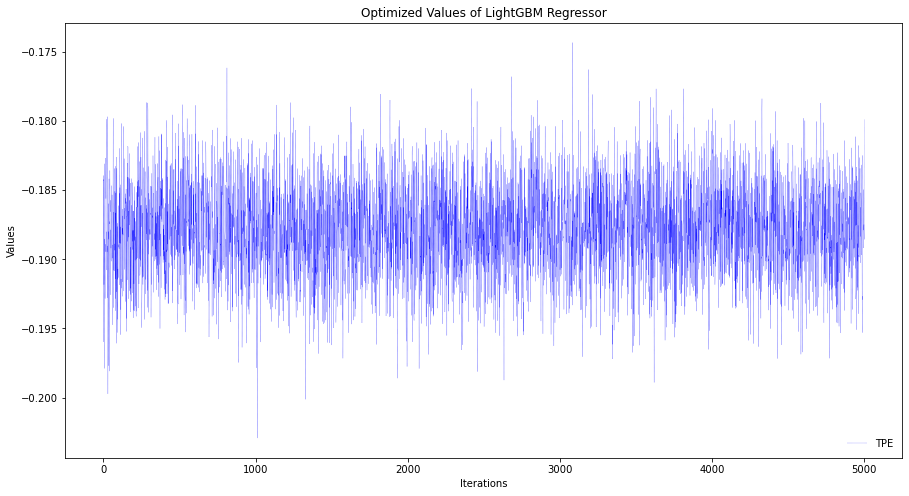

In [29]:
#####value loss plot#####
val_tpe = val
#val_mtpe = val

fig = plt.figure(figsize = (15,8))
plt.plot(val_tpe, 'b--', linewidth = 0.2, label = 'TPE')
#plt.plot(val_mtpe, 'r--', linewidth = 0.1, label = 'MTPE')
plt.title('Optimized Values of LightGBM Regressor')
plt.xlabel('Iterations')
plt.ylabel('Values')
#plt.ylim((0.94, 0.97))
plt.legend(loc = 'lower right', frameon = False)

In [30]:
##### hyperparameter importance #####
start = time.time()

#importances = optuna.importance.get_param_importances(study)
#importances.optuna.importance.get_param_importances(study, evaluator = optuna.importance.FanovaImportanceEvaluator())

importance_fig = optuna.visualization.plot_param_importances(study)
importance_fig.show()

end = time.time()
print("\nRun Time：%f seconds" % (end - start))


Run Time：745.915632 seconds


### Regressor


 Dataset 0:
[LightGBM] [Warning] lambda_l1 is set=0.025, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.025
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



Best Threshold: 9.341596665080687e-07 

Recall: [0.72222222] ,   Precision: [0.00042491] ,   Aging Rate: [0.54728727]

 Dataset 1:
[LightGBM] [Warning] lambda_l1 is set=0.025, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.025
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



Best Threshold: 4.077569958595233e-07 

Recall: [0.72222222] ,   Precision: [0.00034613] ,   Aging Rate: [0.6718423]

 Dataset 2:
[LightGBM] [Warning] lambda_l1 is set=0.025, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.025
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



Best Threshold: 7.160928115515389e-08 

Recall: [0.72222222] ,   Precision: [0.00035031] ,   Aging Rate: [0.66382842]

 Dataset 3:
[LightGBM] [Warning] lambda_l1 is set=0.025, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.025
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



Best Threshold: 1.3092170646341835e-07 

Recall: [0.72222222] ,   Precision: [0.0003514] ,   Aging Rate: [0.66177128]

 Dataset 4:
[LightGBM] [Warning] lambda_l1 is set=0.025, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.025
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



Best Threshold: 8.814575888571961e-08 

Recall: [0.72222222] ,   Precision: [0.00035943] ,   Aging Rate: [0.6469778]

 Dataset 5:
[LightGBM] [Warning] lambda_l1 is set=0.025, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.025
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
Best Threshold: 0.007957968607998158 

Recall: [0.72222222] ,   Precision: [0.00036887] ,   Aging Rate: [0.63043128]

 Dataset 6:
[LightGBM] [Warning] lambda_l1 is set=0.025, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.025
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



Best Threshold: 0.10874230269161934 

Recall: [0.72222222] ,   Precision: [0.000444] ,   Aging Rate: [0.52374649]

 Dataset 7:
[LightGBM] [Warning] lambda_l1 is set=0.025, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.025
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



Best Threshold: 0.06812365176316476 

Recall: [0.72222222] ,   Precision: [0.0004116] ,   Aging Rate: [0.56497862]

 Dataset 8:
[LightGBM] [Warning] lambda_l1 is set=0.025, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.025
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
Best Threshold: 0.010521816059799348 

Recall: [0.72222222] ,   Precision: [0.00035956] ,   Aging Rate: [0.64674526]


/home/ruibone/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



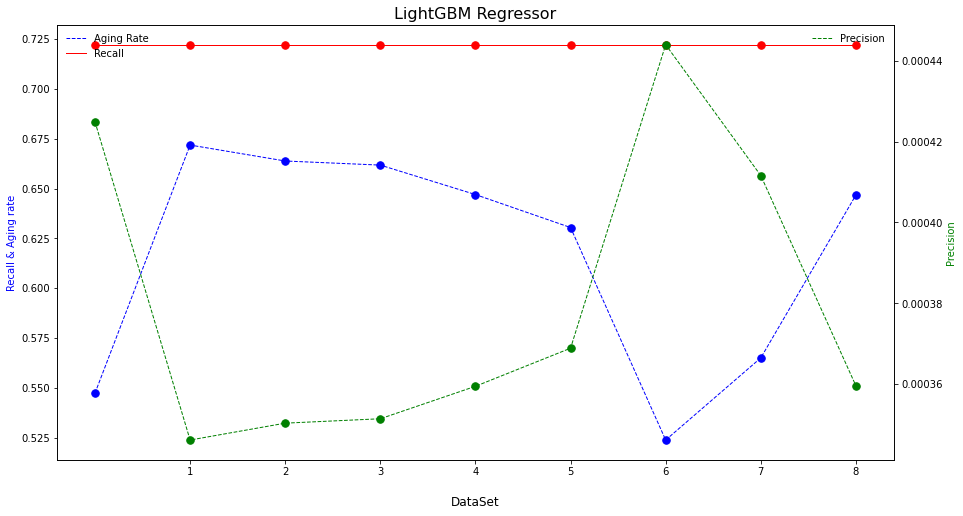


Run Time：7.338152 seconds


In [49]:
start = time.time()

# event_reg_param = {
#         'objective': 'binary',
#         'metric': 'binary_logloss',
#         'boosting_type': 'goss',
#         'num_iterations': 250,
#         'subsample': 0.6,
#         'num_leaves': 35,
#         'min_child_samples': 18,
#         'max_depth': 9,
#         'learning_rate': 0.025,
#         'lambda_l1': 0.0006,
#         'lambda_l2': 0.002
# }

run_reg_param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'num_iterations': 200,
        'subsample': 0.7,
        'num_leaves': 40,
        'min_child_samples': 15,
        'max_depth': 11,
        'learning_rate': 0.175,
        'lambda_l1': 0.025,
        'lambda_l2': 0.005
}

# run_reg_param = {
#         'objective': 'binary',
#         'metric': 'binary_logloss',
#         'boosting_type': 'gbdt',
#         'num_iterations': 150,
#         'subsample': 0.9,
#         'num_leaves': 20,
#         'min_child_samples': 9,
#         'max_depth': 5,
#         'learning_rate': 0.475,
#         'lambda_l1': 0.0003,
#         'lambda_l2': 0.0006
# }

# pr_dict, table_set2, bad_set2 = runall_LightGBMR(9, trainset_x, test_x, trainset_y, test_y, event_reg_param, 
#                                                  thres_target = 'Recall', threshold = 0.8)
pr_dict, table_set2 = runall_LightGBMR(9, trainset_x, run_test_x, trainset_y, run_test_y, run_reg_param, 
                                       thres_target = 'Recall', threshold = 0.7, record_bad = False)
line_chart(table_set2, title = 'LightGBM Regressor')
#bad_plot(bad_set2)

end = time.time()
print("\nRun Time：%f seconds" % (end - start))

,Class_Prob,train_OK,train_NG,Balance Ratio,TP,FP,FN,TN,Recall,Precision,Aging Rate,Efficiency,Score
dataset 0,9.341597e-07,79742.0,653.0,122.116386,13.0,30582.0,5.0,25303.0,0.722222,0.000425,0.547287,1.319640,0.607686
dataset 1,4.077570e-07,79742.0,39869.0,2.000100,13.0,37545.0,5.0,18340.0,0.722222,0.000346,0.671842,1.074988,0.527190
dataset 2,7.160928e-08,79742.0,40197.0,1.983780,13.0,37097.0,5.0,18788.0,0.722222,0.000350,0.663828,1.087965,0.531693
dataset 3,1.309217e-07,79742.0,40197.0,1.983780,13.0,36982.0,5.0,18903.0,0.722222,0.000351,0.661771,1.091347,0.532862
dataset 4,8.814576e-08,79742.0,39871.0,2.000000,13.0,36155.0,5.0,19730.0,0.722222,0.000359,0.646978,1.116301,0.541428
dataset 5,7.957969e-03,3265.0,1637.0,1.994502,13.0,35230.0,5.0,20655.0,0.722222,0.000369,0.630431,1.145600,0.551358
dataset 6,1.087423e-01,3265.0,1959.0,1.666667,13.0,29266.0,5.0,26619.0,0.722222,0.000444,0.523746,1.378954,0.625922
dataset 7,6.812365e-02,3265.0,1959.0,1.666667,13.0,31571.0,5.0,24314.0,0.722222,0.000412,0.564979,1.278318,0.594705
dataset 8,1.052182e-02,3265.0,1632.0,2.000613,13.0,36142.0,5.0,19743.0,0.722222,0.000360,0.646745,1.116703,0.541565


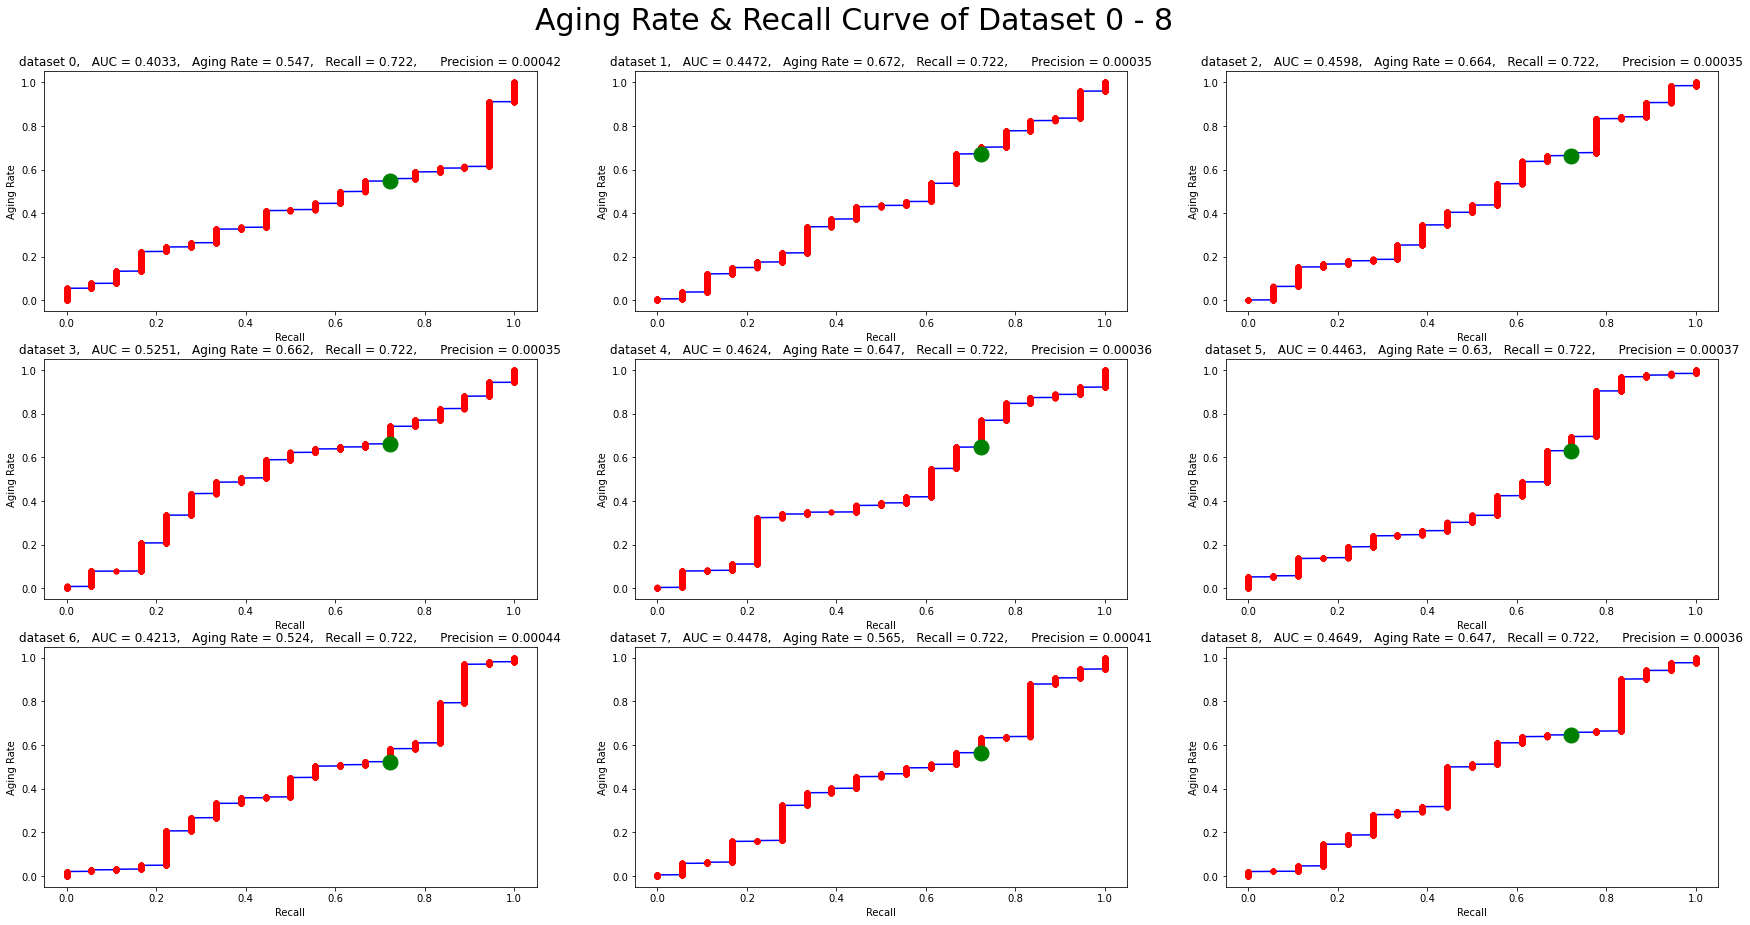

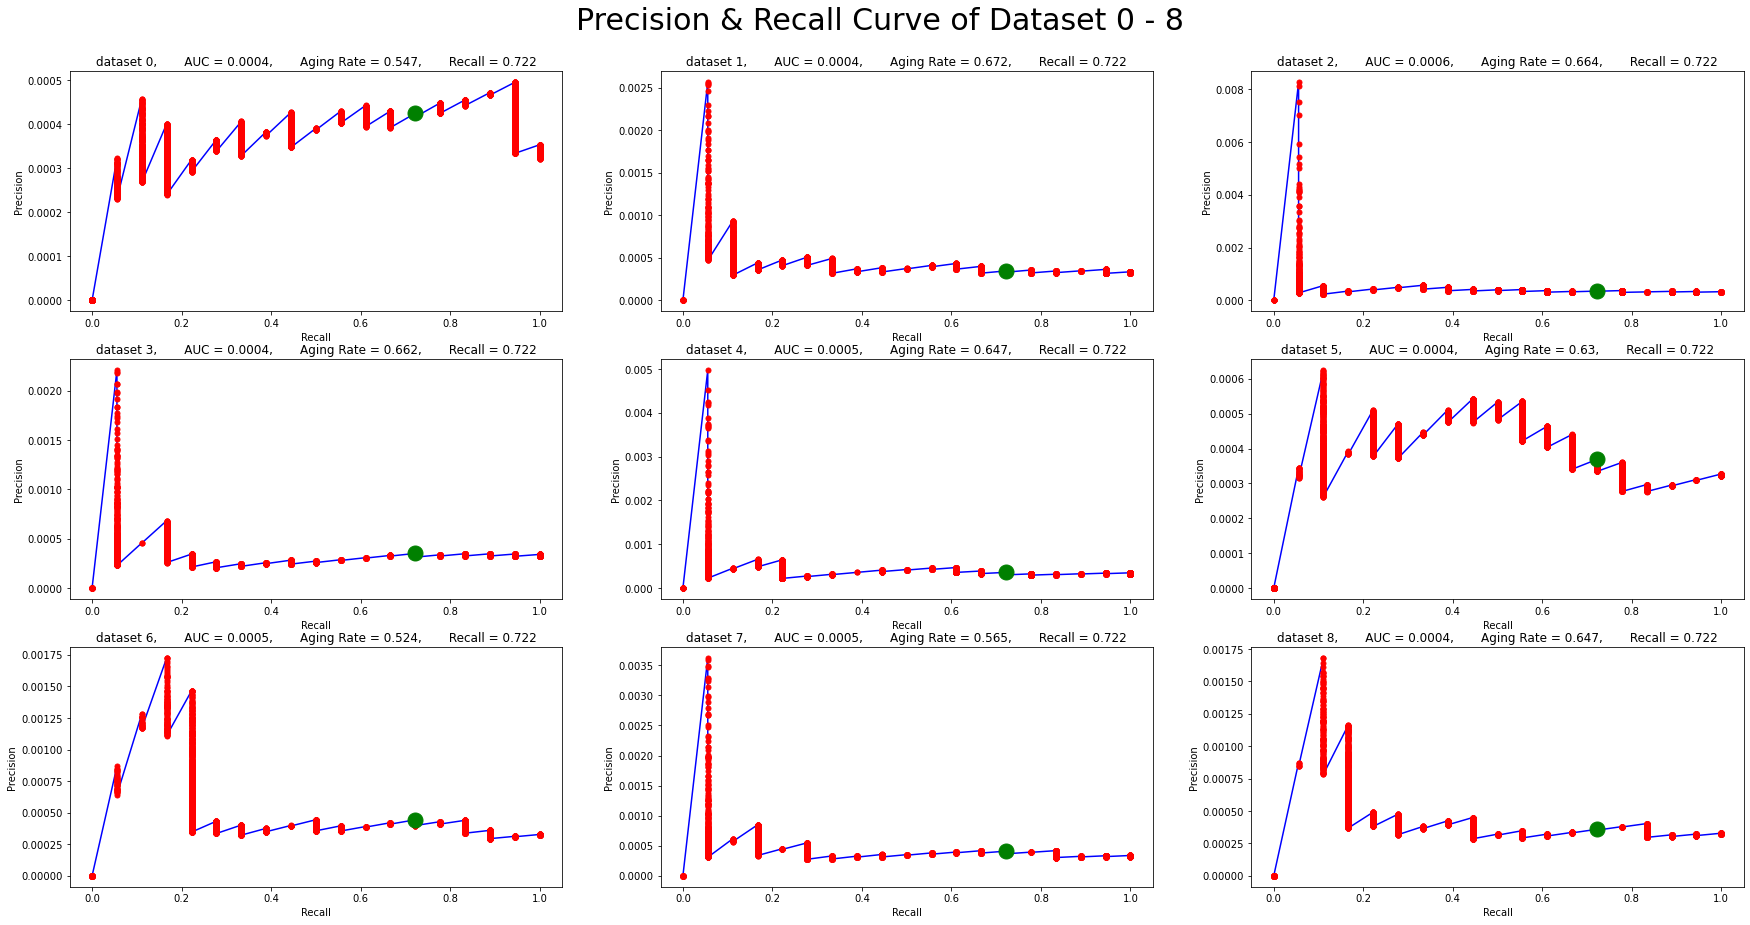

In [50]:
multiple_curve(3, 3, pr_dict, table_set2, target = 'Aging Rate')
multiple_curve(3, 3, pr_dict, table_set2, target = 'Precision')
table_set2